# Universal Differential Equation for a 2D PDE heat equation

In [1]:
using Pkg; Pkg.activate("../../."); Pkg.instantiate()
using Plots; gr()
using Statistics
using StatsBase
using LinearAlgebra
using Zygote
using PaddedViews
using Flux
using Flux: @epochs
using Tullio

  Activating environment at `~/Dropbox/Glacier UDE/ODINN_toy/Project.toml`


### Parameter declaration

In [2]:
nx, ny = 100, 100 # Size of the grid
Δx, Δy = 1, 1
Δt = 0.1
t₁ = 5

#D₀ = 1
tolnl = 1e-4
itMax = 20
damp = 0.85
dτsc   = 1.0/3.0
ϵ     = 1e-4            # small number
cfl  = max(Δx^2,Δy^2)/4.1;

In [3]:
function heatflow(T, fD::Function, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = fD(t)  # compute the diffusivity at each time
            # if iter == 1
            #     println("current D: ", D)
            # end
            
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow (generic function with 2 methods)

In [4]:
function Heat(T, D, p)
   
    Δx, Δy, Δt, t₁ = p
    
    #dTdx = diff(S, dims=1) / Δx
    #dTdy = diff(S, dims=2) / Δy

    dTdx_edges = diff(T[:,2:end - 1], dims=1) / Δx
    dTdy_edges = diff(T[2:end - 1,:], dims=2) / Δy
    
    Fx = -D * dTdx_edges
    Fy = -D * dTdy_edges    
    F = .-(diff(Fx, dims=1) / Δx .+ diff(Fy, dims=2) / Δy) 

    dτ = dτsc * min( 10.0 , 1.0/(1.0/Δt + 1.0/(cfl/(ϵ + D))))
    
    return F, dτ
 
end

Heat (generic function with 1 method)

## Creating a reference dataset with a fake law

Let's assume that $D$ is a function of time

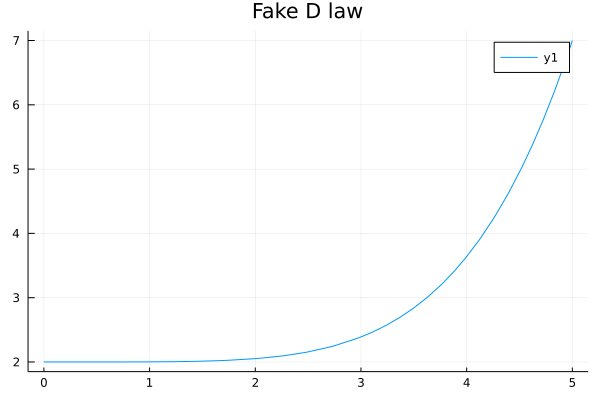

In [5]:
D_max = 10
D_min = 0

fakeD(t) = 1 * (2 + t^5 / t₁^4)

plot(fakeD, 0, t₁, title="Fake D law")

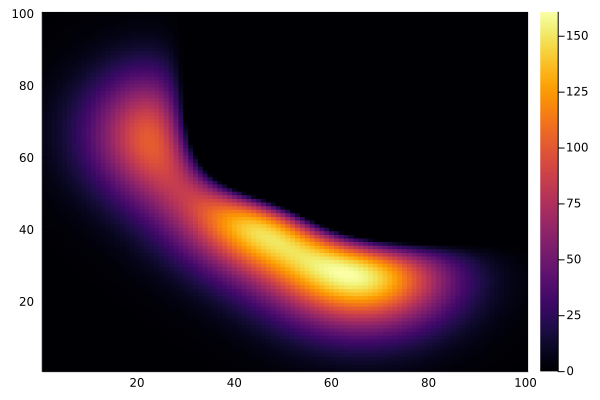

In [6]:
function truncated_gaussian(i₀, j₀, off) 
    
    M = [ 250 * exp( - ( (i - i₀)^2 + (j - j₀)^2 ) / 300 ) - off for i in 1:nx, j in 1:ny ]
    max.(0., M)
    
end

#T₀ = [ 250 * exp( - ( (i - nx/2)^2 + (j - ny/2)^2 ) / 300 ) for i in 1:nx, j in 1:ny ]

#T₀ = [ -(i - nx/2)^2 - (j - ny/.6)^2 + 40000 for i in 1:nx, j in 1:ny ]
#T₀ = max.(0., T₀)

T₀ = 1.5 * truncated_gaussian(nx/2, ny/2, 0) + 
     1 * truncated_gaussian(nx/3, ny/1.5, 0) +
     1 * truncated_gaussian(nx/1.5, ny/3, 0) - 
     4 * truncated_gaussian(nx/1.5, ny/2, 0) - 
     2 * truncated_gaussian(nx/2, ny/1.5, 0)

T₀ = max.(0., T₀)

heatmap(T₀, clim=(0, maximum(T₀)))

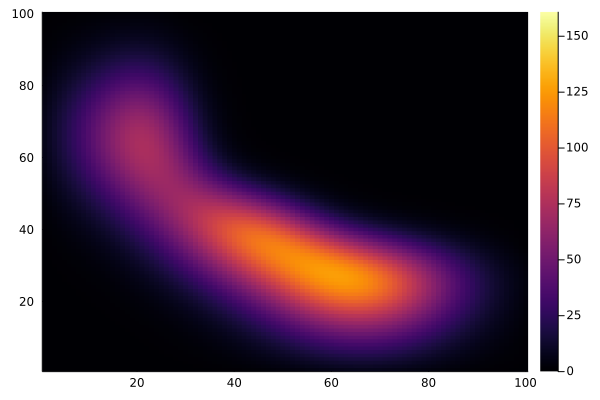

In [7]:
p = (Δx, Δy, Δt, t₁)

T₁ = copy(T₀)
T₁ = heatflow(T₁, fakeD, p, 1e-2)

heatmap(T₁, clim=(0, maximum(T₀)))

In [8]:
sqrt( sum((T₁.-T₀).^2) / (nx * ny) )

10.095895612117783

## Using a neural network to learn D

Now, let's try to reproduce `fakeD()` with a NN.

In [9]:
function heatflow_NN(T, uD, p, tol=1e-4)
   
    Δx, Δy, Δt, t₁ = p
    
    total_iter = 0
    t = 0
    
    while t < t₁
        
        iter = 1
        err = 2 * tolnl
        Hold = copy(T)
        dTdt = zeros(nx, ny)
        err = Inf 
        
        while iter < itMax+1 && tol <= err
            
            Err = copy(T)
                    
            D = uD([t]')[1]  # compute the diffusivity at each time
            #println(D)
            F, dτ = Heat(T, D, p)
            
            @tullio ResT[i,j] := -(T[i,j] - Hold[i,j])/Δt + F[pad(i-1,1,1),pad(j-1,1,1)] 
            
            dTdt_ = copy(dTdt)
            @tullio dTdt[i,j] := dTdt_[i,j]*damp + ResT[i,j]
            
            T_ = copy(T)
            #@tullio T[i,j] := max(0.0, T_[i,j] + dTdt[i,j]*dτ[pad(i-1,1,1),pad(j-1,1,1)]) 
            @tullio T[i,j] := max(0.0, T_[i,j] + dτ * dTdt[i,j])
            
            Zygote.ignore() do
                Err .= Err .- T
                err = maximum(Err)
            end 
            
            iter += 1
            total_iter += 1
            
        end
        
        t += Δt
        
    end
    
    return T
    
end

heatflow_NN (generic function with 2 methods)

In [10]:
sqnorm(x) = sum(abs2, x)

function loss(T, UD, p, λ=1)

    T = heatflow_NN(T, UD, p)
    l_cost = sqrt(Flux.Losses.mse(T, T₁; agg=mean))
    #l_reg  = sum(sqnorm, ps)

    return l_cost #+ λ * l_reg
end

loss (generic function with 2 methods)

In [11]:
# Patch suggested by Michael Abbott needed in order to correctly retrieve gradients
Flux.Optimise.update!(opt, x::AbstractMatrix, Δ::AbstractVector) = Flux.Optimise.update!(opt, x, reshape(Δ, size(x)))

function train(loss, p)
    
    leakyrelu(x, a=0.01) = max(a*x, x)
    relu(x) = max(0, x)
    sigmoid_D(x) = .5 + 10 / ( 1 + exp(-x) ) 

    UD = Chain(
        Dense(1,5, initb=Flux.glorot_normal), 
        Dense(5, 5, x->tanh.(x), initb =Flux.glorot_normal), 
        Dense(5, 5, x->tanh.(x), initb=Flux.glorot_normal),
        Dense(5,1, relu, initb = Flux.zeros) 
    )
    
    #UD = Chain(
    #    Dense(1,5,initb = Flux.glorot_normal), 
    #    Dense(5, 5, x->tanh.(x), initb = Flux.glorot_normal),
    #    Dense(5, 1, relu, initb = Flux.glorot_normal)
    #)
    
    
    opt = ADAM(1.0e-3)
    
    losses = []
    @epochs 200 hybrid_train!(loss, UD, p, opt, losses)
    
    return UD, losses
    
end

function hybrid_train!(loss, UD, p, opt, losses)
    
    T = T₀
    θ = Flux.params(UD)
    loss_uD, back_uD = Zygote.pullback(() -> loss(T, UD, p), θ)
    push!(losses, loss_uD)
    
    println("Current loss: ", loss_uD)
    println("Current parameter:", θ)
    ∇_uD = back_uD(one(loss_uD))
    
    Flux.Optimise.update!(opt, θ, ∇_uD)
    
    
end

hybrid_train! (generic function with 1 method)

In [12]:
UD_trained, losses = train(loss, p)

┌ Info: Epoch 1
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 8.593653737809248
Current parameter:Params([Float32[-0.50422573; 0.1390028; -0.24090838; 0.26698613; -0.34262705], Float32[-0.3552117, 1.2489481, -0.65845484, 0.010325378, 0.12726302], Float32[0.17357853 -0.5355876 -0.7165078 0.48749277 0.551929; -0.6463077 -0.65934306 -0.70112926 0.082478225 0.47609922; -0.5757686 -0.06326098 -0.617813 -0.38736594 -0.087666206; -0.63621616 -0.63332707 -0.7609471 -0.2347471 0.40796605; -0.40289092 0.48117545 0.087782 0.19622986 0.61205584], Float32[-0.13961558, -0.35211676, 0.2803795, -0.37835756, -0.5398629], Float32[0.451971 -0.4278223 0.47102314 0.41025662 -0.019425197; -0.49931344 -0.65530306 0.57781005 0.7180305 -0.004737551; 0.50545514 0.42643094 0.36556634 0.6309419 -0.35690233; 0.15402165 0.12691125 0.626855 0.76112145 0.750662; 0.092189535 -0.12803152 -0.16630995 -0.44692928 -0.5002186], Float32[-0.5184313, -0.2657313, -0.094123356, -0.5778284, 0.60369885], Float32[-0.7441642 -0.6448982 0.78388405 0.58289623 0.9600489], Float32[0

┌ Info: Epoch 2
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 8.442925469851993
Current parameter:Params([Float32[-0.5052257; 0.1380028; -0.24190839; 0.26798612; -0.34162706], Float32[-0.3562117, 1.247948, -0.6594548, 0.011325378, 0.12826303], Float32[0.17257853 -0.5345876 -0.7175078 0.48849276 0.550929; -0.6473077 -0.6583431 -0.70212924 0.08347823 0.47509924; -0.5747686 -0.06426098 -0.616813 -0.38836592 -0.086666204; -0.6352162 -0.63432705 -0.7599471 -0.2357471 0.40896603; -0.40189093 0.48017547 0.088782005 0.19522986 0.6130558], Float32[-0.13861558, -0.35111678, 0.27937952, -0.37935755, -0.54086286], Float32[0.45297098 -0.42882228 0.47002316 0.40925664 -0.020425197; -0.49831346 -0.65630305 0.57681006 0.7170305 -0.005737551; 0.50445515 0.42743093 0.36656633 0.6319419 -0.35590234; 0.15302165 0.12791125 0.627855 0.76212144 0.751662; 0.09118953 -0.12703152 -0.16530995 -0.4459293 -0.49921858], Float32[-0.5194313, -0.2667313, -0.093123354, -0.5768284, 0.60469884], Float32[-0.7451642 -0.6438982 0.78488404 0.5838962 0.9610489], Float32[0.

┌ Info: Epoch 3
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 8.291582840875634
Current parameter:Params([Float32[-0.50622225; 0.13700329; -0.24290803; 0.26898643; -0.3406277], Float32[-0.35721186, 1.2469479, -0.6604551, 0.012326049, 0.12926337], Float32[0.17157826 -0.5335873 -0.7185082 0.489493 0.5499291; -0.6483075 -0.65734303 -0.7031293 0.08447798 0.47409993; -0.5737681 -0.06526194 -0.6158121 -0.38936624 -0.08566667; -0.6342157 -0.63532746 -0.75894666 -0.23674758 0.4099663; -0.40089107 0.4791756 0.089781955 0.19422995 0.61405545], Float32[-0.1376151, -0.35011655, 0.27837843, -0.380358, -0.54186285], Float32[0.4539703 -0.4298228 0.46902305 0.40825793 -0.021425016; -0.49731368 -0.65730387 0.5758096 0.7160314 -0.006737756; 0.503456 0.4284312 0.36756632 0.6329401 -0.35490268; 0.15202227 0.12891172 0.6288551 0.76311827 0.7526618; 0.09019025 -0.12603086 -0.16430986 -0.44493002 -0.49821877], Float32[-0.5204315, -0.26773185, -0.09212323, -0.5758282, 0.605699], Float32[-0.7461647 -0.64289916 0.7858854 0.5848958 0.96205026], Float32[0.0020

┌ Info: Epoch 4
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 8.139940010133161
Current parameter:Params([Float32[-0.50721246; 0.13600461; -0.24390705; 0.26998726; -0.33962944], Float32[-0.35821158, 1.2459481, -0.66145533, 0.013327219, 0.13026352], Float32[0.17057769 -0.53258675 -0.7195089 0.49049369 0.54892915; -0.64930683 -0.6563434 -0.704129 0.08547731 0.47310168; -0.57276726 -0.06626289 -0.61481106 -0.39036703 -0.08466703; -0.63321465 -0.63632816 -0.7579456 -0.23774886 0.41096705; -0.3998915 0.47817627 0.09078162 0.1932302 0.6150545], Float32[-0.13661438, -0.34911656, 0.27737728, -0.38135877, -0.54286236], Float32[0.45496792 -0.43082488 0.46802318 0.40725937 -0.022424199; -0.4963149 -0.65830666 0.57480884 0.7150315 -0.0077379434; 0.5024588 0.4294327 0.3685659 0.6339372 -0.35390395; 0.15102464 0.12991403 0.6298549 0.7641143 0.75366086; 0.08919265 -0.12502865 -0.16330996 -0.4439307 -0.49721953], Float32[-0.52143157, -0.26873276, -0.09112345, -0.57482815, 0.60669905], Float32[-0.7471654 -0.6419023 0.78688806 0.5858954 0.9630532], F

┌ Info: Epoch 5
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.988197444623416
Current parameter:Params([Float32[-0.50819296; 0.13500716; -0.24490517; 0.27098876; -0.3386328], Float32[-0.35921052, 1.244949, -0.6624553, 0.0143289175, 0.1312632], Float32[0.16957678 -0.53158617 -0.72050995 0.4914949 0.5479293; -0.65030545 -0.6553445 -0.70512813 0.08647601 0.47210488; -0.5717662 -0.067263365 -0.61381 -0.39136854 -0.08366704; -0.6322127 -0.63732916 -0.75694376 -0.23875126 0.41196853; -0.39889237 0.47717777 0.09178084 0.19223069 0.6160527], Float32[-0.13561349, -0.34811705, 0.27637663, -0.38235986, -0.54386115], Float32[0.45596293 -0.43182915 0.46702373 0.40626073 -0.023422433; -0.49531776 -0.6593122 0.5738078 0.7140304 -0.008738013; 0.5014646 0.43043584 0.36956477 0.63493294 -0.35290655; 0.15002964 0.13091893 0.6308542 0.76511 0.7546588; 0.088197574 -0.124024294 -0.16231039 -0.4429311 -0.49622113], Float32[-0.52243125, -0.269734, -0.090124264, -0.5738286, 0.6076988], Float32[-0.7481662 -0.64090884 0.787893 0.5868953 0.96405786], Float32

┌ Info: Epoch 6
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.836566861375201
Current parameter:Params([Float32[-0.50915974; 0.13401131; -0.24590208; 0.2719911; -0.33763832], Float32[-0.3602084, 1.2439507, -0.6634549, 0.015331216, 0.13226214], Float32[0.16857548 -0.5305856 -0.7215114 0.49249673 0.54692954; -0.6513031 -0.6543466 -0.7061266 0.08747391 0.47110996; -0.57076484 -0.06826304 -0.6128091 -0.39237097 -0.08266653; -0.6312096 -0.6383306 -0.755941 -0.23975508 0.41297093; -0.39789385 0.47618037 0.092779465 0.1912315 0.61704975], Float32[-0.13461244, -0.34711823, 0.27537686, -0.38336134, -0.544859], Float32[0.45695448 -0.43283615 0.46602482 0.40526184 -0.024419442; -0.49432287 -0.6603211 0.5728063 0.7130277 -0.009737878; 0.50047433 0.43144104 0.37056273 0.6359271 -0.35191092; 0.14903815 0.13192703 0.6318528 0.76610535 0.7556553; 0.087205864 -0.12301726 -0.16131125 -0.44193107 -0.49522382], Float32[-0.5234304, -0.27073562, -0.089125894, -0.57282966, 0.6086981], Float32[-0.7491672 -0.63991976 0.78890157 0.58789545 0.9650644], Floa

┌ Info: Epoch 7
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.685267498698716
Current parameter:Params([Float32[-0.5101082; 0.13301751; -0.24689741; 0.2729944; -0.33664662], Float32[-0.3612049, 1.2429537, -0.6644539, 0.016334187, 0.13326013], Float32[0.1675738 -0.5295851 -0.7225133 0.49349922 0.54592997; -0.6522996 -0.6533499 -0.7071241 0.08847078 0.47011736; -0.5697631 -0.06926167 -0.6118084 -0.3933745 -0.08166534; -0.63020515 -0.6393325 -0.754937 -0.2407606 0.41397443; -0.39689606 0.47518438 0.09377733 0.19023275 0.6180455], Float32[-0.13361129, -0.3461203, 0.27437824, -0.3843633, -0.54585564], Float32[0.4579417 -0.43384632 0.46502653 0.4042627 -0.025414962; -0.49333093 -0.66133404 0.5718044 0.71202326 -0.010737445; 0.49948904 0.43244857 0.37155953 0.63691914 -0.3509175; 0.14805102 0.13293883 0.6328506 0.76710033 0.75665003; 0.086218394 -0.1220071 -0.16031264 -0.44093058 -0.49422783], Float32[-0.52442896, -0.27173766, -0.088128544, -0.57183146, 0.609697], Float32[-0.7501683 -0.63893634 0.789915 0.588896 0.9660732], Float32[0.005

┌ Info: Epoch 8
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.534521734122948
Current parameter:Params([Float32[-0.5110329; 0.1320262; -0.24789082; 0.27399874; -0.33565837], Float32[-0.36219972, 1.241958, -0.6654523, 0.01733789, 0.13425693], Float32[0.16657175 -0.5285848 -0.7235156 0.49450243 0.54493076; -0.6532946 -0.65235466 -0.7081205 0.08946641 0.46912754; -0.568761 -0.070259064 -0.61080796 -0.39437938 -0.080663316; -0.62919915 -0.6403349 -0.75393164 -0.24176808 0.41497916; -0.3958992 0.47419003 0.09477426 0.18923454 0.6190396], Float32[-0.1326101, -0.3451234, 0.273381, -0.38536578, -0.54685086], Float32[0.4589237 -0.4348601 0.46402898 0.4032632 -0.02640874; -0.49234265 -0.6623515 0.5708021 0.7110168 -0.011736606; 0.49850976 0.43345866 0.37255496 0.63790864 -0.3499267; 0.14706917 0.13395481 0.6338474 0.7680948 0.7576427; 0.08523609 -0.12099343 -0.15931462 -0.43992954 -0.4932334], Float32[-0.52542686, -0.27274016, -0.087132424, -0.5708341, 0.61069524], Float32[-0.7511696 -0.6379598 0.7909345 0.589897 0.9670846], Float32[0.00699

┌ Info: Epoch 9
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.3845515346185335
Current parameter:Params([Float32[-0.5119278; 0.13103785; -0.24888188; 0.27500418; -0.33467427], Float32[-0.36319262, 1.240964, -0.66644984, 0.018342368, 0.13525228], Float32[0.16556941 -0.52758473 -0.7245183 0.49550632 0.54393214; -0.65428793 -0.65136117 -0.7091156 0.09046057 0.46814096; -0.5677584 -0.071255036 -0.6098077 -0.3953858 -0.07966033; -0.6281914 -0.64133793 -0.75292474 -0.24277778 0.4159853; -0.39490348 0.47319764 0.095770076 0.188237 0.6200318], Float32[-0.13160892, -0.34412774, 0.27238533, -0.3863689, -0.5478444], Float32[0.45989946 -0.43587786 0.46303228 0.4022634 -0.027400522; -0.49135888 -0.6633739 0.5697993 0.71000814 -0.012735233; 0.49753764 0.43447143 0.37354878 0.63889503 -0.34893903; 0.1460935 0.13497534 0.6348432 0.7690885 0.758633; 0.08425992 -0.119975895 -0.15831727 -0.43892795 -0.49224082], Float32[-0.526424, -0.27374315, -0.086137734, -0.56983775, 0.6116929], Float32[-0.75217104 -0.63699144 0.79196084 0.5908984 0.96809894], Fl

┌ Info: Epoch 10
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.235573283386625
Current parameter:Params([Float32[-0.51278615; 0.13005297; -0.24987018; 0.27601072; -0.33369508], Float32[-0.36418334, 1.2399721, -0.6674463, 0.019347642, 0.13624594], Float32[0.16456686 -0.5265851 -0.7255212 0.49651083 0.5429343; -0.6552793 -0.65036964 -0.71010923 0.091453016 0.4671581; -0.5667552 -0.072249405 -0.60880774 -0.39639395 -0.07865626; -0.62718177 -0.6423416 -0.7519161 -0.24378991 0.41699287; -0.3939091 0.4722075 0.09676457 0.18724027 0.62102175], Float32[-0.13060786, -0.3431335, 0.27139145, -0.3873727, -0.548836], Float32[0.460868 -0.43689987 0.46203646 0.4012633 -0.028390057; -0.49038047 -0.6644016 0.56879604 0.70899725 -0.013733174; 0.4965738 0.43548703 0.37454075 0.6398777 -0.3479549; 0.145125 0.13600075 0.63583773 0.7700813 0.75962067; 0.08329091 -0.11895423 -0.15732068 -0.43792585 -0.49125028], Float32[-0.5274203, -0.27474666, -0.08514468, -0.5688424, 0.61268985], Float32[-0.7531725 -0.63603276 0.7929948 0.5919003 0.9691166], Float32[0.

┌ Info: Epoch 11
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 7.087794570557741
Current parameter:Params([Float32[-0.51360047; 0.12907209; -0.25085527; 0.27701837; -0.3327216], Float32[-0.3651716, 1.2389824, -0.6684416, 0.020353712, 0.13723761], Float32[0.16356423 -0.52558607 -0.7265243 0.4975159 0.54193753; -0.6562684 -0.6493803 -0.7111011 0.092443496 0.46617946; -0.5657513 -0.07324201 -0.60780805 -0.39740402 -0.07765101; -0.62617004 -0.64334595 -0.7509057 -0.24480465 0.41800204; -0.39291626 0.47121993 0.09775754 0.18624455 0.62200916], Float32[-0.12960704, -0.34214088, 0.27039954, -0.38837722, -0.5498253], Float32[0.4618283 -0.43792638 0.46104163 0.40026295 -0.029377095; -0.4894084 -0.6654349 0.56779224 0.70798415 -0.014730252; 0.49561945 0.43650547 0.37553063 0.6408559 -0.34697476; 0.14416464 0.1370313 0.63683105 0.77107286 0.7606054; 0.08233015 -0.117928185 -0.15632492 -0.43692327 -0.49026206], Float32[-0.5284157, -0.2757507, -0.08415349, -0.5678482, 0.613686], Float32[-0.75417405 -0.6350852 0.79403687 0.59290266 0.9701381], Flo

┌ Info: Epoch 12
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.941413140743191
Current parameter:Params([Float32[-0.51436263; 0.12809575; -0.2518367; 0.27802706; -0.33175465], Float32[-0.3661573, 1.2379954, -0.6694355, 0.021360554, 0.13822703], Float32[0.16256171 -0.52458787 -0.72752744 0.49852136 0.54094213; -0.65725505 -0.64839345 -0.712091 0.09343176 0.46520552; -0.56474674 -0.074232675 -0.6068086 -0.39841613 -0.07664447; -0.62515616 -0.644351 -0.7498933 -0.24582218 0.4190128; -0.39192522 0.47023526 0.09874875 0.18524998 0.6229937], Float32[-0.1286066, -0.34115005, 0.26940978, -0.38938245, -0.55081207], Float32[0.46277922 -0.4389576 0.46004784 0.39926243 -0.030361379; -0.48844373 -0.6664741 0.566788 0.70696884 -0.015726266; 0.4946758 0.43752676 0.37651816 0.64182895 -0.34599912; 0.14321344 0.13806722 0.637823 0.77206296 0.7615869; 0.08137878 -0.11689758 -0.15533009 -0.4359203 -0.48927644], Float32[-0.5294101, -0.2767552, -0.083164364, -0.5668552, 0.6146813], Float32[-0.75517565 -0.63415045 0.7950874 0.5939055 0.97116363], Float3

┌ Info: Epoch 13
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.796615207368296
Current parameter:Params([Float32[-0.5150643; 0.1271245; -0.25281394; 0.27903673; -0.33079514], Float32[-0.36714017, 1.2370112, -0.6704278, 0.022368116, 0.13921392], Float32[0.16155952 -0.5235907 -0.72853047 0.49952707 0.53994846; -0.6582388 -0.6474093 -0.7130788 0.09441755 0.4642368; -0.56374145 -0.075221226 -0.6058095 -0.39943045 -0.075636595; -0.6241401 -0.6453567 -0.74887896 -0.2468426 0.4200252; -0.39093623 0.46925384 0.09973795 0.18425679 0.623975], Float32[-0.12760673, -0.3401612, 0.26842237, -0.3903884, -0.55179596], Float32[0.46371964 -0.43999368 0.45905516 0.39826187 -0.03134265; -0.48748758 -0.66751933 0.5657834 0.70595145 -0.016720988; 0.4937441 0.43855083 0.3775031 0.64279604 -0.34502843; 0.14227247 0.13910866 0.63881344 0.77305114 0.7625649; 0.08043801 -0.115862295 -0.15433627 -0.43491706 -0.48829368], Float32[-0.53040355, -0.2777602, -0.08217753, -0.5658635, 0.6156757], Float32[-0.7561772 -0.63323015 0.7961467 0.5949087 0.97219366], Float3

┌ Info: Epoch 14
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.6535709929841405
Current parameter:Params([Float32[-0.515697; 0.12615894; -0.2537865; 0.28004727; -0.32984397], Float32[-0.36812016, 1.2360301, -0.67141825, 0.023376325, 0.14019799], Float32[0.1605579 -0.52259475 -0.72953314 0.5005328 0.53895694; -0.6592195 -0.64642817 -0.7140641 0.095400594 0.46327376; -0.5627354 -0.07620748 -0.6048107 -0.4004471 -0.07462732; -0.62312174 -0.646363 -0.7478625 -0.247866 0.4210392; -0.38994956 0.468276 0.100724876 0.1832652 0.6249527], Float32[-0.12660764, -0.33917454, 0.26743752, -0.39139506, -0.5527767], Float32[0.4646483 -0.44103473 0.4580637 0.39726147 -0.03232065; -0.4865412 -0.6685707 0.5647784 0.70493215 -0.017714158; 0.49282566 0.43957758 0.37848517 0.6437563 -0.3440632; 0.14134283 0.14015575 0.6398024 0.774037 0.7635391; 0.07950911 -0.114822224 -0.15334356 -0.43391374 -0.48731408], Float32[-0.5313959, -0.27876562, -0.081193194, -0.5648731, 0.61666906], Float32[-0.7571786 -0.6323261 0.79721487 0.5959122 0.9732285], Float32[0.01296

┌ Info: Epoch 15
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.512436554748836
Current parameter:Params([Float32[-0.5162526; 0.12519965; -0.25475386; 0.2810585; -0.32890204], Float32[-0.3690972, 1.2350526, -0.6724067, 0.024385082, 0.14117894], Float32[0.15955713 -0.52160037 -0.73053527 0.50153834 0.537968; -0.6601968 -0.64545023 -0.7150469 0.096380636 0.4623169; -0.5617286 -0.07719125 -0.60381234 -0.40146616 -0.07361662; -0.6221011 -0.6473698 -0.746844 -0.24889247 0.42205474; -0.38896555 0.4673021 0.101709254 0.18227543 0.62592643], Float32[-0.12560955, -0.33819026, 0.26645544, -0.39240235, -0.5537539], Float32[0.46556398 -0.44208083 0.45707348 0.3962614 -0.033295106; -0.4856059 -0.66962826 0.56377316 0.70391124 -0.018705491; 0.49192175 0.44060686 0.37946415 0.64470875 -0.3431039; 0.14042564 0.14120857 0.64078975 0.7750201 0.7645092; 0.07859342 -0.113777325 -0.15235204 -0.43291053 -0.4863379], Float32[-0.53238714, -0.2797714, -0.08021158, -0.5638841, 0.61766136], Float32[-0.75817984 -0.6314402 0.798292 0.59691596 0.97426856], Float

┌ Info: Epoch 16
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.3733534353777
Current parameter:Params([Float32[-0.5167236; 0.124247216; -0.2557155; 0.28207025; -0.32797033], Float32[-0.3700713, 1.2340789, -0.67339283, 0.025394265, 0.14215648], Float32[0.15855756 -0.5206079 -0.73153657 0.50254333 0.536982; -0.66117036 -0.64447576 -0.7160268 0.097357415 0.46136668; -0.56072104 -0.07817232 -0.60281444 -0.4024877 -0.072604485; -0.6210783 -0.648377 -0.74582344 -0.24992202 0.42307177; -0.38798448 0.46633255 0.10269079 0.18128774 0.62689584], Float32[-0.1246127, -0.3372085, 0.26547635, -0.3934102, -0.55472726], Float32[0.46646535 -0.443132 0.4560846 0.39526188 -0.03426575; -0.48468304 -0.670692 0.56276774 0.702889 -0.019694675; 0.4910337 0.44163853 0.3804398 0.6456525 -0.34215102; 0.13952203 0.14226718 0.64177537 0.77599996 0.765475; 0.07769234 -0.11272759 -0.15136181 -0.43190768 -0.48536548], Float32[-0.5333772, -0.28077742, -0.0792329, -0.5628965, 0.61865246], Float32[-0.7591808 -0.6305745 0.7993781 0.5979198 0.97531414], Float32[0.0149

┌ Info: Epoch 17
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.236446788571488
Current parameter:Params([Float32[-0.5171037; 0.123302236; -0.25667086; 0.28308234; -0.32704976], Float32[-0.37104246, 1.2331094, -0.67437655, 0.026403727, 0.14313033], Float32[0.15755954 -0.51961756 -0.73253673 0.50354755 0.53599954; -0.66214 -0.643505 -0.71700364 0.098330684 0.4604236; -0.5597128 -0.07915047 -0.6018171 -0.40351176 -0.07159094; -0.62005335 -0.6493845 -0.74480087 -0.25095466 0.42409018; -0.3870067 0.46536773 0.10366918 0.1803024 0.62786055], Float32[-0.12361737, -0.33622953, 0.2645005, -0.3944185, -0.5556964], Float32[0.46735102 -0.4441883 0.45509714 0.3942632 -0.0352323; -0.48377413 -0.67176193 0.56176233 0.70186585 -0.020681366; 0.49016285 0.44267234 0.38141182 0.64658636 -0.34120506; 0.13863322 0.14333159 0.64275926 0.7769759 0.7664361; 0.07680732 -0.11167305 -0.15037298 -0.4309055 -0.4843971], Float32[-0.53436595, -0.2817836, -0.078257374, -0.5619104, 0.6196423], Float32[-0.76018137 -0.6297311 0.8004731 0.5989236 0.9763655], Float32[

┌ Info: Epoch 18
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 6.101827560744762
Current parameter:Params([Float32[-0.51738816; 0.12236531; -0.25761944; 0.28409454; -0.3261413], Float32[-0.37201083, 1.2321442, -0.6753575, 0.027413303, 0.14410022], Float32[0.15656346 -0.5186298 -0.73353547 0.5045506 0.53502107; -0.66310537 -0.6425381 -0.7179772 0.09930019 0.45948803; -0.558704 -0.080125466 -0.60082036 -0.40453836 -0.07057601; -0.6190263 -0.6503921 -0.7437763 -0.25199032 0.42510983; -0.38603258 0.46440804 0.104644105 0.17931968 0.6288201], Float32[-0.12262386, -0.33525348, 0.26352814, -0.3954271, -0.556661], Float32[0.46821958 -0.44524962 0.45411116 0.3932657 -0.036194477; -0.4828807 -0.67283785 0.56075704 0.70084226 -0.021665199; 0.4893105 0.4437081 0.38238 0.6475093 -0.3402665; 0.13776042 0.14440177 0.64374137 0.77794737 0.76739234; 0.07593989 -0.11061378 -0.14938566 -0.42990425 -0.48343313], Float32[-0.5353534, -0.28278983, -0.07728521, -0.5609258, 0.62063086], Float32[-0.7611815 -0.6289122 0.80157685 0.59992725 0.977423], Float32[0

┌ Info: Epoch 19
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.969591445099226
Current parameter:Params([Float32[-0.5175741; 0.12143702; -0.25856072; 0.28510657; -0.3252459], Float32[-0.3729766, 1.2311839, -0.6763356, 0.028422806, 0.14506589], Float32[0.15556975 -0.5176449 -0.7345324 0.5055521 0.5340471; -0.6640662 -0.6415753 -0.71894735 0.100265704 0.45856044; -0.55769473 -0.081097044 -0.5998244 -0.40556747 -0.06955977; -0.61799735 -0.6513997 -0.74275 -0.25302896 0.42613056; -0.3850625 0.46345386 0.10561522 0.17833988 0.62977415], Float32[-0.12163247, -0.33428052, 0.26255953, -0.39643583, -0.5576206], Float32[0.46906954 -0.44631594 0.4531267 0.3922697 -0.037151985; -0.48200446 -0.6739197 0.559752 0.69981873 -0.022645775; 0.48847798 0.4447455 0.3833441 0.6484201 -0.3393358; 0.13690487 0.14547773 0.6447216 0.7789137 0.76834345; 0.07509163 -0.109549865 -0.14839996 -0.42890438 -0.48247385], Float32[-0.5363396, -0.28379592, -0.0763166, -0.5599427, 0.6216179], Float32[-0.762181 -0.62812006 0.8026892 0.6009305 0.9784869], Float32[0.01791

┌ Info: Epoch 20
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.8398229497998795
Current parameter:Params([Float32[-0.5176603; 0.12051795; -0.25949416; 0.28611818; -0.32436445], Float32[-0.37394002, 1.2302287, -0.67731047, 0.02943203, 0.14602709], Float32[0.15457883 -0.51666325 -0.7355272 0.5065517 0.5330783; -0.6650222 -0.64061683 -0.71991384 0.101227 0.4576412; -0.5566851 -0.08206493 -0.5988294 -0.40659904 -0.068542294; -0.61696666 -0.65240693 -0.7417219 -0.25407046 0.4271522; -0.38409677 0.46250564 0.10658218 0.1773633 0.6307223], Float32[-0.12064354, -0.3333108, 0.26159498, -0.3974445, -0.5585748], Float32[0.46989936 -0.44738716 0.45214388 0.39127564 -0.03810453; -0.4811471 -0.67500716 0.5587474 0.69879586 -0.023622677; 0.48766658 0.44578433 0.3843039 0.6493175 -0.33841345; 0.13606785 0.14655937 0.64570004 0.7798741 0.76928914; 0.07426416 -0.10848145 -0.14741601 -0.42790627 -0.48151964], Float32[-0.53732437, -0.28480178, -0.07535175, -0.5589612, 0.6226034], Float32[-0.7631798 -0.6273571 0.8038099 0.6019332 0.97955745], Float32[0

┌ Info: Epoch 21
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.712590783265237
Current parameter:Params([Float32[-0.5176478; 0.119608656; -0.26041928; 0.28712907; -0.32349786], Float32[-0.3749014, 1.2292787, -0.678282, 0.030440755, 0.1469836], Float32[0.1535912 -0.5156853 -0.73651946 0.5075489 0.5321152; -0.6659731 -0.6396629 -0.72087646 0.10218387 0.45673072; -0.55567527 -0.083028816 -0.5978355 -0.40763304 -0.06752369; -0.6159345 -0.6534136 -0.7406924 -0.25511467 0.4281745; -0.38313589 0.46156377 0.10754462 0.17639029 0.6316641], Float32[-0.1196574, -0.33234453, 0.26063478, -0.39845282, -0.5595232], Float32[0.47070748 -0.44846317 0.45116273 0.390284 -0.039051812; -0.48031044 -0.6761001 0.5577435 0.69777435 -0.024595462; 0.4868776 0.44682425 0.38525912 0.6502003 -0.3374999; 0.13525067 0.14764665 0.64667654 0.7808278 0.77022916; 0.07345916 -0.10740869 -0.1464339 -0.4269104 -0.48057085], Float32[-0.53830767, -0.2858072, -0.074390836, -0.55798125, 0.6235873], Float32[-0.76417774 -0.62662584 0.8049386 0.6029351 0.9806349], Float32[0.01

┌ Info: Epoch 22
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.587952168159808
Current parameter:Params([Float32[-0.517539; 0.11870969; -0.26133558; 0.28813893; -0.322647], Float32[-0.37586117, 1.2283344, -0.67925006, 0.031448744, 0.1479352], Float32[0.15260734 -0.51471144 -0.7375088 0.5085434 0.5311584; -0.6669187 -0.6387137 -0.7218351 0.103136115 0.4558293; -0.55466545 -0.08398838 -0.5968429 -0.40866932 -0.06650409; -0.614901 -0.6544195 -0.7396615 -0.25616145 0.42919722; -0.3821802 0.4606287 0.10850217 0.17542116 0.6325992], Float32[-0.1186744, -0.33138183, 0.25967932, -0.39946058, -0.56046546], Float32[0.4714923 -0.44954383 0.45018333 0.38929522 -0.039993525; -0.4794963 -0.6771982 0.55674046 0.69675493 -0.025563667; 0.4861123 0.447865 0.38620958 0.65106714 -0.3365956; 0.13445465 0.14873949 0.6476511 0.781774 0.7711633; 0.07267835 -0.10633176 -0.14545378 -0.42591727 -0.47962782], Float32[-0.5392895, -0.28681198, -0.07343403, -0.55700284, 0.6245695], Float32[-0.76517475 -0.62592876 0.80607516 0.6039359 0.9817195], Float32[0.020858

┌ Info: Epoch 23
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.4659509173443945
Current parameter:Params([Float32[-0.517338; 0.11782158; -0.2622426; 0.2891474; -0.3218127], Float32[-0.37681973, 1.227396, -0.6802144, 0.032455746, 0.14888172], Float32[0.15162775 -0.513742 -0.73849475 0.5095346 0.5302084; -0.6678587 -0.63776934 -0.72278947 0.104083546 0.45493728; -0.55365586 -0.08494327 -0.5958518 -0.40970778 -0.06548365; -0.6138665 -0.65542424 -0.7386295 -0.2572106 0.43022013; -0.3812302 0.45970085 0.109454446 0.17445627 0.63352716], Float32[-0.1176949, -0.33042285, 0.25872895, -0.40046751, -0.56140107], Float32[0.47225216 -0.450629 0.4492058 0.38830987 -0.04092936; -0.47870657 -0.6783011 0.5557385 0.69573843 -0.02652681; 0.48537186 0.44890627 0.3871551 0.6519166 -0.33570096; 0.13368113 0.14983778 0.6486237 0.78271174 0.7720912; 0.07192348 -0.10525087 -0.14447577 -0.4249274 -0.47869095], Float32[-0.54026973, -0.28781596, -0.07248151, -0.556026, 0.6255498], Float32[-0.7661707 -0.62526846 0.8072192 0.60493547 0.98281133], Float32[0.021

┌ Info: Epoch 24
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.346621264969572
Current parameter:Params([Float32[-0.51704973; 0.116944835; -0.26313987; 0.29015416; -0.32099566], Float32[-0.37777758, 1.2264638, -0.6811748, 0.0334615, 0.14982301], Float32[0.15065295 -0.5127775 -0.739477 0.5105221 0.5292659; -0.66879296 -0.63683003 -0.72373956 0.105026 0.45405495; -0.5526468 -0.08589311 -0.5948625 -0.41074824 -0.06446254; -0.61283135 -0.6564275 -0.7375967 -0.25826192 0.4312429; -0.38028628 0.45878068 0.11040105 0.17349596 0.6344476], Float32[-0.11671927, -0.3294677, 0.25778407, -0.40147325, -0.5623296], Float32[0.4729854 -0.4517185 0.44823012 0.38732848 -0.041859005; -0.47794318 -0.67940855 0.55473787 0.6947257 -0.027484398; 0.4846575 0.44994777 0.38809544 0.6527474 -0.33481643; 0.13293147 0.15094143 0.64959437 0.7836402 0.77301276; 0.07119632 -0.10416625 -0.1435 -0.4239414 -0.47776058], Float32[-0.5412484, -0.28881893, -0.07153342, -0.5550507, 0.62652814], Float32[-0.7671654 -0.6246476 0.8083704 0.6059335 0.98391056], Float32[0.02281

┌ Info: Epoch 25
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.229982785678377
Current parameter:Params([Float32[-0.5166802; 0.11607993; -0.264027; 0.29115885; -0.32019663], Float32[-0.37873527, 1.2255379, -0.6821312, 0.034465738, 0.15075894], Float32[0.14968345 -0.51181823 -0.74045503 0.5115055 0.5283314; -0.6697212 -0.63589585 -0.7246852 0.10596331 0.4531826; -0.55163854 -0.08683748 -0.59387535 -0.41179052 -0.06344097; -0.61179584 -0.657429 -0.7365633 -0.25931513 0.4322653; -0.37934887 0.4578686 0.11134158 0.17254062 0.63536006], Float32[-0.11574787, -0.32851654, 0.25684512, -0.4024775, -0.56325066], Float32[0.47369027 -0.45281217 0.44725642 0.38635164 -0.04278215; -0.4772081 -0.6805201 0.55373883 0.69371766 -0.028435921; 0.48397028 0.4509892 0.3890305 0.65355796 -0.33394235; 0.13220705 0.15205033 0.6505631 0.7845583 0.7739277; 0.070498645 -0.10307812 -0.1425266 -0.4229598 -0.4768371], Float32[-0.5422254, -0.28982064, -0.07058989, -0.55407685, 0.6275044], Float32[-0.76815885 -0.6240688 0.8095284 0.6069297 0.98501736], Float32[0.0

┌ Info: Epoch 26
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.116046242961683
Current parameter:Params([Float32[-0.5162356; 0.11522731; -0.2649036; 0.29216117; -0.3194162], Float32[-0.37969336, 1.2246187, -0.68308336, 0.035468183, 0.15168941], Float32[0.14871979 -0.5108646 -0.7414285 0.5124842 0.52740556; -0.6706432 -0.63496697 -0.7256262 0.10689535 0.45232046; -0.5506314 -0.08777595 -0.59289056 -0.41283438 -0.062419154; -0.6107603 -0.6584283 -0.7355297 -0.26037 0.43328696; -0.37841848 0.4569651 0.11227563 0.17159063 0.6362642], Float32[-0.11478106, -0.32756945, 0.25591254, -0.40347987, -0.5641638], Float32[0.47436512 -0.45390978 0.44628477 0.38538 -0.043698482; -0.47650328 -0.68163544 0.55274165 0.6927152 -0.029380864; 0.4833113 0.45203024 0.38996002 0.65434694 -0.33307913; 0.13150927 0.15316437 0.6515299 0.78546506 0.7748358; 0.06983225 -0.101986736 -0.14155568 -0.42198327 -0.4759209], Float32[-0.5432008, -0.2908209, -0.06965107, -0.55310446, 0.6284785], Float32[-0.76915085 -0.6235346 0.81069285 0.60792387 0.9861318], Float32[0.

┌ Info: Epoch 27
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 5.0048114472716865
Current parameter:Params([Float32[-0.51572245; 0.11438742; -0.2657693; 0.2931607; -0.31865495], Float32[-0.38065246, 1.2237062, -0.6840312, 0.036468554, 0.15261434], Float32[0.14776248 -0.5099171 -0.7423969 0.5134577 0.5264889; -0.67155886 -0.6340435 -0.72656244 0.10782198 0.45146874; -0.5496258 -0.08870806 -0.5919085 -0.41387954 -0.061397336; -0.6097251 -0.6594251 -0.7344962 -0.26142618 0.43430758; -0.37749553 0.45607057 0.11320277 0.17064637 0.6371596], Float32[-0.11381921, -0.32662657, 0.25498688, -0.40447998, -0.56506854], Float32[0.47500822 -0.45501116 0.4453152 0.3844142 -0.044607695; -0.47583067 -0.6827541 0.55174655 0.6917195 -0.030318705; 0.48268154 0.45307067 0.39088395 0.6551129 -0.3322271; 0.13083954 0.15428343 0.6524948 0.7863594 0.7757369; 0.06919891 -0.10089236 -0.14058739 -0.42101246 -0.4750123], Float32[-0.54417443, -0.29181945, -0.06871705, -0.55213356, 0.6294504], Float32[-0.77014136 -0.62304765 0.81186336 0.6089157 0.98725396], Float

┌ Info: Epoch 28
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.896266944223694
Current parameter:Params([Float32[-0.5151473; 0.11356065; -0.26662377; 0.29415712; -0.31791335], Float32[-0.3816132, 1.2228009, -0.68497455, 0.037466567, 0.15353371], Float32[0.14681204 -0.508976 -0.74335986 0.51442564 0.525582; -0.67246795 -0.63312554 -0.7274939 0.10874309 0.45062762; -0.5486221 -0.0896333 -0.5909296 -0.41492572 -0.060375787; -0.6086907 -0.66041887 -0.73346305 -0.2624834 0.43532676; -0.3765805 0.4551855 0.114122584 0.16970825 0.63804585], Float32[-0.11286267, -0.32568797, 0.25406864, -0.40547743, -0.56596446], Float32[0.4756179 -0.45611608 0.44434783 0.38345486 -0.045509487; -0.4751922 -0.68387574 0.55075383 0.6907314 -0.031248925; 0.48208195 0.45411018 0.3918021 0.65585446 -0.3313866; 0.13019925 0.15540741 0.65345776 0.7872403 0.77663076; 0.06860035 -0.09979525 -0.13962185 -0.42004803 -0.47411174], Float32[-0.5451463, -0.29281607, -0.06778793, -0.55116403, 0.63041985], Float32[-0.77113026 -0.6226104 0.8130396 0.6099049 0.9883839], Floa

┌ Info: Epoch 29
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.790393311490637
Current parameter:Params([Float32[-0.5145166; 0.11274734; -0.2674667; 0.29515004; -0.3171918], Float32[-0.38257623, 1.2219026, -0.6859134, 0.03846194, 0.1544475], Float32[0.14586896 -0.50804174 -0.74431694 0.5153875 0.52468544; -0.6733703 -0.6322132 -0.7284204 0.10965857 0.4497973; -0.54762065 -0.09055115 -0.5899543 -0.4159726 -0.05935479; -0.60765743 -0.66140926 -0.73243076 -0.2635413 0.43634418; -0.3756739 0.45431033 0.11503463 0.16877668 0.6389226], Float32[-0.11191178, -0.32475376, 0.2531584, -0.40647182, -0.5668511], Float32[0.47619244 -0.45722437 0.44338265 0.3825027 -0.046403553; -0.4745897 -0.6849998 0.54976374 0.6897521 -0.032171004; 0.48151335 0.45514855 0.39271438 0.6565702 -0.33055788; 0.1295898 0.15653618 0.6544189 0.78810656 0.77751714; 0.068038285 -0.098695695 -0.1386592 -0.41909063 -0.47321954], Float32[-0.54611635, -0.2938105, -0.066863805, -0.5501959, 0.6313868], Float32[-0.7721175 -0.6222252 0.8142212 0.61089116 0.98952156], Float32[0.

┌ Info: Epoch 30
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.6871608796830495
Current parameter:Params([Float32[-0.5138365; 0.11194783; -0.26829782; 0.29613912; -0.31649062], Float32[-0.38354215, 1.2210116, -0.68684757, 0.03945439, 0.15535574], Float32[0.14493373 -0.5071147 -0.74526775 0.51634276 0.5237997; -0.67426586 -0.6313065 -0.72934186 0.11056834 0.44897792; -0.546622 -0.09146106 -0.58898306 -0.41701978 -0.058334652; -0.6066258 -0.66239583 -0.7313996 -0.2645996 0.43735948; -0.37477612 0.45344546 0.11593848 0.16785206 0.63978934], Float32[-0.11096687, -0.323824, 0.25225672, -0.40746272, -0.5677279], Float32[0.47673026 -0.4583358 0.44241977 0.38155845 -0.047289606; -0.47402498 -0.686126 0.54877657 0.68878263 -0.033084426; 0.48097655 0.45618552 0.39362067 0.6572587 -0.3297412; 0.12901257 0.15766962 0.65537816 0.788957 0.77839595; 0.06751436 -0.097593956 -0.13769954 -0.41814098 -0.47233605], Float32[-0.54708457, -0.2948025, -0.065944746, -0.549229, 0.63235116], Float32[-0.77310294 -0.62189436 0.81540775 0.6118742 0.990667], Flo

┌ Info: Epoch 31
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.586532770701832
Current parameter:Params([Float32[-0.513113; 0.1111624; -0.26911694; 0.297124; -0.31580997], Float32[-0.38451162, 1.220128, -0.6877771, 0.04044364, 0.15625848], Float32[0.14400682 -0.5061952 -0.74621195 0.51729107 0.5229254; -0.67515445 -0.6304056 -0.7302582 0.111472316 0.44816956; -0.5456265 -0.09236243 -0.5880163 -0.41806695 -0.057315696; -0.6055962 -0.6633782 -0.73037004 -0.26565784 0.43837228; -0.3738877 0.45259136 0.11683369 0.16693482 0.6406458], Float32[-0.11002825, -0.32289875, 0.2513643, -0.40844965, -0.5685946], Float32[0.47722974 -0.4594501 0.44145924 0.38062277 -0.048167355; -0.47349977 -0.6872538 0.54779255 0.68782413 -0.033988692; 0.4804722 0.45722088 0.3945209 0.6579186 -0.32893685; 0.12846896 0.15880762 0.6563356 0.78979045 0.77926695; 0.06703015 -0.096490316 -0.13674302 -0.41719976 -0.47146162], Float32[-0.5480509, -0.2957918, -0.06503081, -0.54826343, 0.6333128], Float32[-0.77408653 -0.6216198 0.81659883 0.6128538 0.9918201], Float32[0.

┌ Info: Epoch 32
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.4884643248128375
Current parameter:Params([Float32[-0.51235175; 0.11039131; -0.26992384; 0.29810435; -0.31514996], Float32[-0.38548526, 1.219252, -0.68870187, 0.041429423, 0.15715581], Float32[0.14308865 -0.5052835 -0.7471491 0.5182319 0.52206284; -0.67603594 -0.62951046 -0.7311694 0.11237044 0.44737235; -0.5446348 -0.09325464 -0.58705455 -0.41911364 -0.056298267; -0.6045691 -0.6643558 -0.72934246 -0.26671574 0.43938223; -0.37300906 0.45174843 0.117719814 0.16602537 0.6414916], Float32[-0.10909623, -0.32197806, 0.25048175, -0.4094322, -0.5694506], Float32[0.47768936 -0.46056712 0.4405011 0.3796964 -0.049036525; -0.47301564 -0.68838274 0.54681206 0.6868777 -0.03488331; 0.48000097 0.45825443 0.395415 0.65854853 -0.32814497; 0.12796031 0.15995006 0.6572913 0.7906057 0.78012997; 0.066587135 -0.09538505 -0.13578975 -0.4162677 -0.4705966], Float32[-0.5490153, -0.29677823, -0.06412204, -0.547299, 0.6342717], Float32[-0.7750682 -0.62140346 0.81779414 0.61382973 0.9929808], Floa

┌ Info: Epoch 33
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.392904812932725
Current parameter:Params([Float32[-0.5115581; 0.10963477; -0.2707184; 0.2990798; -0.31451064], Float32[-0.38646367, 1.2183834, -0.68962187, 0.042411473, 0.15804785], Float32[0.14217967 -0.50437987 -0.7480789 0.519165 0.5212125; -0.6769103 -0.62862116 -0.7320754 0.113262646 0.44658634; -0.5436474 -0.094137035 -0.5860984 -0.4201594 -0.05528272; -0.6035449 -0.6653283 -0.72831726 -0.26777285 0.44038892; -0.37214065 0.45091712 0.11859642 0.16512416 0.64232635], Float32[-0.108171076, -0.32106203, 0.24960983, -0.4104099, -0.5702956], Float32[0.47810763 -0.4616866 0.43954542 0.37878004 -0.04989685; -0.47257408 -0.6895125 0.54583526 0.6859446 -0.0357678; 0.47956336 0.45928597 0.3963029 0.65914726 -0.3273658; 0.12748796 0.16109683 0.6582452 0.7914015 0.7809849; 0.066186704 -0.09427844 -0.13483985 -0.41534546 -0.4697413], Float32[-0.5499777, -0.2977615, -0.063218474, -0.54633576, 0.6352277], Float32[-0.77604795 -0.6212469 0.8189933 0.61480165 0.99414897], Float32[0

┌ Info: Epoch 34
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.299798608911392
Current parameter:Params([Float32[-0.5107372; 0.10889296; -0.2715005; 0.3000501; -0.3138919], Float32[-0.38744745, 1.2175225, -0.6905371, 0.043389536, 0.15893476], Float32[0.14128023 -0.50348467 -0.74900097 0.5200898 0.52037483; -0.6777774 -0.62773776 -0.7329761 0.11414889 0.4458116; -0.5426648 -0.09500894 -0.5851484 -0.42120376 -0.054269426; -0.6025241 -0.66629523 -0.72729486 -0.2688288 0.44139197; -0.37128296 0.45009783 0.119463064 0.16423161 0.6431497], Float32[-0.10725304, -0.32015067, 0.24874926, -0.41138226, -0.57112896], Float32[0.4784832 -0.4628084 0.43859226 0.3778744 -0.05074808; -0.47217643 -0.69064254 0.54486245 0.6850259 -0.03664171; 0.4791598 0.46031535 0.39718458 0.65971357 -0.32659945; 0.12705319 0.1622478 0.65919745 0.79217654 0.7818315; 0.06583013 -0.09317075 -0.13389342 -0.41443378 -0.46889606], Float32[-0.5509381, -0.29874137, -0.062320124, -0.5453736, 0.6361807], Float32[-0.7770257 -0.6211513 0.8201959 0.6157693 0.99532455], Float32[

┌ Info: Epoch 35
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.2090853443987575
Current parameter:Params([Float32[-0.50989383; 0.10816602; -0.27227008; 0.30101493; -0.31329355], Float32[-0.3884371, 1.2166693, -0.6914476, 0.044363372, 0.15981668], Float32[0.1403907 -0.5025981 -0.74991506 0.52100605 0.51955014; -0.67863727 -0.62686026 -0.73387146 0.11502914 0.44504818; -0.54168767 -0.09586963 -0.5842052 -0.42224622 -0.053258777; -0.6015071 -0.6672561 -0.7262757 -0.26988322 0.44239104; -0.37043643 0.449291 0.12031931 0.16334815 0.64396125], Float32[-0.10634235, -0.31924403, 0.24790081, -0.41234884, -0.57195044], Float32[0.4788148 -0.46393225 0.43764165 0.37698025 -0.051589966; -0.47182387 -0.69177246 0.54389393 0.6841226 -0.037504602; 0.47879067 0.46134242 0.39806 0.6602463 -0.32584605; 0.12665723 0.16340289 0.660148 0.79292953 0.7826697; 0.065518536 -0.09206224 -0.13295057 -0.41353333 -0.46806112], Float32[-0.5518965, -0.2997176, -0.061427, -0.5444125, 0.6371306], Float32[-0.7780014 -0.62111783 0.8214017 0.61673254 0.9965074], Float3

┌ Info: Epoch 36
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.120699923129882
Current parameter:Params([Float32[-0.5090326; 0.10745404; -0.2730271; 0.30197397; -0.3127153], Float32[-0.38943312, 1.2158238, -0.69235337, 0.045332752, 0.16069384], Float32[0.13951136 -0.50172037 -0.75082093 0.5219134 0.51873875; -0.67948973 -0.6259887 -0.7347615 0.11590337 0.4442961; -0.5407165 -0.09671838 -0.5832695 -0.42328626 -0.05225117; -0.60049444 -0.6682105 -0.72526014 -0.27093568 0.44338575; -0.36960146 0.44849697 0.12116472 0.16247422 0.6447608], Float32[-0.105439216, -0.31834212, 0.24706532, -0.41330916, -0.5727595], Float32[0.47910133 -0.46505797 0.43669364 0.37609828 -0.052422278; -0.47151738 -0.69290185 0.5429299 0.68323594 -0.038356066; 0.47845623 0.46236706 0.39892912 0.66074437 -0.3251057; 0.12630129 0.16456196 0.661097 0.79365915 0.7834994; 0.06525294 -0.09095319 -0.13201143 -0.4126448 -0.4672368], Float32[-0.55285287, -0.30069, -0.0605391, -0.5434524, 0.6380774], Float32[-0.7789751 -0.62114704 0.8226103 0.61769104 0.99769735], Float32

┌ Info: Epoch 37
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 4.0345755057731205
Current parameter:Params([Float32[-0.50815785; 0.10675709; -0.27377155; 0.302927; -0.31215677], Float32[-0.390436, 1.214986, -0.6932545, 0.046297465, 0.16156645], Float32[0.13864252 -0.50085163 -0.7517183 0.5228116 0.51794094; -0.68033487 -0.6251231 -0.7356461 0.116771564 0.44355533; -0.539752 -0.0975544 -0.58234185 -0.4243233 -0.051247023; -0.5994865 -0.669158 -0.7242487 -0.2719858 0.44437572; -0.3687785 0.44771615 0.121998854 0.16161023 0.6455479], Float32[-0.10454381, -0.31744498, 0.24624364, -0.41426277, -0.57355577], Float32[0.4793417 -0.46618536 0.43574828 0.3752292 -0.053244803; -0.47125784 -0.6940303 0.5419706 0.68236697 -0.039195713; 0.4781567 0.46338913 0.39979196 0.6612067 -0.32437846; 0.12598649 0.1657249 0.6620444 0.7943641 0.7843205; 0.06503417 -0.089843854 -0.13107608 -0.41176888 -0.4664233], Float32[-0.55380714, -0.30165833, -0.05965641, -0.54249316, 0.6390209], Float32[-0.7799468 -0.6212393 0.82382137 0.61864465 0.9988942], Float32[0.03

┌ Info: Epoch 38
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.9506425815323403
Current parameter:Params([Float32[-0.5072737; 0.1060752; -0.27450353; 0.30387372; -0.31161746], Float32[-0.39144614, 1.2141558, -0.6941509, 0.047257304, 0.16243477], Float32[0.1377844 -0.499992 -0.7526069 0.52370036 0.51715696; -0.6811726 -0.6242634 -0.73652536 0.11763371 0.44282585; -0.5387948 -0.09837691 -0.58142304 -0.42535675 -0.05024675; -0.5984837 -0.6700981 -0.72324175 -0.27303317 0.4453606; -0.36796796 0.44694892 0.1228213 0.16075663 0.6463223], Float32[-0.103656285, -0.3165526, 0.24543665, -0.41520923, -0.5743388], Float32[0.479535 -0.46731424 0.4348056 0.37437373 -0.05405734; -0.47104585 -0.6951574 0.54101634 0.68151677 -0.040023185; 0.47789213 0.46440858 0.40064853 0.6616325 -0.3236644; 0.12571387 0.1668916 0.66299033 0.795043 0.78513277; 0.06486293 -0.08873447 -0.13014463 -0.4109062 -0.4656209], Float32[-0.55475926, -0.30262238, -0.05877891, -0.54153484, 0.6399611], Float32[-0.78091645 -0.62139463 0.82503456 0.61959314 1.0000979], Float32[0.

┌ Info: Epoch 39
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.8688303297619266
Current parameter:Params([Float32[-0.5063841; 0.10540835; -0.27522308; 0.30481395; -0.31109685], Float32[-0.39246392, 1.2133332, -0.6950428, 0.048212092, 0.16329907], Float32[0.13693723 -0.49914166 -0.7534867 0.5245794 0.516387; -0.6820029 -0.6234096 -0.7373992 0.1184898 0.44210765; -0.53784555 -0.099185064 -0.58051383 -0.42638603 -0.049250785; -0.5974865 -0.67103046 -0.72223973 -0.27407742 0.44634002; -0.36717027 0.44619563 0.123631634 0.15991385 0.6470837], Float32[-0.10277675, -0.31566504, 0.24464527, -0.41614807, -0.57510823], Float32[0.47968054 -0.4684444 0.43386567 0.37353256 -0.05485971; -0.47088188 -0.6962828 0.54006726 0.6806864 -0.040838156; 0.47766262 0.4654253 0.40149885 0.6620208 -0.32296348; 0.12548442 0.16806196 0.66393477 0.7956945 0.7859362; 0.06473973 -0.08762529 -0.12921715 -0.41005743 -0.46482983], Float32[-0.5557093, -0.30358195, -0.05790657, -0.54057735, 0.6408979], Float32[-0.7818841 -0.6216128 0.82624966 0.6205364 1.001308], Floa

┌ Info: Epoch 40
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.7890670929857455
Current parameter:Params([Float32[-0.50549287; 0.10475651; -0.27593032; 0.30574748; -0.3105943], Float32[-0.39348966, 1.2125182, -0.6959302, 0.049161658, 0.16415963], Float32[0.13610113 -0.49830067 -0.7543574 0.5254486 0.51563114; -0.6828258 -0.6225618 -0.73826766 0.119339846 0.4414007; -0.536905 -0.09997802 -0.579615 -0.42741048 -0.048259567; -0.5964953 -0.67195463 -0.7212431 -0.2751181 0.44731367; -0.3663858 0.44545662 0.124429435 0.15908231 0.6478318], Float32[-0.1019053, -0.31478226, 0.24387045, -0.41707885, -0.57586366], Float32[0.4797777 -0.46957567 0.4329285 0.37270635 -0.05565174; -0.47076616 -0.69740605 0.5391236 0.67987686 -0.041640326; 0.4774681 0.46643928 0.40234295 0.6623709 -0.32227573; 0.12529902 0.16923586 0.6648778 0.7963172 0.78673065; 0.064664915 -0.08651654 -0.12829372 -0.4092232 -0.46405026], Float32[-0.55665714, -0.30453688, -0.057039347, -0.53962064, 0.6418313], Float32[-0.7828497 -0.62189305 0.8274663 0.62147415 1.0025244], Float

┌ Info: Epoch 41
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.71128075623223
Current parameter:Params([Float32[-0.5046036; 0.10411961; -0.2766254; 0.3066741; -0.31010905], Float32[-0.39452362, 1.2117107, -0.6968132, 0.05010585, 0.16501674], Float32[0.13527624 -0.49746907 -0.755219 0.5263078 0.5148896; -0.6836413 -0.62171984 -0.7391307 0.120183855 0.44070494; -0.5359738 -0.1007549 -0.5787273 -0.42842948 -0.047273543; -0.5955105 -0.6728702 -0.72025216 -0.27615488 0.44828123; -0.3656149 0.44473225 0.12521431 0.15826242 0.6485663], Float32[-0.10104201, -0.3139043, 0.24311319, -0.41800115, -0.57660466], Float32[0.479826 -0.4707079 0.43199414 0.3718958 -0.05643328; -0.47069877 -0.69852686 0.53818554 0.6790891 -0.042429432; 0.47730848 0.4674504 0.40318087 0.6626822 -0.3216011; 0.12515846 0.17041318 0.66581935 0.7969098 0.7875161; 0.064638674 -0.08540845 -0.12737444 -0.40840408 -0.46328235], Float32[-0.5576028, -0.30548695, -0.056177195, -0.53866464, 0.6427611], Float32[-0.7838134 -0.6222345 0.8286843 0.6224063 1.0037469], Float32[0.03909

┌ Info: Epoch 42
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.6354001153515143
Current parameter:Params([Float32[-0.5037198; 0.103497535; -0.2773085; 0.30759364; -0.30964038], Float32[-0.39556602, 1.2109106, -0.697692, 0.05104454, 0.16587073], Float32[0.13446264 -0.49664688 -0.7560713 0.5271569 0.51416236; -0.68444943 -0.62088376 -0.73998827 0.12102184 0.4400203; -0.53505266 -0.101514794 -0.5778516 -0.42944232 -0.046293158; -0.5945325 -0.6737768 -0.71926737 -0.27718735 0.44924235; -0.36485794 0.4440228 0.12598586 0.15745458 0.649287], Float32[-0.10018691, -0.3130311, 0.2423745, -0.41891456, -0.57733095], Float32[0.47982523 -0.47184086 0.4310626 0.3711015 -0.057204198; -0.4706796 -0.69964486 0.5372533 0.6783241 -0.043205243; 0.47718358 0.4684587 0.40401265 0.662954 -0.32093954; 0.12506342 0.17159383 0.66675955 0.7974709 0.78829247; 0.06466101 -0.08430123 -0.12645938 -0.4076007 -0.46252626], Float32[-0.5585463, -0.30643198, -0.05532006, -0.53770936, 0.64368737], Float32[-0.78477526 -0.62263596 0.82990324 0.6233327 1.0049752], Float3

┌ Info: Epoch 43
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.5613535626132804
Current parameter:Params([Float32[-0.5028448; 0.10289016; -0.27797982; 0.308506; -0.3091874], Float32[-0.396617, 1.2101177, -0.6985666, 0.051977605, 0.16672191], Float32[0.13366036 -0.4958341 -0.75691444 0.52799577 0.5134495; -0.6852502 -0.6200535 -0.74084044 0.12185381 0.4393467; -0.5341423 -0.10225678 -0.57698876 -0.4304483 -0.045318868; -0.59356165 -0.6746741 -0.7182891 -0.27821517 0.45019677; -0.3641153 0.4433286 0.1267437 0.15665922 0.6499936], Float32[-0.09934, -0.31216273, 0.24165541, -0.4198187, -0.57804215], Float32[0.47977522 -0.47297445 0.43013394 0.3703241 -0.05796438; -0.47070834 -0.70075977 0.53632706 0.6775826 -0.043967556; 0.47709313 0.46946415 0.40483835 0.6631859 -0.32029095; 0.12501447 0.17277768 0.66769844 0.7979992 0.78905964; 0.06473177 -0.0831951 -0.12554859 -0.4068136 -0.46178216], Float32[-0.5594876, -0.30737185, -0.054467887, -0.5367547, 0.6446099], Float32[-0.78573525 -0.6230959 0.831123 0.6242532 1.0062091], Float32[0.0409653

┌ Info: Epoch 44
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.4890706231488178
Current parameter:Params([Float32[-0.5019818; 0.102297336; -0.27863958; 0.30941105; -0.3087493], Float32[-0.39767668, 1.209332, -0.6994372, 0.052904945, 0.1675706], Float32[0.13286942 -0.49503073 -0.75774825 0.5288243 0.5127509; -0.6860437 -0.6192291 -0.74168724 0.122679815 0.43868408; -0.53324354 -0.10297991 -0.5761396 -0.4314467 -0.04435113; -0.5925983 -0.67556167 -0.71731764 -0.279238 0.4511442; -0.36338726 0.44264987 0.12748748 0.1558767 0.6506859], Float32[-0.09850127, -0.31129912, 0.24095702, -0.42071316, -0.578738], Float32[0.479676 -0.4741085 0.42920816 0.3695642 -0.058713734; -0.4707845 -0.7018713 0.53540695 0.6768656 -0.044716205; 0.47703683 0.4704667 0.40565804 0.6633776 -0.31965527; 0.12501207 0.17396462 0.668636 0.7984933 0.78981763; 0.06485061 -0.082090236 -0.12464214 -0.40604326 -0.4610501], Float32[-0.5604266, -0.3083064, -0.05362061, -0.5358007, 0.6455288], Float32[-0.78669345 -0.62361276 0.8323433 0.6251678 1.0074484], Float32[0.041896

┌ Info: Epoch 45
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.4184836655473485
Current parameter:Params([Float32[-0.50113386; 0.10171888; -0.27928802; 0.31030867; -0.30832508], Float32[-0.39874512, 1.2085534, -0.7003039, 0.053826477, 0.16841714], Float32[0.1320898 -0.49423668 -0.7585728 0.52964264 0.51206666; -0.68682986 -0.6184104 -0.7425287 0.123499855 0.43803236; -0.5323571 -0.103683226 -0.5753051 -0.43243682 -0.0433904; -0.5916428 -0.6764392 -0.7163534 -0.28025544 0.45208433; -0.36267412 0.44198692 0.12821683 0.15510741 0.65136373], Float32[-0.09767069, -0.31044027, 0.24028042, -0.4215976, -0.57941806], Float32[0.47952783 -0.47524282 0.4282853 0.3688224 -0.059452184; -0.47090742 -0.7029791 0.5344931 0.6761736 -0.04545106; 0.47701436 0.4714664 0.40647176 0.6635288 -0.31903234; 0.12505654 0.17515454 0.66957235 0.7989519 0.7905664; 0.065017074 -0.080986835 -0.1237401 -0.40529022 -0.4603302], Float32[-0.56136334, -0.30923545, -0.052778166, -0.53484726, 0.6464439], Float32[-0.7876499 -0.62418455 0.8335639 0.62607634 1.0086929], Flo

┌ Info: Epoch 46
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.3495248177402734
Current parameter:Params([Float32[-0.5003039; 0.1011546; -0.2799254; 0.31119877; -0.30791387], Float32[-0.39982232, 1.2077818, -0.7011668, 0.054742135, 0.16926183], Float32[0.13132142 -0.49345186 -0.75938815 0.5304507 0.51139665; -0.68760884 -0.61759746 -0.74336475 0.12431397 0.43739143; -0.53148377 -0.104365736 -0.5744862 -0.4334179 -0.042437132; -0.59069544 -0.67730653 -0.71539676 -0.28126723 0.45301697; -0.36197615 0.44133997 0.12893143 0.15435173 0.6520269], Float32[-0.09684818, -0.30958617, 0.23962674, -0.4224717, -0.5800821], Float32[0.47933102 -0.4763773 0.42736536 0.36809918 -0.060179677; -0.47107634 -0.7040829 0.53358567 0.67550755 -0.046172027; 0.47702527 0.47246322 0.4072796 0.6636394 -0.31842205; 0.12514807 0.1763473 0.67050743 0.7993738 0.7913059; 0.06523052 -0.07988507 -0.1228425 -0.40455493 -0.45962247], Float32[-0.5622978, -0.3101589, -0.051940482, -0.53389436, 0.64735526], Float32[-0.7886048 -0.62480927 0.8347847 0.6269788 1.0099422], F

┌ Info: Epoch 47
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.28212939963323
Current parameter:Params([Float32[-0.4994948; 0.10060429; -0.28055203; 0.31208128; -0.30751467], Float32[-0.40090826, 1.207017, -0.7020261, 0.055651862, 0.170105], Float32[0.1305642 -0.4926762 -0.7601943 0.5312485 0.5107407; -0.68838066 -0.61679024 -0.7441955 0.12512219 0.4367612; -0.53062433 -0.105026454 -0.5736838 -0.4343891 -0.04149178; -0.5897565 -0.67816323 -0.714448 -0.28227302 0.45394185; -0.3612936 0.44070926 0.12963095 0.15360998 0.6526752], Float32[-0.09603367, -0.30873677, 0.23899712, -0.42333513, -0.5807299], Float32[0.47908607 -0.47751182 0.42644837 0.36739507 -0.060896177; -0.47129032 -0.7051825 0.5326848 0.6748679 -0.046879042; 0.4770691 0.47345725 0.40808165 0.66370946 -0.3178242; 0.12528674 0.1775428 0.6714413 0.7997577 0.7920362; 0.06549018 -0.07878511 -0.12194939 -0.40383783 -0.458927], Float32[-0.56323004, -0.31107667, -0.05110749, -0.532942, 0.6482628], Float32[-0.78955805 -0.6254847 0.83600533 0.62787515 1.011196], Float32[0.04467453

┌ Info: Epoch 48
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.216233658341961
Current parameter:Params([Float32[-0.49870908; 0.100067705; -0.28116816; 0.31295618; -0.3071265], Float32[-0.40200284, 1.2062588, -0.70288193, 0.05655562, 0.17094696], Float32[0.12981802 -0.49190953 -0.76099133 0.5320362 0.51009876; -0.6891453 -0.6159886 -0.745021 0.12592454 0.43614158; -0.52977955 -0.10566437 -0.57289886 -0.43534976 -0.04055479; -0.58882624 -0.6790091 -0.7135073 -0.28327256 0.4548588; -0.36062676 0.44009498 0.13031511 0.1528825 0.6533086], Float32[-0.09522704, -0.30789208, 0.23839271, -0.42418763, -0.5813611], Float32[0.47879365 -0.47864625 0.42553437 0.36671057 -0.061601672; -0.47154832 -0.70627767 0.5317906 0.6742553 -0.047572073; 0.47714537 0.47444847 0.40887797 0.6637389 -0.3172387; 0.12547249 0.17874092 0.672374 0.8001025 0.7927572; 0.065795176 -0.07768709 -0.1210608 -0.4031393 -0.45824376], Float32[-0.5641599, -0.31198862, -0.05027911, -0.5319901, 0.64916646], Float32[-0.7905098 -0.6262087 0.83722574 0.62876534 1.0124543], Float32

┌ Info: Epoch 49
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.1517764618609596
Current parameter:Params([Float32[-0.4979493; 0.099544615; -0.2817741; 0.31382343; -0.3067484], Float32[-0.40310594, 1.205507, -0.7037344, 0.05745339, 0.171788], Float32[0.12908274 -0.49115172 -0.7617794 0.53281385 0.5094706; -0.68990296 -0.6151926 -0.74584115 0.12672105 0.43553245; -0.5289503 -0.10627847 -0.5721324 -0.436299 -0.03962661; -0.5879049 -0.6798439 -0.712575 -0.28426558 0.45576763; -0.35997579 0.4394973 0.13098362 0.15216962 0.65392685], Float32[-0.094428174, -0.3070521, 0.23781471, -0.42502892, -0.5819756], Float32[0.4784545 -0.47978044 0.42462334 0.3660461 -0.06229617; -0.47184914 -0.7073682 0.53090316 0.6736702 -0.048251126; 0.47725353 0.47543693 0.40966865 0.663728 -0.3166653; 0.12570512 0.1799415 0.6733055 0.80040693 0.793469; 0.0661445 -0.07659118 -0.12017677 -0.40245968 -0.45757273], Float32[-0.5650875, -0.31289464, -0.049455278, -0.53103876, 0.65006626], Float32[-0.7914602 -0.62697893 0.8384457 0.62964946 1.0137166], Float32[0.046514

┌ Info: Epoch 50
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.088698995888629
Current parameter:Params([Float32[-0.49721774; 0.099034764; -0.28237015; 0.31468302; -0.30637938], Float32[-0.40421736, 1.2047617, -0.70458364, 0.058345158, 0.17262843], Float32[0.12835817 -0.4904026 -0.7625587 0.5335816 0.508856; -0.6906536 -0.6144021 -0.74665606 0.12751177 0.43493372; -0.52813727 -0.10686774 -0.5713854 -0.43723604 -0.03870767; -0.5869926 -0.68066746 -0.7116514 -0.28525183 0.45666817; -0.35934088 0.43891636 0.13163622 0.15147161 0.65452987], Float32[-0.09363693, -0.30621678, 0.23726428, -0.4258588, -0.58257306], Float32[0.47806954 -0.4809143 0.4237153 0.36540204 -0.0629797; -0.47219157 -0.70845383 0.5300225 0.673113 -0.048916236; 0.477393 0.47642267 0.4104538 0.66367704 -0.3161038; 0.12598431 0.18114445 0.6742358 0.8006701 0.7941716; 0.06653706 -0.07549749 -0.11929732 -0.4017993 -0.4569139], Float32[-0.56601274, -0.31379467, -0.04863591, -0.5300879, 0.6509621], Float32[-0.7924093 -0.6277931 0.8396652 0.63052744 1.0149827], Float32[0.047

┌ Info: Epoch 51
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 3.02694501306905
Current parameter:Params([Float32[-0.49651653; 0.0985379; -0.2829566; 0.31553495; -0.30601853], Float32[-0.40533692, 1.2040226, -0.7054298, 0.059230927, 0.1734685], Float32[0.12764414 -0.489662 -0.76332927 0.5343396 0.5082548; -0.69139737 -0.6136172 -0.7474657 0.12829672 0.43434528; -0.5273413 -0.10743115 -0.57065886 -0.43816006 -0.037798397; -0.5860897 -0.68147963 -0.7107366 -0.28623107 0.45756024; -0.3587222 0.4383523 0.13227268 0.15078877 0.65511763], Float32[-0.09285315, -0.3053861, 0.23674262, -0.42667705, -0.58315337], Float32[0.47763973 -0.4820477 0.42281026 0.36477873 -0.06365231; -0.4725743 -0.70953447 0.52914876 0.672584 -0.049567472; 0.47756317 0.47740573 0.41123348 0.6635864 -0.315554; 0.1263096 0.1823496 0.675165 0.800891 0.79486495; 0.06697166 -0.07440616 -0.11842246 -0.4011584 -0.45626715], Float32[-0.56693566, -0.31468862, -0.04782094, -0.52913755, 0.65185404], Float32[-0.7933572 -0.62864876 0.8408839 0.6313994 1.0162523], Float32[0.048343

┌ Info: Epoch 52
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.9664600974364954
Current parameter:Params([Float32[-0.4958476; 0.09805377; -0.28353375; 0.31637925; -0.30566493], Float32[-0.40646437, 1.2032896, -0.70627296, 0.060110714, 0.17430848], Float32[0.12694041 -0.48892972 -0.7640913 0.535088 0.50766677; -0.6921343 -0.6128377 -0.74827015 0.12907593 0.43376702; -0.52656317 -0.1079677 -0.56995386 -0.43907025 -0.036899205; -0.5851962 -0.68228024 -0.7098308 -0.28720313 0.45844376; -0.35811988 0.4378052 0.1328928 0.15012132 0.6556901], Float32[-0.092076674, -0.30456004, 0.2362509, -0.42748353, -0.5837164], Float32[0.4771662 -0.48318058 0.4219082 0.3641765 -0.064314075; -0.4729959 -0.7106099 0.528282 0.6720835 -0.05020493; 0.4777634 0.47838613 0.4120078 0.66345656 -0.31501564; 0.12668043 0.18355684 0.676093 0.8010687 0.7955493; 0.06744705 -0.07331729 -0.11755221 -0.40053722 -0.45563242], Float32[-0.5678562, -0.31557643, -0.047010295, -0.5281877, 0.652742], Float32[-0.79430395 -0.62954366 0.84210175 0.6322654 1.0175251], Float32[0.04

┌ Info: Epoch 53
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.9071924121699215
Current parameter:Params([Float32[-0.4952127; 0.0975821; -0.2841019; 0.31721595; -0.30531767], Float32[-0.4075994, 1.2025626, -0.70711327, 0.06098455, 0.17514859], Float32[0.12624678 -0.48820555 -0.764845 0.535827 0.50709164; -0.6928645 -0.6120636 -0.7490694 0.12984943 0.43319884; -0.5258037 -0.10847636 -0.5692713 -0.4399658 -0.036010493; -0.58431226 -0.68306917 -0.70893425 -0.28816786 0.45931864; -0.357534 0.4372752 0.1334964 0.1494695 0.65624714], Float32[-0.09130732, -0.30373856, 0.23579033, -0.4282781, -0.58426195], Float32[0.47665012 -0.4843128 0.42100915 0.36359563 -0.064965084; -0.47345495 -0.71168005 0.52742225 0.67161167 -0.050828736; 0.47799307 0.47936398 0.41277683 0.6632881 -0.31448853; 0.1270961 0.18476601 0.6770198 0.80120254 0.79622453; 0.06796191 -0.07223098 -0.116686575 -0.39993596 -0.45500958], Float32[-0.5687744, -0.31645805, -0.0462039, -0.52723837, 0.653626], Float32[-0.79524964 -0.6304755 0.84331864 0.63312554 1.0188009], Float32[0

┌ Info: Epoch 54
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.84909225078637
Current parameter:Params([Float32[-0.49461332; 0.09712263; -0.28466132; 0.31804508; -0.30497593], Float32[-0.4087417, 1.2018414, -0.7079509, 0.061852463, 0.17598905], Float32[0.12556298 -0.48748928 -0.7655906 0.5365567 0.50652915; -0.69358796 -0.61129487 -0.7498635 0.13061726 0.43264064; -0.5250636 -0.108956166 -0.56861234 -0.4408459 -0.035132643; -0.583438 -0.68384635 -0.708047 -0.28912508 0.46018478; -0.35696465 0.4367623 0.13408332 0.14883348 0.6567888], Float32[-0.090544894, -0.30292168, 0.23536204, -0.4290606, -0.58478993], Float32[0.47609276 -0.4854443 0.42011312 0.36303633 -0.065605454; -0.47395 -0.7127447 0.52656955 0.6711686 -0.051439043; 0.47825146 0.4803393 0.41354066 0.6630817 -0.31397238; 0.12755582 0.18597697 0.67794544 0.80129176 0.79689085; 0.068514876 -0.07114733 -0.11582554 -0.39935476 -0.4543985], Float32[-0.5696902, -0.3173334, -0.04540169, -0.5262896, 0.6545061], Float32[-0.7961944 -0.63144207 0.8445345 0.6339799 1.0200794], Float32[0

┌ Info: Epoch 55
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.792112562032292
Current parameter:Params([Float32[-0.49405074; 0.096675105; -0.2852123; 0.31886673; -0.3046389], Float32[-0.40989098, 1.2011259, -0.7087859, 0.0627145, 0.17683005], Float32[0.12488876 -0.4867807 -0.7663283 0.53727746 0.50597906; -0.6943049 -0.61053145 -0.7506525 0.13137944 0.43209234; -0.52434367 -0.10940613 -0.5679779 -0.44170973 -0.034266025; -0.58257335 -0.6846118 -0.7071691 -0.2900747 0.46104217; -0.3564119 0.43626654 0.13465342 0.14821346 0.6573152], Float32[-0.08978921, -0.30210936, 0.23496719, -0.42983103, -0.58530027], Float32[0.4754954 -0.486575 0.4192201 0.36249876 -0.06623532; -0.47447953 -0.7138038 0.52572393 0.6707544 -0.052036036; 0.4785379 0.48131213 0.4142994 0.6628381 -0.31346697; 0.12805867 0.18718958 0.6788699 0.8013359 0.79754835; 0.06910455 -0.070066415 -0.11496911 -0.3987937 -0.45379904], Float32[-0.57060367, -0.3182025, -0.04460359, -0.52534133, 0.65538216], Float32[-0.7971382 -0.63244116 0.8457492 0.63482875 1.0213604], Float32[0.

┌ Info: Epoch 56
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.7362089534031
Current parameter:Params([Float32[-0.49352598; 0.09623926; -0.28575513; 0.31968093; -0.30430582], Float32[-0.41104683, 1.2004158, -0.7096184, 0.06357073, 0.17767176], Float32[0.124223866 -0.48607957 -0.7670582 0.53798944 0.50544107; -0.69501525 -0.60977334 -0.75143635 0.132136 0.4315538; -0.52364475 -0.1098253 -0.5673691 -0.44255647 -0.033410985; -0.5817185 -0.68536544 -0.70630074 -0.29101664 0.46189076; -0.35587576 0.43578795 0.1352066 0.14760956 0.65782624], Float32[-0.08904006, -0.30130157, 0.23460688, -0.43058932, -0.5857929], Float32[0.4748594 -0.4877048 0.41833004 0.36198306 -0.06685483; -0.47504205 -0.7148573 0.52488536 0.67036885 -0.052619915; 0.47885165 0.48228252 0.41505313 0.6625581 -0.31297198; 0.12860368 0.18840368 0.6797931 0.80133444 0.7981971; 0.06972952 -0.06898831 -0.11411727 -0.39825284 -0.453211], Float32[-0.5715147, -0.31906527, -0.043809544, -0.5243937, 0.6562543], Float32[-0.7980813 -0.6334707 0.84696263 0.6356721 1.0226436], Float32

┌ Info: Epoch 57
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.6813383288701567
Current parameter:Params([Float32[-0.49303985; 0.095814854; -0.28629005; 0.3204878; -0.30397603], Float32[-0.41220888, 1.1997113, -0.71044844, 0.064421214, 0.17851432], Float32[0.12356801 -0.4853857 -0.7677806 0.5386929 0.5049149; -0.6957192 -0.6090205 -0.75221515 0.13288696 0.43102497; -0.52296746 -0.11021276 -0.5667868 -0.44338533 -0.03256785; -0.58087337 -0.6861073 -0.70544183 -0.2919508 0.46273056; -0.3553562 0.43532646 0.13574278 0.14702189 0.65832204], Float32[-0.08829724, -0.30049828, 0.2342822, -0.43133548, -0.58626777], Float32[0.47418612 -0.48883367 0.41744298 0.3614893 -0.06746415; -0.47563607 -0.71590495 0.5240539 0.670012 -0.05319091; 0.47919202 0.48325053 0.41580194 0.66224253 -0.31248716; 0.12918976 0.18961912 0.68071514 0.8012872 0.79883724; 0.070388354 -0.06791307 -0.11327 -0.3977322 -0.4526342], Float32[-0.5724234, -0.3199217, -0.043019485, -0.5234467, 0.65712243], Float32[-0.7990237 -0.63452864 0.84817475 0.6365102 1.0239288], Float32

┌ Info: Epoch 58
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.62746171250955
Current parameter:Params([Float32[-0.49259287; 0.09540163; -0.2868173; 0.3212874; -0.30364886], Float32[-0.41337672, 1.1990122, -0.7112761, 0.06526602, 0.17935786], Float32[0.12292092 -0.4846988 -0.7684958 0.53938806 0.50440025; -0.69641674 -0.6082728 -0.7529889 0.13363235 0.4305057; -0.5223126 -0.11056762 -0.56623214 -0.4441955 -0.031736925; -0.5800379 -0.68683743 -0.70459247 -0.29287717 0.46356156; -0.35485318 0.43488207 0.13626194 0.14645055 0.6588027], Float32[-0.087560534, -0.29969952, 0.23399417, -0.43206954, -0.5867249], Float32[0.47347704 -0.48996148 0.4165589 0.36101753 -0.06806348; -0.4762601 -0.71694684 0.5232295 0.6696836 -0.05374927; 0.4795583 0.4842162 0.4165459 0.6618924 -0.3120122; 0.12981574 0.19083574 0.6816359 0.8011939 0.79946893; 0.07107961 -0.06684075 -0.11242727 -0.39723173 -0.45206836], Float32[-0.5733297, -0.32077178, -0.04223336, -0.52250034, 0.65798664], Float32[-0.79996544 -0.635613 0.8493855 0.6373433 1.0252156], Float32[0.054

┌ Info: Epoch 59
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.5745411930514845
Current parameter:Params([Float32[-0.49218532; 0.09499936; -0.28733712; 0.32207984; -0.30332378], Float32[-0.41454992, 1.1983181, -0.7121015, 0.06610523, 0.18020245], Float32[0.12228231 -0.48401865 -0.7692039 0.5400752 0.50389683; -0.697108 -0.6075303 -0.75375754 0.13437219 0.42999592; -0.52168083 -0.110889055 -0.56570596 -0.44498622 -0.030918486; -0.57921207 -0.6875559 -0.7037526 -0.29379576 0.46438387; -0.35436666 0.4344547 0.13676405 0.14589557 0.6592683], Float32[-0.08682974, -0.29890522, 0.23374379, -0.43279156, -0.5871643], Float32[0.47273353 -0.4910882 0.41567776 0.36056775 -0.06865303; -0.47691265 -0.7179828 0.5224122 0.66938335 -0.054295264; 0.4799497 0.4851796 0.4172851 0.6615087 -0.31154683; 0.13048044 0.19205338 0.6825554 0.80105454 0.80009234; 0.07180187 -0.06577141 -0.11158905 -0.39675137 -0.4515133], Float32[-0.57423353, -0.32161552, -0.041451108, -0.5215547, 0.6588469], Float32[-0.80090666 -0.63672197 0.8505948 0.63817155 1.0265039], Flo

┌ Info: Epoch 60
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.522540841740534
Current parameter:Params([Float32[-0.4918172; 0.094607815; -0.28784972; 0.32286525; -0.30300027], Float32[-0.41572806, 1.1976292, -0.7129247, 0.06693894, 0.1810482], Float32[0.12165189 -0.48334503 -0.7699052 0.5407545 0.5034044; -0.697793 -0.6067929 -0.7545212 0.1351065 0.42949554; -0.52107286 -0.11117625 -0.5652092 -0.44575673 -0.030112788; -0.5783958 -0.6882629 -0.7029221 -0.29470658 0.4651975; -0.35389656 0.43404427 0.13724911 0.14535698 0.6597191], Float32[-0.08610464, -0.2981154, 0.23353198, -0.43350166, -0.587586], Float32[0.47195706 -0.4922138 0.41479954 0.36013988 -0.06923302; -0.47759226 -0.7190129 0.5216019 0.669111 -0.05482918; 0.48036554 0.48614076 0.41801965 0.6610924 -0.31109077; 0.13118257 0.19327188 0.6834735 0.8008692 0.8007076; 0.07255372 -0.06470507 -0.11075531 -0.39629105 -0.45096874], Float32[-0.575135, -0.32245287, -0.04067268, -0.52060986, 0.65970325], Float32[-0.8018474 -0.63785374 0.85180265 0.63899523 1.0277934], Float32[0.05645

┌ Info: Epoch 61
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.471427139750036
Current parameter:Params([Float32[-0.4914883; 0.09422678; -0.2883553; 0.3236437; -0.30267793], Float32[-0.41691068, 1.1969453, -0.7137458, 0.067767225, 0.18189514], Float32[0.12102936 -0.4826777 -0.77059996 0.5414263 0.5029226; -0.6984719 -0.6060606 -0.75527984 0.1358353 0.4290045; -0.52048934 -0.111428484 -0.5647428 -0.4465063 -0.029320056; -0.5775889 -0.68895847 -0.702101 -0.2956097 0.46600258; -0.35344276 0.43365064 0.13771717 0.14483479 0.6601552], Float32[-0.085385025, -0.29733005, 0.23335959, -0.43419996, -0.58799005], Float32[0.47114903 -0.49333817 0.41392425 0.35973385 -0.06980369; -0.47829753 -0.7200371 0.5207986 0.66886616 -0.05535132; 0.48080507 0.4870997 0.41874963 0.6606446 -0.31064367; 0.1319208 0.19449106 0.68439037 0.8006382 0.8013149; 0.073333755 -0.06364176 -0.109926 -0.39585057 -0.45043442], Float32[-0.57603407, -0.32328388, -0.039898023, -0.5196658, 0.6605557], Float32[-0.8027877 -0.6390067 0.8530089 0.63981456 1.0290838], Float32[0.0

┌ Info: Epoch 62
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.4211693780188597
Current parameter:Params([Float32[-0.49119815; 0.09385604; -0.288854; 0.32441536; -0.30235633], Float32[-0.41809732, 1.1962664, -0.7145647, 0.068590194, 0.18274328], Float32[0.12041445 -0.48201644 -0.7712884 0.54209083 0.5024511; -0.6991447 -0.6053334 -0.7560335 0.1365586 0.42852265; -0.51993084 -0.111645065 -0.5643076 -0.44723418 -0.02854049; -0.5767913 -0.6896428 -0.7012891 -0.2965052 0.4667992; -0.3530051 0.43327367 0.13816829 0.14432894 0.6605767], Float32[-0.084670685, -0.29654914, 0.2332274, -0.4348866, -0.5883766], Float32[0.47031087 -0.4944613 0.41305184 0.35934952 -0.0703653; -0.47902706 -0.7210553 0.5200023 0.6686484 -0.055862006; 0.48126754 0.48805648 0.4194751 0.6601664 -0.31020528; 0.13269381 0.19571076 0.68530583 0.8003618 0.80191445; 0.07414062 -0.06258151 -0.10910108 -0.3954298 -0.44991004], Float32[-0.5769307, -0.32410857, -0.039127093, -0.5187226, 0.6614043], Float32[-0.80372775 -0.6401791 0.85421365 0.6406298 1.030375], Float32[0.0582

┌ Info: Epoch 63
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.3717380240598573
Current parameter:Params([Float32[-0.490946; 0.09349539; -0.28934604; 0.32518032; -0.3020352], Float32[-0.41928753, 1.1955924, -0.7153815, 0.069407955, 0.18359265], Float32[0.11980687 -0.481361 -0.7719707 0.54274833 0.5019897; -0.6998115 -0.60461116 -0.7567821 0.13727644 0.42804992; -0.51939803 -0.11182538 -0.5639044 -0.4479397 -0.027774261; -0.5760028 -0.6903161 -0.7004863 -0.29739317 0.4675875; -0.35258347 0.4329132 0.13860255 0.14383937 0.6609839], Float32[-0.08396142, -0.29577267, 0.23313612, -0.43556178, -0.5887457], Float32[0.46944395 -0.49558312 0.41218233 0.3589867 -0.07091811; -0.4797795 -0.72206753 0.5192129 0.6684573 -0.056361564; 0.48175222 0.48901114 0.42019618 0.6596589 -0.30977526; 0.13350023 0.19693083 0.6862199 0.8000405 0.8025065; 0.07497298 -0.06152433 -0.108280495 -0.39502847 -0.4493953], Float32[-0.57782495, -0.3249269, -0.03835985, -0.51778036, 0.6622491], Float32[-0.8046675 -0.6413696 0.8554168 0.64144135 1.0316668], Float32[0.059

┌ Info: Epoch 64
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.323105614589953
Current parameter:Params([Float32[-0.49073094; 0.093144655; -0.28983152; 0.32593873; -0.3017143], Float32[-0.42048085, 1.1949232, -0.7161963, 0.07022061, 0.1844432], Float32[0.11920633 -0.48071116 -0.77264714 0.54339904 0.50153816; -0.7004724 -0.6038939 -0.7575258 0.13798882 0.42758626; -0.5188914 -0.11196887 -0.563534 -0.44862217 -0.02702151; -0.57522315 -0.6909786 -0.6996924 -0.29827374 0.4683676; -0.35217762 0.43256912 0.13902007 0.14336601 0.6613771], Float32[-0.08325702, -0.2950006, 0.23308635, -0.4362257, -0.58909756], Float32[0.46854967 -0.4967036 0.41131565 0.35864523 -0.071462415; -0.48055354 -0.7230738 0.51843035 0.6682923 -0.056850333; 0.48225838 0.48996368 0.4209129 0.6591233 -0.3093533; 0.13433868 0.19815107 0.6871324 0.79967487 0.8030912; 0.07582953 -0.06047024 -0.107464194 -0.3946464 -0.44888988], Float32[-0.57871675, -0.32573897, -0.037596256, -0.51683915, 0.66309], Float32[-0.805607 -0.6425767 0.8566183 0.6422494 1.0329587], Float32[0.06

┌ Info: Epoch 65
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.275246622490829
Current parameter:Params([Float32[-0.49055183; 0.09280366; -0.2903106; 0.32669073; -0.30139345], Float32[-0.42167678, 1.1942586, -0.717009, 0.07102828, 0.18529493], Float32[0.11861256 -0.48006672 -0.77331793 0.5440432 0.50109607; -0.70112747 -0.6031816 -0.75826454 0.13869576 0.42713153; -0.51841146 -0.11207507 -0.56319714 -0.44928098 -0.02628235; -0.5744522 -0.6916305 -0.6989073 -0.29914704 0.46913972; -0.3517874 0.43224114 0.13942099 0.14290872 0.66175646], Float32[-0.08255728, -0.29423296, 0.2330786, -0.43687865, -0.58943224], Float32[0.46762937 -0.4978227 0.4104518 0.35832483 -0.0719985; -0.48134792 -0.72407407 0.5176546 0.6681528 -0.057328664; 0.48278528 0.49091417 0.42162535 0.6585607 -0.3089391; 0.13520774 0.19937134 0.6880435 0.7992656 0.8036689; 0.076709 -0.059419233 -0.10665212 -0.39428332 -0.4483935], Float32[-0.5796061, -0.32654473, -0.03683627, -0.515899, 0.66392714], Float32[-0.8065464 -0.64379907 0.8578181 0.6430543 1.0342509], Float32[0.06

┌ Info: Epoch 66
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.2281369056514952
Current parameter:Params([Float32[-0.49040732; 0.09247223; -0.29078338; 0.32743645; -0.3010725], Float32[-0.4228749, 1.1935987, -0.7178197, 0.07183106, 0.18614775], Float32[0.11802527 -0.47942746 -0.7739833 0.5446811 0.5006632; -0.70177674 -0.6024742 -0.7589984 0.13939728 0.4266857; -0.5179587 -0.11214358 -0.5628944 -0.44991553 -0.025556862; -0.57368976 -0.69227207 -0.6981307 -0.30001327 0.469904; -0.35141256 0.4319291 0.13980547 0.14246736 0.66212225], Float32[-0.081862025, -0.29346973, 0.23311327, -0.43752086, -0.58975], Float32[0.4666844 -0.49894038 0.40959072 0.35802525 -0.07252666; -0.4821614 -0.7250684 0.5168856 0.6680383 -0.057796914; 0.48333225 0.4918626 0.42233363 0.6579722 -0.30853233; 0.13610604 0.20059144 0.68895304 0.7988135 0.80423975; 0.07761019 -0.058371317 -0.10584421 -0.39393893 -0.44790578], Float32[-0.5804931, -0.32734427, -0.036079865, -0.51496, 0.66476053], Float32[-0.8074857 -0.64503545 0.8590163 0.64385635 1.0355428], Float32[0.0

┌ Info: Epoch 67
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.181754568349355
Current parameter:Params([Float32[-0.49029592; 0.09215022; -0.29125; 0.32817605; -0.30075142], Float32[-0.42407474, 1.1929436, -0.71862835, 0.072629094, 0.1870016], Float32[0.11744422 -0.47879314 -0.7746435 0.54531294 0.5002393; -0.7024203 -0.6017717 -0.7597273 0.14009339 0.42624864; -0.51753354 -0.11217409 -0.5626265 -0.45052525 -0.024845105; -0.5729355 -0.69290364 -0.6973624 -0.30087262 0.47066066; -0.35105288 0.4316328 0.14017369 0.14204177 0.6624748], Float32[-0.08117105, -0.29271087, 0.2331907, -0.4381526, -0.59005094], Float32[0.465716 -0.50005656 0.40873238 0.3577462 -0.07304723; -0.48299283 -0.72605675 0.51612324 0.6679482 -0.05825544; 0.48389855 0.492809 0.4230378 0.65735906 -0.3081327; 0.13703221 0.20181122 0.689861 0.79831946 0.804804; 0.07853189 -0.05732648 -0.1050404 -0.39361292 -0.4474264], Float32[-0.5813776, -0.32813758, -0.035327006, -0.5140222, 0.66559017], Float32[-0.80842495 -0.64628464 0.8602128 0.6446559 1.0368345], Float32[0.062641

┌ Info: Epoch 68
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.1360781085415934
Current parameter:Params([Float32[-0.49021593; 0.09183748; -0.2917105; 0.32890967; -0.30043015], Float32[-0.42527583, 1.1922929, -0.7194349, 0.073422484, 0.1878564], Float32[0.11686912 -0.4781636 -0.77529866 0.545939 0.49982414; -0.7030582 -0.6010741 -0.7604513 0.1407841 0.4258203; -0.5171364 -0.11216637 -0.5623939 -0.45110962 -0.0241471; -0.5721892 -0.6935255 -0.69660217 -0.3017253 0.4714099; -0.3507081 0.43135193 0.14052585 0.14163175 0.6628144], Float32[-0.080484174, -0.2919564, 0.23331106, -0.43877423, -0.5903353], Float32[0.4647254 -0.5011713 0.40787676 0.3574874 -0.073560506; -0.48384106 -0.7270392 0.51536745 0.6678818 -0.058704615; 0.4844835 0.4937534 0.42373794 0.65672237 -0.3077399; 0.13798486 0.20303051 0.69076735 0.7977844 0.805362; 0.07947299 -0.056284722 -0.104240626 -0.39330497 -0.44695505], Float32[-0.5822598, -0.32892472, -0.034577668, -0.51308566, 0.6664161], Float32[-0.8093642 -0.6475456 0.86140764 0.6454533 1.0381256], Float32[0.06351

┌ Info: Epoch 69
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.0910887589082616
Current parameter:Params([Float32[-0.4901656; 0.09153388; -0.29216498; 0.32963747; -0.30010876], Float32[-0.42647773, 1.1916469, -0.7202394, 0.07421136, 0.18871205], Float32[0.116299726 -0.47753862 -0.77594906 0.5465595 0.4994174; -0.70369047 -0.6003813 -0.76117045 0.14146943 0.42540058; -0.5167676 -0.112120256 -0.5621971 -0.4516681 -0.023462849; -0.5714506 -0.69413793 -0.6958497 -0.3025715 0.4721519; -0.35037792 0.4310863 0.14086218 0.14123708 0.6631413], Float32[-0.079801224, -0.2912063, 0.23347445, -0.43938604, -0.59060335], Float32[0.46371385 -0.50228447 0.40702382 0.35724849 -0.07406682; -0.48470503 -0.7280158 0.5146182 0.66783845 -0.059144802; 0.48508644 0.4946958 0.42443413 0.6560632 -0.30735362; 0.13896266 0.20424914 0.691672 0.7972094 0.80591387; 0.08043238 -0.055246025 -0.10344481 -0.39301473 -0.44649136], Float32[-0.5831395, -0.32970572, -0.033831827, -0.5121505, 0.6672384], Float32[-0.81030345 -0.6488172 0.8626008 0.6462488 1.0394161], Float

┌ Info: Epoch 70
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.0467674287243223
Current parameter:Params([Float32[-0.49014297; 0.09123929; -0.2926135; 0.33035958; -0.2997873], Float32[-0.42768, 1.1910055, -0.7210418, 0.07499584, 0.18956842], Float32[0.11573579 -0.476918 -0.7765949 0.5471747 0.49901885; -0.7043173 -0.59969336 -0.76188475 0.1421494 0.4249894; -0.5164275 -0.1120357 -0.56203645 -0.4522003 -0.022792323; -0.57071936 -0.69474125 -0.6951047 -0.3034115 0.47288695; -0.3500621 0.4308356 0.14118291 0.14085755 0.6634559], Float32[-0.07912203, -0.29046056, 0.23368084, -0.43998837, -0.59085524], Float32[0.46268246 -0.5033961 0.40617353 0.3570291 -0.0745665; -0.4855837 -0.72898644 0.51387537 0.66781753 -0.05957637; 0.48570666 0.49563622 0.4251264 0.6553827 -0.30697352; 0.13996427 0.20546694 0.692575 0.7965955 0.80645996; 0.081409015 -0.054210383 -0.10265288 -0.3927419 -0.44603497], Float32[-0.58401674, -0.33048064, -0.03308946, -0.5112168, 0.66805714], Float32[-0.81124276 -0.6500985 0.8637923 0.6470429 1.0407056], Float32[0.065257

┌ Info: Epoch 71
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 2.003097761757521
Current parameter:Params([Float32[-0.4901461; 0.09095359; -0.29305613; 0.33107617; -0.29946592], Float32[-0.42888215, 1.1903685, -0.72184205, 0.07577605, 0.19042538], Float32[0.11517707 -0.4763016 -0.7772363 0.54778475 0.49862826; -0.7049386 -0.59901017 -0.76259416 0.14282404 0.42458668; -0.5161164 -0.11191272 -0.56191236 -0.4527057 -0.022135468; -0.56999516 -0.6953358 -0.69436693 -0.30424556 0.47361523; -0.34976032 0.4305996 0.14148828 0.1404929 0.66375846], Float32[-0.078446425, -0.28971916, 0.23393011, -0.44058162, -0.5910913], Float32[0.46163237 -0.5045061 0.40532583 0.35682896 -0.07505988; -0.48647606 -0.7299513 0.5131389 0.66781837 -0.059999686; 0.4863435 0.49657467 0.42581487 0.6546819 -0.30659935; 0.14098841 0.20668375 0.6934762 0.79594386 0.8070006; 0.08240189 -0.053177774 -0.10186477 -0.39248607 -0.44558555], Float32[-0.5848916, -0.3312495, -0.032350544, -0.51028466, 0.6688723], Float32[-0.8121822 -0.65138865 0.8649821 0.6478358 1.0419941], Flo

┌ Info: Epoch 72
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.9600633140358732
Current parameter:Params([Float32[-0.49017286; 0.09067667; -0.29349288; 0.33178744; -0.29914474], Float32[-0.43008384, 1.1897361, -0.72264016, 0.07655211, 0.19128282], Float32[0.114623345 -0.4756892 -0.7778735 0.5483899 0.4982454; -0.70555454 -0.59833175 -0.76329875 0.14349335 0.42419234; -0.5158344 -0.11175143 -0.56182504 -0.45318404 -0.021492207; -0.5692777 -0.69592196 -0.69363606 -0.30507392 0.474337; -0.34947228 0.430378 0.14177857 0.14014287 0.6640494], Float32[-0.07777426, -0.28898212, 0.234222, -0.44116613, -0.5913117], Float32[0.46056464 -0.5056145 0.4044807 0.35664767 -0.0755473; -0.48738122 -0.7309104 0.5124086 0.6678403 -0.060415115; 0.48699635 0.49751115 0.42649958 0.65396196 -0.30623078; 0.14203382 0.2078994 0.69437563 0.7952556 0.80753595; 0.08341004 -0.052148186 -0.1010804 -0.39224693 -0.44514275], Float32[-0.58576405, -0.3320124, -0.031615064, -0.5093541, 0.6696839], Float32[-0.81312174 -0.6526867 0.8661702 0.6486279 1.0432814], Float32[

┌ Info: Epoch 73
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.9176495654996817
Current parameter:Params([Float32[-0.49022114; 0.090408444; -0.2939238; 0.33249348; -0.29882398], Float32[-0.4312846, 1.1891083, -0.72343606, 0.07732415, 0.19214058], Float32[0.11407438 -0.47508067 -0.7785067 0.54899037 0.49787003; -0.7061652 -0.59765804 -0.7639985 0.14415736 0.42380628; -0.5155817 -0.11155202 -0.56177473 -0.4536349 -0.020862443; -0.56856674 -0.69650006 -0.69291174 -0.30589685 0.47505254; -0.3491977 0.43017048 0.14205404 0.1398072 0.664329], Float32[-0.07710537, -0.28824943, 0.23455615, -0.4417423, -0.5915168], Float32[0.45948032 -0.50672126 0.4036381 0.35648486 -0.07602909; -0.48829824 -0.73186374 0.5116845 0.6678827 -0.060823023; 0.48766458 0.49844566 0.42718062 0.6532238 -0.30586752; 0.14309928 0.20911375 0.6952732 0.79453194 0.80806637; 0.08443255 -0.051121596 -0.1002997 -0.39202413 -0.44470617], Float32[-0.58663404, -0.33276933, -0.030883003, -0.50842524, 0.67049193], Float32[-0.81406146 -0.65399194 0.86735666 0.6494195 1.0445675],

┌ Info: Epoch 74
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.8758416084098675
Current parameter:Params([Float32[-0.4902888; 0.09014881; -0.2943489; 0.33319446; -0.29850382], Float32[-0.4324841, 1.1884849, -0.72422975, 0.0780923, 0.19299851], Float32[0.113529965 -0.4744758 -0.779136 0.5495863 0.49750197; -0.7067706 -0.59698904 -0.7646935 0.1448161 0.42342842; -0.5153585 -0.11131478 -0.5617615 -0.454058 -0.020246055; -0.56786186 -0.69707054 -0.6921937 -0.30671462 0.47576204; -0.34893623 0.42997676 0.14231497 0.13948558 0.66459763], Float32[-0.07643963, -0.28752106, 0.23493212, -0.44231048, -0.5917068], Float32[0.4583804 -0.5078263 0.40279797 0.3563402 -0.076505594; -0.48922628 -0.73281133 0.5109664 0.6679448 -0.061223764; 0.48834756 0.4993782 0.42785802 0.6524685 -0.3055093; 0.14418359 0.21032661 0.69616896 0.79377407 0.80859214; 0.085468546 -0.05009799 -0.09952259 -0.3918173 -0.44427553], Float32[-0.58750165, -0.33352038, -0.030154346, -0.50749815, 0.67129654], Float32[-0.8150014 -0.65530354 0.8685414 0.6502109 1.045852], Float32[

┌ Info: Epoch 75
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.8346268286581868
Current parameter:Params([Float32[-0.49037364; 0.08989766; -0.2947682; 0.33389056; -0.2981845], Float32[-0.43368188, 1.187866, -0.7250211, 0.07885668, 0.19385648], Float32[0.112989895 -0.47387448 -0.7797617 0.55017793 0.49714097; -0.70737076 -0.5963247 -0.7653837 0.14546958 0.42305866; -0.5151648 -0.11104006 -0.5617854 -0.45445308 -0.019642903; -0.5671628 -0.6976337 -0.6914816 -0.3075275 0.47646576; -0.3486876 0.42979658 0.14256166 0.13917774 0.66485566], Float32[-0.07577689, -0.28679702, 0.23534934, -0.4428711, -0.591882], Float32[0.4572658 -0.50892967 0.40196028 0.35621333 -0.07697714; -0.49016455 -0.73375326 0.5102543 0.66802603 -0.06161769; 0.48904473 0.50030875 0.4285319 0.651697 -0.3051558; 0.14528562 0.21153785 0.6970628 0.79298323 0.80911356; 0.086517185 -0.049077347 -0.09874899 -0.3916261 -0.44385043], Float32[-0.5883668, -0.3342656, -0.029429078, -0.5065729, 0.67209774], Float32[-0.8159416 -0.65662086 0.8697245 0.6510025 1.0471349], Float32[0.

┌ Info: Epoch 76
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.793991923295682
Current parameter:Params([Float32[-0.49047348; 0.08965494; -0.29518175; 0.3345819; -0.2978663], Float32[-0.4348776, 1.1872516, -0.72581017, 0.0796174, 0.19471432], Float32[0.112453975 -0.47327656 -0.78038377 0.55076545 0.49678686; -0.7079658 -0.595665 -0.7660692 0.14611782 0.42269695; -0.51500064 -0.11072831 -0.5618464 -0.45481995 -0.019052831; -0.5664692 -0.69818985 -0.6907751 -0.30833584 0.47716397; -0.34845144 0.4296296 0.14279439 0.13888337 0.6651034], Float32[-0.07511703, -0.2860773, 0.23580717, -0.44342452, -0.5920426], Float32[0.45613745 -0.5100313 0.401125 0.3561039 -0.07744406; -0.49111226 -0.7346896 0.50954807 0.66812575 -0.062005147; 0.48975548 0.50123733 0.42920226 0.6509102 -0.3048068; 0.14640425 0.21274734 0.6979547 0.79216063 0.8096309; 0.08757767 -0.04805965 -0.09797883 -0.39145017 -0.44343057], Float32[-0.5892295, -0.33500502, -0.028707188, -0.50564957, 0.67289555], Float32[-0.81688195 -0.65794325 0.87090594 0.6517946 1.048416], Float32[

┌ Info: Epoch 77
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.7539250017613424
Current parameter:Params([Float32[-0.49058616; 0.08942055; -0.29558954; 0.33526868; -0.29754946], Float32[-0.43607095, 1.1866417, -0.72659683, 0.080374606, 0.19557188], Float32[0.11192201 -0.47268188 -0.7810025 0.55134904 0.49643943; -0.70855576 -0.59500986 -0.76674986 0.14676087 0.42234316; -0.5148661 -0.11038002 -0.5619443 -0.45515838 -0.018475672; -0.56578076 -0.69873947 -0.6900739 -0.30913985 0.4778569; -0.34822744 0.42947555 0.14301346 0.13860215 0.6653412], Float32[-0.07445992, -0.28536186, 0.23630485, -0.44397116, -0.592189], Float32[0.4549962 -0.5111311 0.4002921 0.35601157 -0.07790668; -0.49206868 -0.7356204 0.5088476 0.6682433 -0.06238647; 0.49047923 0.50216395 0.4298692 0.65010905 -0.304462; 0.14753842 0.2139549 0.6988447 0.79130745 0.8101444; 0.08864924 -0.04704488 -0.09721203 -0.39128917 -0.4430156], Float32[-0.59008986, -0.3357387, -0.027988661, -0.5047282, 0.67369], Float32[-0.81782264 -0.6592701 0.8720857 0.65258753 1.0496954], Float32[0

┌ Info: Epoch 78
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.7144147357349322
Current parameter:Params([Float32[-0.49070957; 0.08919442; -0.29599154; 0.335951; -0.29723424], Float32[-0.43726155, 1.1860363, -0.72738105, 0.081128396, 0.196429], Float32[0.11139383 -0.47209033 -0.781618 0.5519288 0.4960985; -0.7091407 -0.59435934 -0.76742584 0.14739873 0.42199722; -0.5147611 -0.10999579 -0.562079 -0.45546827 -0.017911239; -0.56509715 -0.6992829 -0.68937767 -0.30993983 0.4785448; -0.3480153 0.4293341 0.14321917 0.1383338 0.6655695], Float32[-0.07380545, -0.2846507, 0.23684157, -0.44451138, -0.59232146], Float32[0.45384288 -0.51222914 0.3994615 0.35593602 -0.07836533; -0.4930331 -0.7365456 0.5081528 0.66837806 -0.062762; 0.49121547 0.5030886 0.43053278 0.6492944 -0.30412108; 0.14868712 0.2151604 0.6997326 0.7904249 0.81065446; 0.08973118 -0.04603302 -0.09644852 -0.39114285 -0.44260517], Float32[-0.59094775, -0.3364667, -0.02727349, -0.5038089, 0.6744812], Float32[-0.81876355 -0.66060084 0.8732638 0.6533815 1.0509728], Float32[0.0721418

┌ Info: Epoch 79
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.675450474551569
Current parameter:Params([Float32[-0.4908416; 0.08897647; -0.2963878; 0.33662903; -0.29692096], Float32[-0.43844908, 1.1854355, -0.7281628, 0.0818789, 0.19728552], Float32[0.11086926 -0.4715018 -0.7822304 0.552505 0.49576384; -0.70972073 -0.5937134 -0.7680971 0.14803144 0.42165902; -0.5146855 -0.109576255 -0.56225026 -0.45574948 -0.017359337; -0.5644181 -0.6998204 -0.6886861 -0.3107361 0.47922787; -0.3478147 0.429205 0.14341183 0.13807799 0.66578853], Float32[-0.07315351, -0.28394383, 0.23741645, -0.44504562, -0.59244025], Float32[0.4526783 -0.51332533 0.3986332 0.35587695 -0.07882033; -0.49400488 -0.7374654 0.5074636 0.6685295 -0.06313205; 0.49196365 0.5040112 0.43119308 0.648467 -0.30378386; 0.14984936 0.21636371 0.7006185 0.78951406 0.8111613; 0.09082279 -0.045024056 -0.095688224 -0.39101085 -0.44219896], Float32[-0.59180325, -0.33718908, -0.02656166, -0.5028918, 0.6752691], Float32[-0.8197048 -0.661935 0.8744402 0.65417695 1.0522481], Float32[0.07299

┌ Info: Epoch 80
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.6370218306133655
Current parameter:Params([Float32[-0.49098018; 0.08876665; -0.29677832; 0.33730292; -0.29660988], Float32[-0.43963325, 1.1848394, -0.72894204, 0.08262622, 0.19814128], Float32[0.110348135 -0.47091612 -0.7828398 0.5530777 0.49543533; -0.71029586 -0.593072 -0.7687637 0.14865905 0.42132849; -0.51463926 -0.10912211 -0.56245774 -0.45600197 -0.016819764; -0.56374323 -0.70035243 -0.6879988 -0.31152886 0.47990638; -0.34762534 0.42908794 0.14359173 0.13783441 0.6659987], Float32[-0.072504, -0.2832412, 0.2380285, -0.44557422, -0.5925456], Float32[0.45150316 -0.5144197 0.39780715 0.3558341 -0.07927199; -0.49498335 -0.7383797 0.50677985 0.66869706 -0.063496925; 0.49272326 0.50493187 0.43185014 0.6476277 -0.30345008; 0.1510242 0.21756472 0.7015024 0.7885761 0.8116651; 0.09192342 -0.04401797 -0.09493107 -0.3908929 -0.4417967], Float32[-0.5926563, -0.33790588, -0.025853164, -0.5019768, 0.67605376], Float32[-0.82064635 -0.663272 0.87561494 0.65497404 1.0535214], Float3

┌ Info: Epoch 81
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.5991182891145106
Current parameter:Params([Float32[-0.49112338; 0.08856487; -0.2971631; 0.3379728; -0.2963013], Float32[-0.44081378, 1.1842477, -0.7297187, 0.083370484, 0.19899614], Float32[0.10983031 -0.47033322 -0.7834463 0.5536471 0.4951128; -0.71086615 -0.59243506 -0.7694257 0.14928158 0.42100552; -0.5146222 -0.10863413 -0.5627011 -0.45622566 -0.016292308; -0.5630723 -0.70087934 -0.6873155 -0.31231844 0.48058054; -0.34744692 0.42898262 0.14375918 0.13760278 0.66620034], Float32[-0.07185683, -0.28254282, 0.2386767, -0.44609758, -0.5926379], Float32[0.45031822 -0.5155121 0.3969833 0.35580716 -0.07972061; -0.49596795 -0.7392886 0.50610155 0.66888016 -0.063856944; 0.4934938 0.5058505 0.432504 0.6467773 -0.30311945; 0.15221074 0.21876328 0.7023842 0.7876122 0.8121663; 0.09303245 -0.04301475 -0.09417699 -0.3907887 -0.44139802], Float32[-0.59350693, -0.33861715, -0.025147993, -0.50106406, 0.6768352], Float32[-0.8215882 -0.6646115 0.876788 0.6557731 1.0547924], Float32[0.07

┌ Info: Epoch 82
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.5617308031793424
Current parameter:Params([Float32[-0.49126926; 0.088371076; -0.29754215; 0.33863878; -0.29599547], Float32[-0.4419904, 1.1836607, -0.73049265, 0.084111795, 0.19984995], Float32[0.109315634 -0.469753 -0.7840501 0.55421335 0.4947961; -0.7114316 -0.5918026 -0.77008307 0.14989907 0.42069; -0.51463413 -0.1081131 -0.5629799 -0.45642057 -0.01577675; -0.5624051 -0.7014014 -0.686636 -0.31310508 0.48125055; -0.3472791 0.42888874 0.14391445 0.13738276 0.66639376], Float32[-0.0712119, -0.28184867, 0.23935997, -0.44661608, -0.5927173], Float32[0.44912416 -0.5166026 0.3961616 0.35579592 -0.080166504; -0.4969581 -0.7401922 0.5054285 0.6690783 -0.06421239; 0.4942748 0.5067671 0.43315476 0.64591634 -0.30279177; 0.15340815 0.21995929 0.7032639 0.78662336 0.812665; 0.09414928 -0.042014387 -0.093425915 -0.39069805 -0.44100267], Float32[-0.5943551, -0.33932295, -0.024446134, -0.50015366, 0.67761344], Float32[-0.82253045 -0.66595304 0.87795943 0.65657437 1.0560611], Float32[

┌ Info: Epoch 83
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.5248498487587132
Current parameter:Params([Float32[-0.49141604; 0.0881852; -0.29791546; 0.33930105; -0.2956927], Float32[-0.44316286, 1.1830783, -0.73126394, 0.08485027, 0.20070255], Float32[0.10880397 -0.46917534 -0.7846513 0.55477655 0.49448505; -0.7119924 -0.5911746 -0.77073586 0.15051156 0.42038184; -0.5146748 -0.10755988 -0.5632936 -0.45658672 -0.015272868; -0.56174123 -0.701919 -0.6859598 -0.31388903 0.48191667; -0.34712163 0.42880604 0.14405783 0.13717408 0.6665793], Float32[-0.07056913, -0.28115872, 0.24007721, -0.44713008, -0.5927841], Float32[0.4479216 -0.5176911 0.395342 0.35580015 -0.080609955; -0.4979533 -0.7410904 0.5047607 0.66929096 -0.06456354; 0.49506578 0.50768167 0.43380246 0.6450456 -0.30246684; 0.15461563 0.22115262 0.70414144 0.7856106 0.81316155; 0.095273346 -0.04101687 -0.09267778 -0.39062068 -0.44061035], Float32[-0.5952009, -0.34002334, -0.023747578, -0.49924567, 0.67838854], Float32[-0.82347304 -0.6672962 0.8791292 0.657378 1.0573275], Float3

┌ Info: Epoch 84
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.4884661909984096
Current parameter:Params([Float32[-0.49156195; 0.08800717; -0.29828304; 0.3399597; -0.29539323], Float32[-0.44433093, 1.1825005, -0.7320325, 0.085586, 0.20155382], Float32[0.108295195 -0.46860015 -0.78524995 0.55533683 0.49417952; -0.7125485 -0.59055096 -0.77138406 0.1511191 0.42008096; -0.5147439 -0.106975354 -0.56364167 -0.45672417 -0.0147804385; -0.56108046 -0.70243245 -0.6852868 -0.31467053 0.48257905; -0.3469742 0.42873424 0.14418961 0.13697645 0.6667572], Float32[-0.069928445, -0.28047296, 0.24082725, -0.4476399, -0.59283864], Float32[0.44671118 -0.5187776 0.3945245 0.35581964 -0.081051245; -0.49895298 -0.74198335 0.504098 0.6695177 -0.06491068; 0.4958663 0.50859416 0.43444714 0.64416564 -0.30214438; 0.15583238 0.22234318 0.70501685 0.784575 0.8136562; 0.09640411 -0.040022194 -0.09193252 -0.3905564 -0.44022077], Float32[-0.59604424, -0.34071836, -0.023052316, -0.49834013, 0.67916054], Float32[-0.824416 -0.6686406 0.88029724 0.65818435 1.0585915], 

┌ Info: Epoch 85
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.4525715038805922
Current parameter:Params([Float32[-0.4917054; 0.08783692; -0.29864493; 0.34061489; -0.29509732], Float32[-0.44549438, 1.1819273, -0.7327982, 0.08631909, 0.20240362], Float32[0.10778918 -0.46802735 -0.7858462 0.5558943 0.49387935; -0.7131 -0.5899317 -0.77202773 0.15172172 0.41978723; -0.51484126 -0.106360435 -0.5640235 -0.45683298 -0.014299236; -0.56042254 -0.702942 -0.6846167 -0.31544983 0.4832379; -0.34683654 0.4286731 0.14431007 0.13678956 0.6669279], Float32[-0.06928977, -0.27979138, 0.24160892, -0.44814593, -0.59288114], Float32[0.44549346 -0.5198621 0.3937091 0.35585424 -0.08149065; -0.49995667 -0.74287105 0.5034403 0.6697581 -0.065254055; 0.49667594 0.5095046 0.43508887 0.6432771 -0.3018242; 0.15705767 0.22353084 0.7058901 0.7835174 0.8141492; 0.09754107 -0.039030354 -0.09119007 -0.390505 -0.43983364], Float32[-0.59688514, -0.34140804, -0.022360336, -0.4974371, 0.67992944], Float32[-0.82535934 -0.66998595 0.88146365 0.65899354 1.0598531], Float32[

┌ Info: Epoch 86
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.41715726577724
Current parameter:Params([Float32[-0.4918448; 0.08767439; -0.2990011; 0.3412667; -0.2948052], Float32[-0.44665304, 1.1813588, -0.73356116, 0.08704964, 0.20325182], Float32[0.10728581 -0.46745688 -0.7864401 0.5564491 0.49358442; -0.71364695 -0.5893168 -0.77266693 0.15231946 0.41950053; -0.5149665 -0.10571607 -0.5644385 -0.45691326 -0.013829035; -0.55976725 -0.70344806 -0.6839491 -0.31622714 0.4838934; -0.3467084 0.42862234 0.14441948 0.13661316 0.66709155], Float32[-0.06865305, -0.27911398, 0.242421, -0.44864845, -0.59291184], Float32[0.44426903 -0.52094454 0.39289567 0.3559038 -0.08192844; -0.5009639 -0.7437535 0.5027876 0.6700117 -0.06559392; 0.49749425 0.510413 0.43572772 0.64238054 -0.30150613; 0.15829082 0.22471555 0.70676124 0.7824388 0.81464076; 0.09868373 -0.038041346 -0.090450376 -0.3904663 -0.43944874], Float32[-0.5977236, -0.34209245, -0.021671627, -0.4965366, 0.6806953], Float32[-0.8263031 -0.67133194 0.8826284 0.65980583 1.0611122], Float32[0.

┌ Info: Epoch 87
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.3822149156975923
Current parameter:Params([Float32[-0.49197876; 0.087519504; -0.2993516; 0.34191528; -0.2945171], Float32[-0.44780672, 1.1807951, -0.7343212, 0.08777774, 0.2040983], Float32[0.106784984 -0.46688864 -0.7870317 0.55700135 0.49329463; -0.7141894 -0.5887062 -0.77330166 0.15291238 0.4192208; -0.5151193 -0.105043225 -0.564886 -0.45696518 -0.01336961; -0.55911434 -0.7039508 -0.6832839 -0.31700265 0.4845457; -0.34658948 0.4285817 0.14451808 0.13644697 0.6672485], Float32[-0.068018205, -0.2784407, 0.24326229, -0.44914782, -0.592931], Float32[0.4430384 -0.52202487 0.39208424 0.3559682 -0.082364865; -0.5019743 -0.74463075 0.50213975 0.6702782 -0.065930516; 0.49832088 0.51131934 0.43636373 0.64147645 -0.30118993; 0.15953116 0.22589718 0.70763016 0.78134006 0.8151311; 0.09983163 -0.03705517 -0.08971338 -0.3904402 -0.43906578], Float32[-0.5985596, -0.34277165, -0.020986177, -0.49563873, 0.6814581], Float32[-0.8272473 -0.6726783 0.8837914 0.6606214 1.0623688], Float32[

┌ Info: Epoch 88
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.347737323286693
Current parameter:Params([Float32[-0.49210593; 0.0873722; -0.29969645; 0.3425607; -0.29423323], Float32[-0.44895524, 1.180236, -0.7350783, 0.08850349, 0.20494294], Float32[0.1062866 -0.46632257 -0.7876212 0.55755115 0.4930098; -0.7147274 -0.58809984 -0.7739319 0.15350051 0.4189479; -0.5152993 -0.10434288 -0.5653652 -0.45698887 -0.012920738; -0.55846363 -0.7044506 -0.6826208 -0.3177766 0.48519498; -0.34647956 0.428551 0.14460611 0.13629074 0.667399], Float32[-0.0673852, -0.27777156, 0.24413157, -0.44964433, -0.5929388], Float32[0.4418021 -0.52310306 0.39127478 0.35604733 -0.08280018; -0.5029873 -0.7455028 0.50149673 0.6705572 -0.06626407; 0.4991554 0.5122236 0.43699697 0.64056534 -0.30087543; 0.16077808 0.22707567 0.7084969 0.780222 0.81562054; 0.10098433 -0.036071826 -0.08897903 -0.39042652 -0.43868455], Float32[-0.5993932, -0.34344566, -0.020303976, -0.4947435, 0.6822179], Float32[-0.82819194 -0.6740247 0.8849527 0.6614404 1.0636227], Float32[0.08056234

┌ Info: Epoch 89
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.313715781487208
Current parameter:Params([Float32[-0.49222508; 0.0872324; -0.30003566; 0.34320313; -0.29395378], Float32[-0.45009845, 1.1796815, -0.73583245, 0.08922697, 0.20578565], Float32[0.10579056 -0.4657586 -0.78820854 0.55809855 0.49272984; -0.71526104 -0.5874977 -0.7745578 0.15408392 0.41868174; -0.5155061 -0.10361602 -0.5658754 -0.45698455 -0.012482201; -0.5578149 -0.70494765 -0.6819596 -0.31854913 0.4858414; -0.34637842 0.42852992 0.14468384 0.13614422 0.6675433], Float32[-0.06675396, -0.2771065, 0.2450276, -0.45013824, -0.5929355], Float32[0.4405606 -0.52417904 0.39046726 0.35614115 -0.083234616; -0.5040027 -0.7463698 0.5008584 0.67084837 -0.0665948; 0.4999975 0.5131257 0.4376275 0.6396476 -0.30056244; 0.16203098 0.22825092 0.7093615 0.7790854 0.81610924; 0.102141395 -0.035091322 -0.08824727 -0.39042518 -0.4383048], Float32[-0.6002243, -0.34411454, -0.01962501, -0.49385095, 0.68297464], Float32[-0.829137 -0.67537093 0.8861124 0.6622629 1.0648742], Float32[0.0

┌ Info: Epoch 90
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.280143481374823
Current parameter:Params([Float32[-0.4923351; 0.087100044; -0.30036923; 0.34384263; -0.2936789], Float32[-0.45123622, 1.1791319, -0.7365836, 0.08994826, 0.20662631], Float32[0.10529678 -0.46519667 -0.78879386 0.5586437 0.49245462; -0.71579033 -0.5868998 -0.7751793 0.15466265 0.41842222; -0.51573926 -0.10286366 -0.5664159 -0.4569524 -0.012053782; -0.55716795 -0.70544225 -0.6813001 -0.31932044 0.48648506; -0.3462858 0.4285183 0.14475149 0.13600719 0.6676817], Float32[-0.06612446, -0.2764455, 0.24594918, -0.45062986, -0.5929214], Float32[0.43931437 -0.5252528 0.38966164 0.3562496 -0.0836684; -0.50501996 -0.7472316 0.50022477 0.6711514 -0.06692291; 0.50084674 0.51402575 0.43825534 0.6387237 -0.30025083; 0.16328932 0.22942287 0.71022385 0.777931 0.8165974; 0.10330244 -0.034113664 -0.08751806 -0.3904361 -0.43792632], Float32[-0.601053, -0.34477833, -0.018949265, -0.49296114, 0.6837284], Float32[-0.8300826 -0.6767168 0.88727033 0.6630892 1.066123], Float32[0.08

┌ Info: Epoch 91
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.247012555938319
Current parameter:Params([Float32[-0.49243498; 0.086975046; -0.30069724; 0.3444793; -0.29340878], Float32[-0.45236844, 1.178587, -0.73733175, 0.09066745, 0.20746483], Float32[0.10480519 -0.4646367 -0.7893772 0.55918664 0.49218404; -0.7163153 -0.5863061 -0.77579653 0.15523675 0.4181692; -0.51599836 -0.1020868 -0.56698585 -0.45689264 -0.01163527; -0.5565226 -0.7059346 -0.68064207 -0.3200907 0.4871261; -0.3462015 0.4285159 0.14480928 0.13587941 0.6678144], Float32[-0.065496646, -0.27578858, 0.24689507, -0.45111945, -0.59289664], Float32[0.4380638 -0.52632433 0.3888579 0.35637268 -0.08410176; -0.5060388 -0.74808836 0.49959567 0.67146605 -0.0672486; 0.50170285 0.5149237 0.43888056 0.63779396 -0.29994038; 0.16455257 0.23059145 0.711084 0.77675945 0.81708527; 0.10446707 -0.033138856 -0.08679135 -0.39045924 -0.43754888], Float32[-0.6018792, -0.34543708, -0.018276729, -0.4920741, 0.6844792], Float32[-0.83102864 -0.6780621 0.88842654 0.6639193 1.0673692], Float32[

┌ Info: Epoch 92
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.214315687036267
Current parameter:Params([Float32[-0.49252382; 0.086857334; -0.30101973; 0.34511322; -0.2931435], Float32[-0.453495, 1.1780467, -0.7380768, 0.091384605, 0.20830111], Float32[0.10431569 -0.4640787 -0.78995866 0.5597275 0.491918; -0.7168361 -0.5857165 -0.77640945 0.15580627 0.4179226; -0.516283 -0.101286426 -0.5675844 -0.45680553 -0.0112264585; -0.5558787 -0.7064249 -0.67998534 -0.32086006 0.48776466; -0.34612533 0.42852253 0.1448574 0.1357607 0.6679416], Float32[-0.064870484, -0.27513567, 0.2478641, -0.45160723, -0.5928615], Float32[0.43680936 -0.5273935 0.38805604 0.3565104 -0.08453489; -0.50705886 -0.74894 0.4989711 0.67179203 -0.06757204; 0.5025655 0.5158195 0.43950322 0.6368588 -0.29963094; 0.16582023 0.2317566 0.71194196 0.7755715 0.817573; 0.10563493 -0.032166913 -0.0860671 -0.39049453 -0.4371723], Float32[-0.6027029, -0.3460908, -0.017607385, -0.49118987, 0.68522704], Float32[-0.8319752 -0.6794066 0.889581 0.66475344 1.0686128], Float32[0.08387501]

┌ Info: Epoch 93
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1820460837494926
Current parameter:Params([Float32[-0.49260083; 0.086746834; -0.3013367; 0.34574452; -0.29288322], Float32[-0.45461577, 1.1775112, -0.73881876, 0.0920998, 0.2091351], Float32[0.10382823 -0.46352255 -0.79053825 0.5602663 0.4916564; -0.7173527 -0.58513093 -0.77701813 0.15637128 0.4176823; -0.5165926 -0.100463554 -0.5682107 -0.45669132 -0.010827146; -0.5552361 -0.7069134 -0.67932975 -0.3216286 0.48840082; -0.3460571 0.428538 0.14489608 0.13565083 0.66806346], Float32[-0.06424594, -0.27448675, 0.24885505, -0.45209345, -0.59281605], Float32[0.43555143 -0.5284604 0.38725603 0.35666278 -0.084968; -0.5080798 -0.74978656 0.49835098 0.6721291 -0.06789342; 0.50343436 0.5167132 0.44012338 0.63591856 -0.29932237; 0.16709183 0.23291826 0.71279776 0.7743678 0.8180608; 0.10680565 -0.031197846 -0.08534528 -0.39054194 -0.43679637], Float32[-0.60352415, -0.34673953, -0.01694122, -0.49030846, 0.6859719], Float32[-0.8329223 -0.6807501 0.8907338 0.6655916 1.0698538], Float32[

┌ Info: Epoch 94
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1501962880821277
Current parameter:Params([Float32[-0.49266532; 0.086643465; -0.30164823; 0.34637326; -0.292628], Float32[-0.4557307, 1.1769805, -0.7395576, 0.09281311, 0.2099667], Float32[0.103342734 -0.46296826 -0.791116 0.5608032 0.4913991; -0.71786517 -0.5845494 -0.7776226 0.15693182 0.4174482; -0.5169269 -0.09961917 -0.568864 -0.45655033 -0.010437135; -0.5545947 -0.7074003 -0.6786751 -0.3223965 0.48903468; -0.3459966 0.4285621 0.14492548 0.13554962 0.6681803], Float32[-0.063622974, -0.27384183, 0.24986678, -0.45257834, -0.59276056], Float32[0.43429038 -0.52952486 0.38645783 0.35682988 -0.08540128; -0.50910133 -0.75062805 0.49773526 0.672477 -0.068212904; 0.5043091 0.51760477 0.44074106 0.6349735 -0.2990145; 0.16836695 0.2340764 0.71365136 0.7731489 0.81854886; 0.10797892 -0.03023167 -0.08462585 -0.39060146 -0.43642095], Float32[-0.6043429, -0.34738335, -0.016278217, -0.48942992, 0.6867139], Float32[-0.83386993 -0.6820925 0.89188474 0.6664339 1.0710921], Float32[0.0

┌ Info: Epoch 95
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.1187602986747225
Current parameter:Params([Float32[-0.49271673; 0.08654715; -0.30195436; 0.34699953; -0.2923779], Float32[-0.45683974, 1.1764545, -0.7402933, 0.0935246, 0.21079585], Float32[0.10285915 -0.46241578 -0.791692 0.5613382 0.49114606; -0.7183736 -0.583972 -0.77822286 0.15748794 0.41722018; -0.5172852 -0.09875426 -0.56954336 -0.45638284 -0.010056234; -0.55395436 -0.70788574 -0.6780213 -0.3231638 0.48966634; -0.34594366 0.42859465 0.1449458 0.1354569 0.6682922], Float32[-0.063001566, -0.27320087, 0.25089812, -0.45306206, -0.59269524], Float32[0.43302658 -0.5305869 0.38566145 0.3570118 -0.085834906; -0.5101231 -0.75146455 0.49712387 0.6728356 -0.06853064; 0.50518954 0.5184942 0.44135633 0.63402396 -0.29870725; 0.16964518 0.23523094 0.71450275 0.7719154 0.8190373; 0.1091544 -0.0292684 -0.08390877 -0.3906731 -0.43604583], Float32[-0.60515916, -0.34802225, -0.01561836, -0.48855427, 0.6874529], Float32[-0.8348181 -0.6834336 0.893034 0.6672804 1.0723279], Float32[0.08

┌ Info: Epoch 96
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0877310664606177
Current parameter:Params([Float32[-0.49275455; 0.086457804; -0.30225515; 0.34762338; -0.292133], Float32[-0.4579428, 1.1759334, -0.7410258, 0.09423432, 0.21162249], Float32[0.102377415 -0.46186507 -0.7922663 0.56187135 0.49089715; -0.718878 -0.5833985 -0.77881896 0.15803972 0.41699812; -0.5176671 -0.097869776 -0.57024795 -0.4561892 -0.009684257; -0.553315 -0.7083699 -0.6773682 -0.32393068 0.4902959; -0.34589815 0.4286355 0.1449572 0.13537253 0.66839945], Float32[-0.062381692, -0.27256384, 0.251948, -0.45354483, -0.5926202], Float32[0.43176037 -0.5316465 0.38486686 0.3572086 -0.08626905; -0.5111448 -0.752296 0.49651676 0.6732047 -0.068846785; 0.5060753 0.5193815 0.44196925 0.6330701 -0.29840043; 0.17092611 0.23638186 0.715352 0.7706678 0.8195263; 0.1103318 -0.028308056 -0.08319401 -0.39075693 -0.43567085], Float32[-0.6059729, -0.3486563, -0.014961631, -0.48768154, 0.688189], Float32[-0.8357669 -0.68477327 0.89418143 0.6681312 1.073561], Float32[0.0871566

┌ Info: Epoch 97
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.057101898845638
Current parameter:Params([Float32[-0.4927784; 0.08637534; -0.30255064; 0.34824488; -0.29189333], Float32[-0.45903987, 1.175417, -0.7417551, 0.09494233, 0.21244656], Float32[0.101897486 -0.46131608 -0.79283893 0.5624027 0.4906523; -0.7193784 -0.582829 -0.77941096 0.1585872 0.41678193; -0.51807207 -0.09696669 -0.5709769 -0.4559697 -0.009321024; -0.5526765 -0.70885295 -0.6767158 -0.32469717 0.49092335; -0.34585992 0.4286845 0.14495984 0.13529634 0.6685021], Float32[-0.061763335, -0.27193072, 0.25301528, -0.45402682, -0.5925357], Float32[0.43049207 -0.5327036 0.38407406 0.3574204 -0.086703874; -0.51216626 -0.7531224 0.4959139 0.67358416 -0.06916147; 0.5069662 0.5202667 0.44257984 0.63211226 -0.29809391; 0.17220938 0.23752911 0.71619904 0.7694066 0.8200161; 0.11151082 -0.027350655 -0.08248155 -0.39085296 -0.43529588], Float32[-0.6067841, -0.3492855, -0.014308012, -0.48681173, 0.6889223], Float32[-0.8367163 -0.68611145 0.8953271 0.66898626 1.0747916], Float32[

┌ Info: Epoch 98
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 1.0268667126770354
Current parameter:Params([Float32[-0.49278796; 0.08629967; -0.30284092; 0.3488641; -0.2916589], Float32[-0.46013087, 1.1749053, -0.74248123, 0.09564869, 0.21326801], Float32[0.101419315 -0.4607688 -0.7934099 0.56293243 0.49041143; -0.7198749 -0.5822634 -0.7799989 0.15913044 0.4165715; -0.51849955 -0.09604593 -0.57172936 -0.4557247 -0.008966357; -0.5520388 -0.709335 -0.67606384 -0.32546335 0.4915488; -0.3458288 0.42874146 0.14495386 0.1352282 0.6686003], Float32[-0.06114647, -0.27130148, 0.25409892, -0.4545082, -0.5924418], Float32[0.429222 -0.5337581 0.38328305 0.3576474 -0.08713954; -0.51318717 -0.75394374 0.4953152 0.6739738 -0.06947482; 0.50786185 0.52114975 0.44318816 0.6311506 -0.2977876; 0.17349467 0.23867267 0.71704394 0.7681323 0.82050675; 0.11269119 -0.026396217 -0.08177136 -0.39096126 -0.43492073], Float32[-0.6075928, -0.3499099, -0.013657483, -0.48594487, 0.6896526], Float32[-0.8376663 -0.68744797 0.8964709 0.6698457 1.0760195], Float32[0.088

┌ Info: Epoch 99
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9970193099681831
Current parameter:Params([Float32[-0.49278304; 0.08623072; -0.303126; 0.34948114; -0.29142973], Float32[-0.4612158, 1.1743984, -0.74320406, 0.09635346, 0.2140868], Float32[0.100942865 -0.46022317 -0.7939792 0.56346047 0.49017444; -0.72036755 -0.5817017 -0.78058285 0.15966949 0.4163667; -0.51894903 -0.09510843 -0.5725044 -0.45545456 -0.008620087; -0.5514018 -0.7098163 -0.6754123 -0.32622927 0.4921723; -0.3458047 0.42880625 0.14493942 0.13516797 0.6686943], Float32[-0.060531087, -0.2706761, 0.2551979, -0.4549891, -0.5923387], Float32[0.42795044 -0.53481 0.38249382 0.35788965 -0.08757619; -0.51420724 -0.7547601 0.49472064 0.6743735 -0.06978696; 0.5087622 0.52203065 0.44379425 0.6301853 -0.2974814; 0.17478164 0.23981251 0.7178866 0.7668454 0.82099843; 0.113872625 -0.025444765 -0.08106342 -0.3910819 -0.4345453], Float32[-0.608399, -0.35052952, -0.013010027, -0.48508096, 0.69038004], Float32[-0.8386169 -0.6887827 0.8976129 0.67070955 1.0772449], Float32[0.089

┌ Info: Epoch 100
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9675531359355634
Current parameter:Params([Float32[-0.4927635; 0.08616838; -0.303406; 0.35009602; -0.29120576], Float32[-0.46229464, 1.1738963, -0.74392366, 0.097056665, 0.2149029], Float32[0.10046809 -0.45967922 -0.79454696 0.5639869 0.48994127; -0.72085637 -0.5811438 -0.7811628 0.16020441 0.41616744; -0.51941997 -0.09415507 -0.5733012 -0.4551597 -0.008282046; -0.55076545 -0.7102968 -0.6747611 -0.32699502 0.4927939; -0.34578747 0.42887872 0.14491664 0.13511553 0.6687842], Float32[-0.05991717, -0.27005455, 0.25631124, -0.45546967, -0.5922265], Float32[0.4266777 -0.5358593 0.38170636 0.35814735 -0.088013954; -0.51522624 -0.7555714 0.49413016 0.6747832 -0.070098005; 0.50966686 0.52290946 0.44439816 0.62921655 -0.29717514; 0.17606999 0.24094859 0.7187272 0.7655463 0.8214913; 0.11505488 -0.02449632 -0.08035771 -0.39121494 -0.43416944], Float32[-0.60920256, -0.3511444, -0.012365622, -0.48422003, 0.6911046], Float32[-0.8395682 -0.6901156 0.8987531 0.6715778 1.0784677], Float3

┌ Info: Epoch 101
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.9384625221103243
Current parameter:Params([Float32[-0.49272928; 0.08611257; -0.303681; 0.35070878; -0.29098698], Float32[-0.46336737, 1.173399, -0.74464, 0.09775837, 0.21571626], Float32[0.099994965 -0.4591369 -0.79511315 0.5645118 0.48971182; -0.7213414 -0.5805897 -0.7817388 0.16073526 0.4159736; -0.5199118 -0.09318675 -0.57411885 -0.45484048 -0.007952073; -0.5501298 -0.71077675 -0.6741102 -0.32776058 0.4934136; -0.345777 0.42895877 0.14488564 0.13507079 0.6688701], Float32[-0.059304714, -0.2694368, 0.2574379, -0.45595002, -0.5921054], Float32[0.42540404 -0.5369059 0.38092065 0.35842067 -0.08845297; -0.516244 -0.7563777 0.49354374 0.67520267 -0.07040807; 0.5105757 0.5237861 0.44499993 0.62824446 -0.29686874; 0.17735945 0.24208088 0.7195656 0.76423544 0.8219855; 0.116237715 -0.023550909 -0.07965421 -0.3913605 -0.43379304], Float32[-0.6100036, -0.35175455, -0.011724249, -0.4833621, 0.6918262], Float32[-0.84052014 -0.6914465 0.89989144 0.6724505 1.0796881], Float32[0.0912

┌ Info: Epoch 102
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.909741170282705
Current parameter:Params([Float32[-0.4926804; 0.08606319; -0.30395103; 0.3513195; -0.29077333], Float32[-0.46443397, 1.1729064, -0.74535304, 0.0984586, 0.21652685], Float32[0.09952345 -0.4585962 -0.7956778 0.5650351 0.48948604; -0.7218226 -0.5800394 -0.7823109 0.16126211 0.4157851; -0.520424 -0.092204325 -0.57495654 -0.45449734 -0.007630009; -0.5494947 -0.71125615 -0.6734595 -0.32852602 0.49403143; -0.3457732 0.42904627 0.14484654 0.13503364 0.6689521], Float32[-0.05869371, -0.26882285, 0.25857702, -0.4564303, -0.59197545], Float32[0.42412972 -0.53794974 0.3801367 0.35870975 -0.08889337; -0.5172602 -0.75717896 0.49296135 0.67563194 -0.07071724; 0.5114885 0.52466065 0.44559962 0.6272692 -0.2965621; 0.17864972 0.24320939 0.7204018 0.76291317 0.8224811; 0.11742088 -0.022608554 -0.07895291 -0.39151865 -0.43341598], Float32[-0.61080205, -0.35236, -0.011085887, -0.4825072, 0.692545], Float32[-0.8414728 -0.69277537 0.90102786 0.6733276 1.0809059], Float32[0.092

┌ Info: Epoch 103
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8813839528998313
Current parameter:Params([Float32[-0.49261695; 0.08602016; -0.30421618; 0.3519282; -0.29056475], Float32[-0.46549445, 1.1724186, -0.74606276, 0.09915741, 0.21733466], Float32[0.09905352 -0.45805708 -0.79624087 0.56555694 0.48926386; -0.7223002 -0.5794928 -0.7828791 0.16178499 0.41560182; -0.520956 -0.09120864 -0.5758134 -0.45413065 -0.007315702; -0.54886013 -0.7117351 -0.6728089 -0.32929134 0.49464744; -0.34577593 0.42914107 0.14479946 0.13500398 0.6690303], Float32[-0.058084156, -0.26821265, 0.25972763, -0.45691055, -0.59183687], Float32[0.422855 -0.53899086 0.3793545 0.3590148 -0.089335255; -0.5182747 -0.75797516 0.49238294 0.6760708 -0.07102561; 0.51240504 0.5255331 0.44619724 0.6262909 -0.2962551; 0.17994058 0.24433409 0.72123593 0.7615799 0.8229783; 0.11860416 -0.02166928 -0.0782538 -0.3916895 -0.43303815], Float32[-0.61159796, -0.3529608, -0.010450516, -0.4816553, 0.69326085], Float32[-0.8424262 -0.69410217 0.90216243 0.6742092 1.0821213], Float32

┌ Info: Epoch 104
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8533844525302667
Current parameter:Params([Float32[-0.49253908; 0.08598337; -0.30447653; 0.35253495; -0.29036117], Float32[-0.46654883, 1.1719356, -0.7467692, 0.09985481, 0.21813965], Float32[0.09858515 -0.45751953 -0.79680246 0.56607735 0.4890452; -0.7227741 -0.5789499 -0.7834435 0.16230397 0.41542363; -0.5215072 -0.0902005 -0.5766886 -0.4537409 -0.007008999; -0.5482261 -0.7122138 -0.6721585 -0.33005658 0.4952616; -0.34578514 0.4292431 0.14474447 0.13498175 0.6691049], Float32[-0.057476047, -0.26760617, 0.26088887, -0.45739093, -0.59168977], Float32[0.4215801 -0.54002917 0.3785741 0.35933605 -0.08977874; -0.5192873 -0.75876635 0.49180847 0.6765193 -0.071333274; 0.51332515 0.52640337 0.44679284 0.6253097 -0.2959477; 0.1812318 0.24545495 0.72206795 0.7602359 0.8234772; 0.119787335 -0.020733114 -0.07755686 -0.39187318 -0.43265945], Float32[-0.61239123, -0.35355693, -0.0098181125, -0.48080644, 0.6939738], Float32[-0.84338033 -0.6954268 0.9032951 0.67509514 1.0833341], Floa

┌ Info: Epoch 105
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.8257377519185845
Current parameter:Params([Float32[-0.49244696; 0.08595274; -0.30473217; 0.35313976; -0.29016247], Float32[-0.4675971, 1.1714573, -0.7474723, 0.10055085, 0.21894181], Float32[0.09811833 -0.45698357 -0.79736257 0.5665963 0.48883; -0.7232444 -0.57841074 -0.7840041 0.1628191 0.41525045; -0.5220771 -0.08918071 -0.5775813 -0.4533285 -0.0067097526; -0.54759264 -0.71269226 -0.67150813 -0.33082172 0.49587396; -0.34580073 0.4293522 0.1446817 0.13496688 0.6691758], Float32[-0.056869384, -0.26700342, 0.2620599, -0.4578715, -0.5915342], Float32[0.42030528 -0.5410646 0.37779546 0.35967362 -0.09022394; -0.5202977 -0.7595525 0.49123794 0.6769772 -0.071640305; 0.5142486 0.52727157 0.44738647 0.6243257 -0.29563975; 0.18252313 0.24657197 0.7228978 0.7588816 0.8239779; 0.1209702 -0.019800082 -0.0768621 -0.3920698 -0.43227977], Float32[-0.6131819, -0.35414842, -0.009188657, -0.4799606, 0.69468385], Float32[-0.8443352 -0.6967492 0.9044258 0.67598546 1.0845445], Float32[0.094

┌ Info: Epoch 106
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7984380061470566
Current parameter:Params([Float32[-0.49234086; 0.08592816; -0.30498317; 0.3537427; -0.2899686], Float32[-0.46863928, 1.1709838, -0.7481721, 0.10124556, 0.2197411], Float32[0.097653024 -0.45644915 -0.7979212 0.56711394 0.4886182; -0.7237112 -0.5778752 -0.7845609 0.16333044 0.4150822; -0.522665 -0.08815004 -0.5784907 -0.4528939 -0.006417816; -0.5469597 -0.71317047 -0.67085785 -0.33158675 0.4964845; -0.3458226 0.4294683 0.14461124 0.13495928 0.6692433], Float32[-0.056264166, -0.26640436, 0.2632399, -0.45835233, -0.59137034], Float32[0.41903073 -0.54209715 0.3770186 0.36002776 -0.09067094; -0.52130586 -0.7603336 0.49067128 0.6774446 -0.07194678; 0.5151753 0.5281377 0.44797814 0.62333894 -0.2953312; 0.18381438 0.24768515 0.7237256 0.75751734 0.8244805; 0.12215255 -0.01887021 -0.07616949 -0.39227945 -0.43189904], Float32[-0.6139699, -0.3547353, -0.008562125, -0.47911778, 0.695391], Float32[-0.8452909 -0.69806933 0.9055546 0.6768802 1.0857526], Float32[0.09522

┌ Info: Epoch 107
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7714798424387149
Current parameter:Params([Float32[-0.4922211; 0.08590954; -0.3052296; 0.35434374; -0.28977945], Float32[-0.46967542, 1.1705151, -0.7488686, 0.10193896, 0.22053754], Float32[0.097189225 -0.45591632 -0.79847836 0.5676302 0.48840973; -0.72417444 -0.5773432 -0.785114 0.16383803 0.41491872; -0.5232705 -0.08710924 -0.5794159 -0.4524376 -0.0061330455; -0.5463273 -0.71364856 -0.6702077 -0.33235168 0.4970932; -0.3458507 0.4295913 0.14453316 0.13495891 0.66930735], Float32[-0.055660397, -0.26580897, 0.26442808, -0.45883346, -0.59119827], Float32[0.41775668 -0.54312676 0.37624353 0.36039862 -0.09111984; -0.5223115 -0.76110965 0.4901085 0.67792124 -0.072252765; 0.516105 0.5290017 0.4485679 0.62234956 -0.29502195; 0.18510534 0.24879448 0.7245513 0.7561434 0.824985; 0.12333421 -0.017943524 -0.075479046 -0.3925023 -0.43151715], Float32[-0.6147553, -0.35531762, -0.007938496, -0.478278, 0.6960953], Float32[-0.8462474 -0.69938713 0.9066814 0.6777792 1.0869583], Float32[0

┌ Info: Epoch 108
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7448586051276008
Current parameter:Params([Float32[-0.49208796; 0.085896775; -0.30547157; 0.35494298; -0.2895949], Float32[-0.4707055, 1.1700511, -0.7495617, 0.102631085, 0.22133109], Float32[0.09672692 -0.455385 -0.79903406 0.56814504 0.48820454; -0.7246342 -0.5768149 -0.7856634 0.16434194 0.41475996; -0.5238929 -0.086059034 -0.58035624 -0.45196006 -0.0058552995; -0.5456954 -0.7141265 -0.6695575 -0.3331165 0.4977001; -0.34588498 0.4297211 0.14444754 0.13496569 0.6693681], Float32[-0.055058084, -0.2652172, 0.2656237, -0.45931497, -0.5910181], Float32[0.4164833 -0.5441534 0.37547025 0.3607864 -0.09157073; -0.5233145 -0.76188064 0.48954955 0.6784072 -0.072558336; 0.5170376 0.52986366 0.44915578 0.6213576 -0.29471192; 0.18639584 0.24989995 0.72537494 0.7547601 0.82549167; 0.124514975 -0.01702005 -0.07479075 -0.39273846 -0.43113405], Float32[-0.61553794, -0.35589537, -0.007317747, -0.4774413, 0.69679666], Float32[-0.8472047 -0.70070255 0.9078063 0.6786825 1.0881616], Float3

┌ Info: Epoch 109
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.7185683662861878
Current parameter:Params([Float32[-0.49194187; 0.08588978; -0.30570915; 0.3555404; -0.2894148], Float32[-0.47172958, 1.1695918, -0.7502515, 0.10332195, 0.22212175], Float32[0.09626609 -0.45485523 -0.7995883 0.5686586 0.48800257; -0.72509044 -0.5762901 -0.78620917 0.16484222 0.41460583; -0.52453166 -0.08500013 -0.58131087 -0.45146176 -0.005584437; -0.5450641 -0.7146045 -0.6689074 -0.33388117 0.49830514; -0.34592533 0.42985758 0.14435446 0.13497959 0.66942555], Float32[-0.054457232, -0.2646291, 0.266826, -0.45979694, -0.5908299], Float32[0.41521084 -0.545177 0.3746988 0.3611913 -0.09202368; -0.5243146 -0.76264656 0.48899442 0.6789023 -0.07286354; 0.5179729 0.5307235 0.44974184 0.6203632 -0.29440105; 0.1876857 0.25100157 0.7261964 0.7533677 0.8260005; 0.12569469 -0.016099816 -0.074104615 -0.39298803 -0.43074962], Float32[-0.6163179, -0.35646856, -0.006699856, -0.47660765, 0.6974951], Float32[-0.84816283 -0.7020155 0.9089291 0.6795901 1.0893625], Float32[0.

┌ Info: Epoch 110
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6926048254101514
Current parameter:Params([Float32[-0.4917832; 0.085888445; -0.30594245; 0.35613605; -0.28923902], Float32[-0.47274762, 1.1691372, -0.7509379, 0.104011565, 0.22290951], Float32[0.09580673 -0.45432702 -0.8001411 0.5691709 0.48780376; -0.7255433 -0.57576877 -0.7867513 0.1653389 0.4144562; -0.52518624 -0.083933204 -0.5822791 -0.4509432 -0.0053203185; -0.54443336 -0.71508247 -0.66825736 -0.33464566 0.4989083; -0.3459717 0.43000066 0.14425401 0.13500056 0.6694798], Float32[-0.05385785, -0.26404455, 0.26803434, -0.46027938, -0.59063387], Float32[0.41393945 -0.5461975 0.37392914 0.36161348 -0.092478774; -0.5253117 -0.7634074 0.4884431 0.6794066 -0.07316844; 0.51891077 0.5315813 0.45032609 0.6193663 -0.29408926; 0.18897475 0.2520993 0.72701585 0.7519666 0.8265116; 0.12687318 -0.015182848 -0.07342063 -0.39325112 -0.43036383], Float32[-0.61709523, -0.35703722, -0.0060848, -0.47577706, 0.6981906], Float32[-0.8491218 -0.70332605 0.91005 0.6805019 1.0905612], Float32

┌ Info: Epoch 111
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6669626695253857
Current parameter:Params([Float32[-0.49161237; 0.08589268; -0.3061715; 0.35672995; -0.28906748], Float32[-0.4737597, 1.1686873, -0.75162095, 0.10469996, 0.22369435], Float32[0.095348835 -0.45380035 -0.80069244 0.5696819 0.48760808; -0.7259928 -0.575251 -0.7872898 0.16583206 0.41431096; -0.525856 -0.08285893 -0.58326006 -0.4504049 -0.0050628055; -0.5438032 -0.71556044 -0.6676074 -0.33540994 0.4995096; -0.34602404 0.43015027 0.14414626 0.13502854 0.66953087], Float32[-0.05325995, -0.26346362, 0.269248, -0.46076232, -0.5904301], Float32[0.4126693 -0.54721487 0.37316135 0.36205313 -0.09293608; -0.5263057 -0.7641632 0.48789558 0.6799199 -0.07347309; 0.519851 0.532437 0.45090854 0.61836696 -0.29377645; 0.19026284 0.25319317 0.7278332 0.750557 0.8270251; 0.12805028 -0.014269172 -0.0727388 -0.39352787 -0.42997658], Float32[-0.6178698, -0.35760137, -0.005472557, -0.47494954, 0.69888324], Float32[-0.8500817 -0.7046341 0.9111688 0.6814178 1.0917575], Float32[0.099

┌ Info: Epoch 112
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6416373395467738
Current parameter:Params([Float32[-0.49142987; 0.08590238; -0.30639642; 0.3573221; -0.2889], Float32[-0.47476584, 1.1682422, -0.7523006, 0.10538715, 0.22447628], Float32[0.0948924 -0.4532752 -0.8012423 0.5701916 0.48741543; -0.72643894 -0.57473665 -0.78782475 0.16632172 0.41417006; -0.5265404 -0.08177794 -0.58425313 -0.44984737 -0.004811759; -0.5431737 -0.71603847 -0.66695756 -0.33617398 0.500109; -0.34608227 0.43030632 0.14403127 0.13506351 0.66957885], Float32[-0.052663542, -0.26288623, 0.27046636, -0.4612458, -0.5902186], Float32[0.4114006 -0.5482291 0.37239543 0.36251038 -0.09339568; -0.52729636 -0.7649139 0.48735183 0.6804422 -0.07377753; 0.5207936 0.5332907 0.45148924 0.6173653 -0.2934626; 0.19154982 0.25428316 0.7286485 0.7491392 0.82754105; 0.12922584 -0.013358815 -0.072059125 -0.39381838 -0.4295878], Float32[-0.6186416, -0.35816103, -0.0048631043, -0.4741251, 0.6995729], Float32[-0.85104245 -0.70593953 0.91228557 0.6823379 1.0929517], Float32[0

┌ Info: Epoch 113
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.6166237208049777
Current parameter:Params([Float32[-0.49123612; 0.08591745; -0.3066173; 0.3579125; -0.28873643], Float32[-0.47576606, 1.1678017, -0.75297695, 0.10607315, 0.22525528], Float32[0.09443741 -0.4527516 -0.8017907 0.5707001 0.4872258; -0.7268818 -0.5742257 -0.7883562 0.16680795 0.41403338; -0.52723885 -0.080690846 -0.58525753 -0.44927114 -0.004567042; -0.5425448 -0.7165166 -0.6663078 -0.33693776 0.5007065; -0.34614635 0.4304687 0.14390913 0.13510543 0.66962385], Float32[-0.052068636, -0.26231238, 0.2716888, -0.46172988, -0.58999956], Float32[0.41013345 -0.5492401 0.37163138 0.36298543 -0.09385763; -0.5282836 -0.7656595 0.48681182 0.6809734 -0.07408181; 0.52173835 0.5341423 0.45206824 0.6163613 -0.29314762; 0.19283554 0.25536928 0.72946167 0.74771345 0.8280595; 0.1303997 -0.012451801 -0.07138161 -0.39412275 -0.42919746], Float32[-0.6194107, -0.35871622, -0.00425642, -0.4733037, 0.7002597], Float32[-0.8520041 -0.7072424 0.9134003 0.683262 1.0941435], Float32[0.1

┌ Info: Epoch 114
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5919174732927636
Current parameter:Params([Float32[-0.49103162; 0.08593779; -0.3068342; 0.35850123; -0.2885767], Float32[-0.4767604, 1.1673659, -0.7536499, 0.10675796, 0.22603133], Float32[0.09398388 -0.45222956 -0.8023377 0.57120734 0.48703915; -0.7273214 -0.5737182 -0.7888841 0.16729078 0.41390085; -0.5279508 -0.07959826 -0.58627254 -0.44867674 -0.004328517; -0.5419166 -0.7169948 -0.6656582 -0.3377012 0.501302; -0.3462162 0.43063736 0.14377989 0.13515425 0.6696659], Float32[-0.05147525, -0.26174206, 0.27291468, -0.46221456, -0.589773], Float32[0.40886807 -0.5502479 0.37086922 0.36347836 -0.09432199; -0.52926725 -0.76640004 0.48627555 0.6815134 -0.07438597; 0.5226851 0.5349919 0.45264554 0.6153551 -0.29283142; 0.19411987 0.2564515 0.73027277 0.74628 0.82858056; 0.13157174 -0.011548158 -0.07070627 -0.3944411 -0.4288055], Float32[-0.62017703, -0.35926694, -0.0036524818, -0.4724854, 0.7009435], Float32[-0.8529667 -0.70854276 0.91451293 0.6841901 1.0953331], Float32[0.1015

┌ Info: Epoch 115
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5675142946330142
Current parameter:Params([Float32[-0.49081683; 0.08596331; -0.30704722; 0.35908824; -0.28842062], Float32[-0.47774884, 1.1669347, -0.7543194, 0.107441604, 0.22680445], Float32[0.093531795 -0.45170906 -0.8028832 0.5717134 0.4868554; -0.72775775 -0.57321405 -0.78940856 0.16777025 0.41377237; -0.52867573 -0.07850076 -0.5872975 -0.44806466 -0.0040960456; -0.5412892 -0.71747315 -0.66500866 -0.3384643 0.50189555; -0.34629178 0.4308122 0.14364362 0.13520993 0.6697049], Float32[-0.050883394, -0.26117525, 0.27414346, -0.46269986, -0.58953905], Float32[0.4076046 -0.5512524 0.370109 0.36398932 -0.09478882; -0.5302472 -0.76713544 0.48574302 0.6820622 -0.07469005; 0.5236338 0.5358395 0.45322117 0.61434656 -0.29251397; 0.19540268 0.25752982 0.7310818 0.7448392 0.82910424; 0.13274181 -0.01064791 -0.0700331 -0.3947735 -0.42841184], Float32[-0.62094057, -0.3598132, -0.0030512689, -0.47167015, 0.7016244], Float32[-0.8539303 -0.7098405 0.9156235 0.68512213 1.0965205], Flo

┌ Info: Epoch 116
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5434096602441597
Current parameter:Params([Float32[-0.49059227; 0.08599391; -0.30725643; 0.35967356; -0.28826806], Float32[-0.47873148, 1.1665082, -0.7549856, 0.10812408, 0.2275746], Float32[0.09308116 -0.4511901 -0.8034272 0.5722182 0.48667452; -0.7281909 -0.5727133 -0.78992957 0.16824642 0.4136479; -0.529413 -0.0773989 -0.58833176 -0.44743547 -0.0038694916; -0.5406626 -0.71795166 -0.66435933 -0.33922696 0.50248706; -0.34637302 0.43099314 0.14350039 0.13527246 0.6697411], Float32[-0.050293088, -0.26061192, 0.2753746, -0.4631858, -0.58929783], Float32[0.4063432 -0.5522536 0.3693507 0.36451843 -0.09525817; -0.5312233 -0.7678657 0.4852142 0.68261963 -0.07499408; 0.52458423 0.5366851 0.45379514 0.61333585 -0.2921952; 0.19668385 0.2586043 0.7318887 0.7433913 0.8296307; 0.13390978 -0.009751082 -0.06936213 -0.39512008 -0.42801645], Float32[-0.62170124, -0.36035505, -0.00245276, -0.470858, 0.70230234], Float32[-0.8548948 -0.7111355 0.91673195 0.68605804 1.0977058], Float32[0.1

┌ Info: Epoch 117
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.5195992874378683
Current parameter:Params([Float32[-0.4903584; 0.086029485; -0.30746192; 0.3602572; -0.28811887], Float32[-0.4797083, 1.1660863, -0.7556483, 0.10880539, 0.22834179], Float32[0.09263198 -0.45067275 -0.80396974 0.5727218 0.48649648; -0.7286208 -0.5722159 -0.7904472 0.1687193 0.41352728; -0.53016204 -0.07629322 -0.58937466 -0.4467897 -0.003648717; -0.5400368 -0.7184303 -0.66371024 -0.3399892 0.5030765; -0.3464599 0.4311801 0.14335027 0.13534178 0.6697744], Float32[-0.04970435, -0.26005206, 0.27660754, -0.46367237, -0.5890494], Float32[0.40508398 -0.5532514 0.36859438 0.36506578 -0.09573009; -0.53219545 -0.76859087 0.4846891 0.68318564 -0.07529809; 0.5255364 0.5375287 0.4543675 0.612323 -0.29187506; 0.19796325 0.25967485 0.73269355 0.7419365 0.8301599; 0.13507551 -0.0088577 -0.06869334 -0.39548087 -0.42761925], Float32[-0.6224591, -0.36089247, -0.0018569351, -0.47004893, 0.7029773], Float32[-0.8558603 -0.7124279 0.9178383 0.6869978 1.098889], Float32[0.10389

┌ Info: Epoch 118
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4960796692933193
Current parameter:Params([Float32[-0.49011573; 0.08606995; -0.30766377; 0.3608392; -0.2879729], Float32[-0.48067933, 1.1656691, -0.75630766, 0.10948554, 0.229106], Float32[0.09218426 -0.45015696 -0.8045108 0.5732241 0.4863212; -0.7290476 -0.5717218 -0.7909614 0.16918898 0.41341045; -0.53092235 -0.07518425 -0.59042555 -0.44612795 -0.0034335828; -0.53941184 -0.718909 -0.6630614 -0.34075087 0.50366384; -0.34655234 0.43137297 0.14319333 0.13541786 0.669805], Float32[-0.0491172, -0.25949565, 0.2778418, -0.4641596, -0.58879393], Float32[0.40382713 -0.55424577 0.36784005 0.36563143 -0.09620462; -0.5331635 -0.7693109 0.48416767 0.6837601 -0.07560212; 0.52649015 0.53837025 0.45493823 0.611308 -0.2915535; 0.19924077 0.2607415 0.7334963 0.7404751 0.830692; 0.13623889 -0.007967789 -0.06802676 -0.39585593 -0.42722023], Float32[-0.6232141, -0.3614255, -0.001263774, -0.46924296, 0.7036493], Float32[-0.8568267 -0.7137176 0.91894245 0.6879412 1.10007], Float32[0.1046711

┌ Info: Epoch 119
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.472846544622742
Current parameter:Params([Float32[-0.48986477; 0.086115204; -0.30786204; 0.3614195; -0.28783005], Float32[-0.4816446, 1.1652565, -0.7569636, 0.11016453, 0.2298672], Float32[0.09173801 -0.44964275 -0.8050503 0.5737253 0.4861487; -0.72947127 -0.57123095 -0.7914722 0.16965544 0.41329736; -0.5316934 -0.07407249 -0.5914838 -0.44545072 -0.0032239517; -0.5387878 -0.71938795 -0.6624128 -0.341512 0.5042491; -0.34665027 0.4315717 0.14302965 0.13550067 0.66983277], Float32[-0.048531655, -0.2589427, 0.2790769, -0.4646475, -0.5885315], Float32[0.40257275 -0.5552367 0.36708775 0.36621544 -0.09668182; -0.53412735 -0.7700258 0.48364994 0.684343 -0.07590619; 0.5274454 0.53920984 0.4555074 0.6102908 -0.29123044; 0.2005163 0.26180425 0.734297 0.73900735 0.83122694; 0.1373998 -0.007081374 -0.06736239 -0.39624536 -0.42681932], Float32[-0.6239662, -0.36195412, -0.0006732582, -0.46844012, 0.7043183], Float32[-0.8577941 -0.71500456 0.9200445 0.6888883 1.1012489], Float32[0.1054

┌ Info: Epoch 120
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4498964949126186
Current parameter:Params([Float32[-0.48960596; 0.08616516; -0.30805683; 0.36199814; -0.28769016], Float32[-0.48260412, 1.1648486, -0.7576161, 0.11084236, 0.2306254], Float32[0.09129323 -0.44913015 -0.80558836 0.57422525 0.48597887; -0.72989184 -0.5707434 -0.7919797 0.17011875 0.4131879; -0.5324746 -0.07295843 -0.5925487 -0.44475856 -0.0030196859; -0.53816473 -0.719867 -0.66176456 -0.3422725 0.50483215; -0.34675366 0.43177617 0.14285928 0.13559017 0.66985786], Float32[-0.04794774, -0.25839317, 0.28031236, -0.46513605, -0.58826214], Float32[0.401321 -0.5562241 0.3663375 0.36681783 -0.09716172; -0.5350869 -0.7707355 0.4831359 0.6849341 -0.07621032; 0.5284019 0.54004747 0.45607498 0.6092716 -0.29090583; 0.20178972 0.2628631 0.7350955 0.7375335 0.8317649; 0.1385581 -0.0061984817 -0.06670026 -0.39664915 -0.4264165], Float32[-0.6247154, -0.36247838, -8.5370244f-5, -0.46764037, 0.7049843], Float32[-0.8587625 -0.7162888 0.9211443 0.689839 1.1024256], Float32[0.1

┌ Info: Epoch 121
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4272261055150333
Current parameter:Params([Float32[-0.48933983; 0.08621971; -0.3082482; 0.3625751; -0.2875531], Float32[-0.48355788, 1.1644452, -0.75826514, 0.11151903, 0.23138058], Float32[0.09084993 -0.44861916 -0.80612487 0.57472396 0.4858117; -0.7303093 -0.5702591 -0.7924838 0.17057894 0.413082; -0.53326535 -0.07184255 -0.5936199 -0.44405204 -0.0028206469; -0.5375427 -0.7203462 -0.66111666 -0.3430323 0.505413; -0.34686244 0.4319863 0.14268231 0.13568631 0.6698803], Float32[-0.047365475, -0.25784707, 0.28154773, -0.46562526, -0.58798605], Float32[0.40007198 -0.55720794 0.36558935 0.36743864 -0.09764435; -0.5360421 -0.7714401 0.48262557 0.68553334 -0.076514535; 0.5293597 0.54088306 0.45664102 0.6082503 -0.29057965; 0.20306093 0.26391804 0.7358919 0.7360539 0.83230585; 0.13971372 -0.005319138 -0.06604037 -0.39706737 -0.4260117], Float32[-0.62546164, -0.36299825, 0.0004999063, -0.46684375, 0.70564735], Float32[-0.85973185 -0.7175703 0.9222419 0.6907932 1.1036003], Float

┌ Info: Epoch 122
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.4048320817496965
Current parameter:Params([Float32[-0.4890668; 0.086278774; -0.30843621; 0.36315042; -0.28741875], Float32[-0.48450592, 1.1640464, -0.7589108, 0.11219452, 0.2321327], Float32[0.090408124 -0.44810978 -0.8066598 0.5752215 0.48564717; -0.73072374 -0.5697781 -0.7929846 0.17103603 0.4129796; -0.53406525 -0.07072531 -0.5946966 -0.44333172 -0.0026266973; -0.53692174 -0.72082555 -0.6604692 -0.34379137 0.5059916; -0.34697655 0.432202 0.14249884 0.13578907 0.66990006], Float32[-0.046784893, -0.25730437, 0.28278255, -0.46611512, -0.5877033], Float32[0.39882585 -0.5581882 0.3648433 0.36807784 -0.09812975; -0.5369927 -0.7721395 0.4821189 0.6861406 -0.07681885; 0.5303187 0.5417167 0.4572055 0.607227 -0.29025182; 0.2043298 0.26496902 0.7366861 0.73456866 0.83284986; 0.14086652 -0.0044433707 -0.06538274 -0.39750004 -0.42560494], Float32[-0.6262049, -0.36351377, 0.0010825859, -0.4660503, 0.7063074], Float32[-0.8607022 -0.718849 0.92333734 0.6917509 1.1047728], Float32[0.

┌ Info: Epoch 123
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.38271189656012344
Current parameter:Params([Float32[-0.48878738; 0.08634225; -0.30862096; 0.36372402; -0.287287], Float32[-0.48544824, 1.1636522, -0.7595529, 0.11286884, 0.23288174], Float32[0.089967825 -0.44760206 -0.8071932 0.57571775 0.48548523; -0.73113513 -0.5693003 -0.7934821 0.17149007 0.4128806; -0.53487366 -0.069607146 -0.5957783 -0.44259816 -0.0024376994; -0.53630185 -0.7213051 -0.6598221 -0.3445496 0.5065679; -0.34709594 0.4324232 0.1423089 0.13589838 0.6699173], Float32[-0.046206016, -0.2567651, 0.2840164, -0.46660563, -0.587414], Float32[0.39758274 -0.5591648 0.36409944 0.36873543 -0.09861794; -0.5379388 -0.7728337 0.48161593 0.6867557 -0.07712329; 0.53127867 0.54254836 0.45776844 0.6062017 -0.28992233; 0.20559625 0.26601607 0.73747814 0.7330781 0.8333969; 0.1420164 -0.003571209 -0.064727396 -0.39794716 -0.42519614], Float32[-0.6269452, -0.36402494, 0.0016626813, -0.46526, 0.70696443], Float32[-0.86167353 -0.7201249 0.9244305 0.6927119 1.1059432], Float32[0

┌ Info: Epoch 124
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.36086291945492804
Current parameter:Params([Float32[-0.488502; 0.08641005; -0.3088025; 0.36429593; -0.2871577], Float32[-0.48638487, 1.1632626, -0.76019156, 0.11354195, 0.23362768], Float32[0.089529045 -0.44709602 -0.807725 0.57621276 0.48532584; -0.73154354 -0.5688257 -0.79397637 0.17194107 0.41278496; -0.5356901 -0.06848851 -0.59686446 -0.4418519 -0.0022535166; -0.53568316 -0.7217847 -0.6591756 -0.34530696 0.5071418; -0.3472205 0.4326498 0.14211261 0.13601421 0.66993195], Float32[-0.04562888, -0.25622922, 0.2852489, -0.4670968, -0.5871183], Float32[0.39634278 -0.5601377 0.36335778 0.36941132 -0.09910895; -0.53888005 -0.77352273 0.48111662 0.6873786 -0.07742786; 0.5322396 0.54337806 0.45832983 0.6051744 -0.2895911; 0.20686015 0.26705912 0.73826796 0.7315826 0.8339471; 0.14316323 -0.0027026844 -0.06407436 -0.39840874 -0.4247853], Float32[-0.62768245, -0.36453176, 0.0022402026, -0.4644729, 0.7076184], Float32[-0.8626458 -0.72139794 0.9255213 0.6936762 1.1071116], Float32

┌ Info: Epoch 125
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3392834353397993
Current parameter:Params([Float32[-0.4882111; 0.086482085; -0.30898088; 0.36486614; -0.2870308], Float32[-0.48731577, 1.1628776, -0.7608267, 0.114213854, 0.23437048], Float32[0.08909181 -0.44659165 -0.8082552 0.5767065 0.485169; -0.7319489 -0.56835437 -0.79446733 0.17238905 0.41269258; -0.5365141 -0.06736981 -0.5979545 -0.44109356 -0.002074012; -0.5350657 -0.72226447 -0.6585296 -0.34606338 0.5077134; -0.34735024 0.43288168 0.14191005 0.13613649 0.6699441], Float32[-0.045053516, -0.25569674, 0.28647962, -0.4675886, -0.5868163], Float32[0.3951061 -0.5611068 0.3626184 0.37010548 -0.09960279; -0.5398165 -0.7742066 0.480621 0.6880091 -0.07773256; 0.5332014 0.5442057 0.4588897 0.6041452 -0.28925812; 0.2081214 0.26809818 0.7390556 0.7300823 0.8345005; 0.14430693 -0.0018378312 -0.063423656 -0.39888474 -0.42437235], Float32[-0.62841666, -0.36503425, 0.002815157, -0.463689, 0.70826936], Float32[-0.863619 -0.72266805 0.9266098 0.6946436 1.1082778], Float32[0.11005

┌ Info: Epoch 126
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.3179719157606885
Current parameter:Params([Float32[-0.4879151; 0.08655825; -0.30915618; 0.36543465; -0.28690612], Float32[-0.48824096, 1.162497, -0.76145834, 0.11488452, 0.2351101], Float32[0.08865613 -0.446089 -0.80878377 0.57719904 0.48501462; -0.7323513 -0.5678862 -0.794955 0.17283402 0.4126034; -0.53734505 -0.06625147 -0.59904796 -0.44032365 -0.0018990508; -0.5344496 -0.7227443 -0.6578842 -0.34681877 0.5082825; -0.347485 0.4331188 0.1417013 0.13626517 0.66995376], Float32[-0.044479962, -0.2551677, 0.2877082, -0.46808103, -0.5865081], Float32[0.39387286 -0.5620721 0.3618813 0.37081775 -0.100099474; -0.54074806 -0.7748852 0.4801291 0.688647 -0.07803742; 0.5341639 0.54503137 0.459448 0.6031141 -0.28892335; 0.20937987 0.2691332 0.7398409 0.7285775 0.835057; 0.14544737 -0.0009766881 -0.06277531 -0.39937514 -0.42395732], Float32[-0.62914777, -0.3655324, 0.0033875478, -0.46290833, 0.7089172], Float32[-0.8645932 -0.72393525 0.927696 0.69561416 1.1094419], Float32[0.11082218

┌ Info: Epoch 127
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2969281509678356
Current parameter:Params([Float32[-0.48761445; 0.086638466; -0.30932847; 0.3660014; -0.2867836], Float32[-0.4891604, 1.1621212, -0.7620864, 0.115553916, 0.2358465], Float32[0.088222034 -0.4455881 -0.8093106 0.57769024 0.48486272; -0.7327507 -0.5674212 -0.7954394 0.17327602 0.41251737; -0.53818244 -0.0651339 -0.6001442 -0.43954274 -0.0017284981; -0.53383476 -0.7232242 -0.65723944 -0.34757304 0.5088491; -0.34762478 0.433361 0.14148647 0.13640021 0.66996104], Float32[-0.04390826, -0.25464204, 0.28893423, -0.46857405, -0.58619386], Float32[0.39264318 -0.5630335 0.36114654 0.37154806 -0.100599006; -0.54167455 -0.77555853 0.47964087 0.68929213 -0.078342415; 0.535127 0.545855 0.4600048 0.60208124 -0.28858677; 0.21063544 0.27016416 0.74062395 0.7270685 0.8356167; 0.14658444 -0.00011929906 -0.062129356 -0.39987987 -0.42354017], Float32[-0.6298757, -0.36602622, 0.003957374, -0.46213093, 0.70956194], Float32[-0.8655683 -0.72519946 0.9287797 0.6965877 1.1106038], F

┌ Info: Epoch 128
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.27615245146877526
Current parameter:Params([Float32[-0.48730955; 0.08672263; -0.3094978; 0.3665664; -0.28666314], Float32[-0.49007404, 1.1617498, -0.7627108, 0.11622201, 0.23657963], Float32[0.08778956 -0.445089 -0.80983573 0.57818013 0.48471326; -0.73314714 -0.56695944 -0.79592055 0.17371505 0.4124344; -0.5390258 -0.0640175 -0.6012428 -0.43875143 -0.0015622211; -0.53322136 -0.72370416 -0.65659547 -0.34832612 0.5094131; -0.34776947 0.43360817 0.14126565 0.13654152 0.6699659], Float32[-0.04333846, -0.2541198, 0.29015735, -0.46906763, -0.5858737], Float32[0.3914172 -0.56399095 0.36041424 0.3722962 -0.10110138; -0.5425959 -0.77622664 0.47915637 0.6899444 -0.07864756; 0.53609055 0.5466765 0.46056002 0.6010466 -0.28824833; 0.21188797 0.27119097 0.7414046 0.7255556 0.8361796; 0.147718 0.00073428423 -0.061485842 -0.40039885 -0.4231209], Float32[-0.63060045, -0.3665157, 0.004524628, -0.46135688, 0.7102036], Float32[-0.8665442 -0.72646064 0.929861 0.69756407 1.1117635], Float32[

┌ Info: Epoch 129
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.25564721662001155
Current parameter:Params([Float32[-0.48700076; 0.08681065; -0.30966422; 0.36712956; -0.28654465], Float32[-0.49098188, 1.1613832, -0.7633316, 0.11688875, 0.23730941], Float32[0.08735873 -0.44459173 -0.8103591 0.57866865 0.4845662; -0.7335406 -0.5665009 -0.7963984 0.17415111 0.41235444; -0.53987455 -0.062902674 -0.60234314 -0.43795028 -0.0014000896; -0.5326095 -0.72418416 -0.6559523 -0.3490779 0.50997454; -0.34791896 0.43386024 0.14103895 0.13668902 0.6699685], Float32[-0.042770617, -0.25360104, 0.29137716, -0.46956176, -0.5855478], Float32[0.3901951 -0.5649443 0.35968444 0.373062 -0.10160659; -0.54351205 -0.77688944 0.4786756 0.6906035 -0.07895284; 0.5370545 0.54749596 0.46111366 0.60001034 -0.28790802; 0.21313731 0.27221358 0.7421828 0.7240391 0.8367457; 0.14884792 0.0015839996 -0.060844813 -0.40093198 -0.42269948], Float32[-0.6313219, -0.36700082, 0.005089295, -0.4605862, 0.7108421], Float32[-0.86752087 -0.7277187 0.93093973 0.6985432 1.1129209], Flo

┌ Info: Epoch 130
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.2354156620161533
Current parameter:Params([Float32[-0.4866885; 0.086902425; -0.3098278; 0.36769086; -0.28642803], Float32[-0.49188384, 1.161021, -0.7639487, 0.11755407, 0.23803578], Float32[0.0869296 -0.44409633 -0.81088066 0.57915574 0.48442155; -0.73393106 -0.5660456 -0.7968729 0.17458418 0.41227743; -0.5407282 -0.061789837 -0.6034448 -0.4371399 -0.0012419752; -0.5319993 -0.7246641 -0.65531 -0.3498283 0.5105332; -0.34807318 0.43411705 0.14080651 0.13684265 0.6699687], Float32[-0.0422048, -0.25308573, 0.29259327, -0.47005635, -0.5852163], Float32[0.38897708 -0.56589353 0.35895723 0.37384525 -0.10211461; -0.54442275 -0.7775469 0.47819862 0.6912693 -0.07925824; 0.53801864 0.54831326 0.4616657 0.59897244 -0.28756583; 0.2143833 0.2732319 0.7429584 0.72251934 0.8373149; 0.14997406 0.002429771 -0.060206335 -0.40147915 -0.422276], Float32[-0.63204, -0.36748156, 0.0056513487, -0.45981896, 0.71147734], Float32[-0.86849827 -0.72897357 0.93201584 0.69952494 1.114076], Float32[0.1

┌ Info: Epoch 131
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.21546481408393645
Current parameter:Params([Float32[-0.48637316; 0.08699787; -0.30998856; 0.36825025; -0.2863132], Float32[-0.49277988, 1.1606635, -0.764562, 0.1182179, 0.23875864], Float32[0.08650222 -0.4436029 -0.8114003 0.57964134 0.48427927; -0.73431855 -0.56559354 -0.7973441 0.17501426 0.41220328; -0.5415863 -0.06067941 -0.6045472 -0.43632087 -0.0010877529; -0.5313907 -0.7251439 -0.6546687 -0.35057718 0.5110891; -0.34823206 0.43437847 0.14056844 0.1370023 0.66996676], Float32[-0.04164109, -0.25257394, 0.2938053, -0.47055137, -0.5848793], Float32[0.38776332 -0.56683844 0.3582327 0.37464562 -0.102625385; -0.54532796 -0.77819896 0.47772545 0.6919415 -0.07956373; 0.5389828 0.5491283 0.46221605 0.5979331 -0.28722176; 0.21562573 0.27424583 0.74373144 0.72099674 0.8378872; 0.15109624 0.0032715024 -0.059570484 -0.4020402 -0.4218504], Float32[-0.6327547, -0.36795792, 0.0062107495, -0.45905527, 0.71210927], Float32[-0.86947626 -0.730225 0.9330892 0.7005091 1.1152287], Float3

┌ Info: Epoch 132
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.19580462840745608
Current parameter:Params([Float32[-0.4860551; 0.087096855; -0.31014654; 0.36880764; -0.2862001], Float32[-0.49366987, 1.1603106, -0.76517147, 0.11888014, 0.23947786], Float32[0.08607666 -0.44311148 -0.81191796 0.5801254 0.48413935; -0.734703 -0.56514484 -0.7978119 0.17544131 0.41213197; -0.5424481 -0.05957184 -0.60564977 -0.43549386 -0.00093730283; -0.530784 -0.7256236 -0.65402853 -0.35132435 0.51164204; -0.34839544 0.43464437 0.14032488 0.13716787 0.6699626], Float32[-0.041079585, -0.25206572, 0.29501283, -0.47104672, -0.584537], Float32[0.38655406 -0.5677789 0.357511 0.3754628 -0.10313885; -0.54622746 -0.77884555 0.47725612 0.69261986 -0.07986927; 0.5399468 0.549941 0.46276468 0.59689254 -0.28687584; 0.21686438 0.2752552 0.7445017 0.7194717 0.8384626; 0.15221424 0.00410907 -0.05893736 -0.40261495 -0.42142278], Float32[-0.63346577, -0.36842984, 0.006767438, -0.45829523, 0.71273786], Float32[-0.8704547 -0.73147297 0.93415964 0.7014954 1.1163787], Float

┌ Info: Epoch 133
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1764513461135086
Current parameter:Params([Float32[-0.48573473; 0.087199286; -0.3103018; 0.3693629; -0.28608868], Float32[-0.49455363, 1.1599624, -0.76577693, 0.11954064, 0.24019329], Float32[0.08565302 -0.4426222 -0.81243354 0.5806078 0.4840018; -0.73508435 -0.56469953 -0.7982763 0.17586528 0.41206345; -0.54331315 -0.05846762 -0.6067519 -0.4346595 -0.0007905126; -0.53017926 -0.726103 -0.6533897 -0.35206965 0.51219195; -0.34856322 0.43491456 0.140076 0.13733925 0.66995627], Float32[-0.040520415, -0.25156116, 0.2962154, -0.4715423, -0.5841897], Float32[0.38534963 -0.5687146 0.35679233 0.37629637 -0.1036549; -0.547121 -0.77948654 0.47679076 0.69330406 -0.080174804; 0.54091036 0.5507512 0.46331146 0.5958509 -0.28652808; 0.21809894 0.27625984 0.74526906 0.7179447 0.8390409; 0.15332781 0.00494231 -0.058307093 -0.40320313 -0.42099318], Float32[-0.63417315, -0.36889723, 0.0073213247, -0.457539, 0.71336293], Float32[-0.87143344 -0.73271716 0.935227 0.7024837 1.1175259], Float32

┌ Info: Epoch 134
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1574296751107592
Current parameter:Params([Float32[-0.48541242; 0.08730503; -0.31045434; 0.36991587; -0.28597888], Float32[-0.49543098, 1.159619, -0.7663782, 0.12019921, 0.24090472], Float32[0.085231416 -0.44213524 -0.81294686 0.58108836 0.48386657; -0.73546255 -0.5642577 -0.7987371 0.17628607 0.41199765; -0.54418075 -0.0573673 -0.60785294 -0.43381858 -0.0006472786; -0.5295767 -0.726582 -0.65275234 -0.35281283 0.5127386; -0.34873527 0.43518886 0.13982199 0.13751628 0.66994786], Float32[-0.039963756, -0.25106037, 0.2974124, -0.47203794, -0.58383757], Float32[0.3841504 -0.56964546 0.3560769 0.37714583 -0.104173385; -0.5480083 -0.7801218 0.47632945 0.6939937 -0.08048025; 0.54187316 0.55155873 0.46385628 0.5948085 -0.2861786; 0.21932903 0.27725947 0.74603325 0.7164163 0.8396219; 0.15443659 0.0057709985 -0.057679866 -0.40380442 -0.42056173], Float32[-0.6348766, -0.36936003, 0.007872281, -0.45678678, 0.7139843], Float32[-0.87241215 -0.7339573 0.9362909 0.7034736 1.1186701], F

┌ Info: Epoch 135
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.13877853846636373
Current parameter:Params([Float32[-0.48508862; 0.08741395; -0.31060416; 0.37046635; -0.28587067], Float32[-0.4963016, 1.1592803, -0.76697516, 0.12085559, 0.24161185], Float32[0.08481202 -0.44165075 -0.81345767 0.581567 0.48373374; -0.73583746 -0.56381947 -0.7991942 0.17670356 0.41193452; -0.54505014 -0.05627154 -0.60895205 -0.4329719 -0.0005075103; -0.5289766 -0.7270603 -0.6521168 -0.35355356 0.51328176; -0.34891137 0.43546703 0.1395631 0.13769877 0.6699374], Float32[-0.03940984, -0.25056353, 0.29860324, -0.47253346, -0.58348095], Float32[0.38295683 -0.570571 0.35536498 0.37801054 -0.10469408; -0.5488891 -0.7807511 0.47587234 0.69468826 -0.080785476; 0.54283476 0.5523632 0.46439892 0.5937658 -0.28582746; 0.22055414 0.27825373 0.746794 0.71488726 0.8402055; 0.15554014 0.0065948213 -0.057055924 -0.4044184 -0.4201286], Float32[-0.6355759, -0.36981806, 0.0084201135, -0.45603886, 0.7146018], Float32[-0.8733905 -0.7351929 0.93735105 0.7044647 1.1198107], Flo

┌ Info: Epoch 136
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.12055993970973453
Current parameter:Params([Float32[-0.4847638; 0.08752587; -0.31075126; 0.371014; -0.28576404], Float32[-0.49716502, 1.1589466, -0.7675674, 0.121509396, 0.24231428], Float32[0.084395096 -0.44116902 -0.81396574 0.5820433 0.4836033; -0.7362089 -0.5633851 -0.79964733 0.17711754 0.41187406; -0.54592043 -0.055181175 -0.61004835 -0.43212047 -0.000371137; -0.5283794 -0.72753775 -0.6514834 -0.35429135 0.5138211; -0.34909132 0.43574876 0.13929963 0.13788651 0.6699249], Float32[-0.038859, -0.2500709, 0.29978707, -0.47302854, -0.5831202], Float32[0.3817697 -0.5714907 0.35465702 0.37888962 -0.10521667; -0.54976285 -0.7813741 0.4754197 0.6953872 -0.0810903; 0.5437946 0.55316424 0.46493906 0.59272337 -0.2854749; 0.22177356 0.27924207 0.7475508 0.71335864 0.8407912; 0.15663782 0.00741332 -0.056435633 -0.40504447 -0.41969407], Float32[-0.6362706, -0.37027112, 0.008964532, -0.45529568, 0.7152151], Float32[-0.87436783 -0.7364233 0.93840677 0.7054562 1.1209472], Float32[0

┌ Info: Epoch 137
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.1028775156012999
Current parameter:Params([Float32[-0.48443854; 0.08764056; -0.31089556; 0.37155834; -0.28565902], Float32[-0.49802056, 1.1586182, -0.76815444, 0.122160025, 0.24301137], Float32[0.08398101 -0.44069052 -0.8144705 0.5825169 0.48347533; -0.7365766 -0.56295496 -0.80009615 0.17752768 0.4118162; -0.5467904 -0.054097343 -0.61114055 -0.43126556 -0.0002381201; -0.52778554 -0.7280138 -0.65085286 -0.35502553 0.5143562; -0.3492748 0.43603364 0.13903199 0.13807915 0.6699106], Float32[-0.03831173, -0.24958289, 0.30096272, -0.4735227, -0.58275586], Float32[0.38059 -0.5724037 0.3539537 0.37978184 -0.105740614; -0.5506287 -0.78199035 0.47497186 0.69608957 -0.08139445; 0.5447517 0.5539611 0.4654762 0.5916822 -0.28512123; 0.22298624 0.2802236 0.748303 0.7118318 0.84137857; 0.15772867 0.008225798 -0.05581954 -0.40568176 -0.4192585], Float32[-0.63696, -0.37071887, 0.009505083, -0.4545579, 0.7158236], Float32[-0.8753433 -0.73764753 0.9394572 0.70644724 1.1220787], Float32[0.1

┌ Info: Epoch 138
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.08591112343175121
Current parameter:Params([Float32[-0.48411357; 0.08775772; -0.31103697; 0.3720986; -0.2855557], Float32[-0.4988671, 1.1582954, -0.76873547, 0.12280655, 0.24370216], Float32[0.083570346 -0.44021592 -0.8149714 0.5829871 0.48334998; -0.7369401 -0.56252956 -0.8005401 0.17793344 0.41176096; -0.5476585 -0.05302171 -0.61222684 -0.43040895 -0.00010847595; -0.52719593 -0.7284878 -0.65022606 -0.355755 0.5148862; -0.3494614 0.43632105 0.13876079 0.13827622 0.6698945], Float32[-0.037768826, -0.24910013, 0.30212846, -0.47401518, -0.58238864], Float32[0.37941936 -0.5733089 0.35325596 0.38068542 -0.1062651; -0.5514856 -0.78259903 0.47452945 0.6967941 -0.08169745; 0.54570466 0.5547527 0.46600965 0.5906438 -0.28476703; 0.22419047 0.28119704 0.74904954 0.71030897 0.84196657; 0.15881118 0.009031143 -0.055208515 -0.40632898 -0.41882262], Float32[-0.63764334, -0.37116072, 0.010041029, -0.4538265, 0.7164265], Float32[-0.8763156 -0.7388639 0.94050086 0.7074363 1.1232034], Fl

┌ Info: Epoch 139
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06999275691138204
Current parameter:Params([Float32[-0.48379; 0.08787687; -0.31117523; 0.37263346; -0.2854542], Float32[-0.49970272, 1.1579789, -0.76930916, 0.12344737, 0.24438502], Float32[0.08316411 -0.43974635 -0.81546706 0.58345276 0.48322743; -0.7372985 -0.5621099 -0.8009781 0.1783339 0.41170833; -0.5485222 -0.051956944 -0.6133044 -0.4295533 1.767853f-5; -0.52661204 -0.7289585 -0.64960456 -0.35647795 0.5154099; -0.3496504 0.43661004 0.13848697 0.13847695 0.6698768], Float32[-0.0372316, -0.24862374, 0.30328152, -0.4745047, -0.5820198], Float32[0.37826052 -0.57420397 0.35256553 0.38159737 -0.10678869; -0.5523315 -0.7831988 0.4740934 0.6974987 -0.08199853; 0.5466511 0.55553716 0.46653807 0.58961076 -0.2844132; 0.22538348 0.2821601 0.7497886 0.70879376 0.8425536; 0.15988283 0.009827472 -0.05460402 -0.4069839 -0.4183876], Float32[-0.63831884, -0.3715957, 0.01057111, -0.4531032, 0.71702236], Float32[-0.8772822 -0.7400696 0.94153535 0.7084209 1.124319], Float32[0.12052372

┌ Info: Epoch 140
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05576574394245627
Current parameter:Params([Float32[-0.4834696; 0.087997206; -0.31130987; 0.3731605; -0.28535494], Float32[-0.500524, 1.1576699, -0.7698731, 0.12407963, 0.245057], Float32[0.0827641 -0.4392839 -0.81595534 0.5839118 0.48310816; -0.73765033 -0.5616977 -0.8014084 0.17872736 0.41165838; -0.54937714 -0.050907724 -0.6143682 -0.4287031 0.00014003037; -0.5260365 -0.72942364 -0.64899117 -0.35719112 0.51592493; -0.34984064 0.43689898 0.13821219 0.13868003 0.6698577], Float32[-0.036702428, -0.24815571, 0.30441695, -0.474989, -0.5816514], Float32[0.37711844 -0.5750852 0.35188544 0.38251257 -0.1073088; -0.5531629 -0.78378713 0.4736656 0.6981997 -0.08229627; 0.5475868 0.556311 0.46705914 0.5885877 -0.2840615; 0.22656015 0.28310868 0.7505169 0.70729274 0.84313685; 0.16093901 0.010611368 -0.054008707 -0.40764272 -0.41795555], Float32[-0.6389836, -0.3720221, 0.011093027, -0.4523912, 0.7176087], Float32[-0.87823874 -0.7412596 0.94255614 0.7093963 1.1254205], Float32[0.121

┌ Info: Epoch 141
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04448003479922099
Current parameter:Params([Float32[-0.48315558; 0.08811724; -0.31144; 0.3736752; -0.28525862], Float32[-0.5013242, 1.1573707, -0.77042246, 0.12469776, 0.24571241], Float32[0.08237376 -0.43883258 -0.816432 0.5843601 0.482993; -0.73799276 -0.56129646 -0.8018274 0.17911056 0.41161126; -0.5502154 -0.04988298 -0.615409 -0.42786676 0.0002578613; -0.52547437 -0.7298791 -0.64839137 -0.35788825 0.516427; -0.3500299 0.43718472 0.13793954 0.13888292 0.6698376], Float32[-0.03618588, -0.24769993, 0.3055253, -0.47546354, -0.5812873], Float32[0.37600267 -0.5759452 0.35122153 0.3834211 -0.107820384; -0.55397284 -0.78435934 0.47324947 0.69889015 -0.08258793; 0.54850334 0.55706745 0.46756825 0.58758384 -0.28371534; 0.22771056 0.2840348 0.7512282 0.7058187 0.84371066; 0.16197081 0.011376201 -0.053427696 -0.40829802 -0.41753066], Float32[-0.639632, -0.37243646, 0.011602317, -0.45169652, 0.7181804], Float32[-0.8791767 -0.7424237 0.9435545 0.71035373 1.1264983], Float32[0.12

┌ Info: Epoch 142
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.038132547108377
Current parameter:Params([Float32[-0.48285398; 0.088234104; -0.31156367; 0.37416846; -0.28516674], Float32[-0.5020899, 1.1570858, -0.7709481, 0.12529075, 0.24634005], Float32[0.0819999 -0.43840024 -0.8168887 0.5847899 0.48288363; -0.73832005 -0.5609128 -0.802228 0.17947704 0.41156736; -0.55102146 -0.048900407 -0.6164083 -0.42706057 0.00036964557; -0.52493554 -0.73031646 -0.64781594 -0.35855693 0.51690745; -0.35021377 0.4374612 0.1376751 0.13908073 0.66981727], Float32[-0.035690963, -0.24726404, 0.30658773, -0.47591954, -0.5809353], Float32[0.37493244 -0.57676905 0.3505854 0.38430324 -0.10831344; -0.5547478 -0.784906 0.4728519 0.69955635 -0.082868114; 0.5493841 0.55779314 0.4680564 0.58661765 -0.28338158; 0.22881472 0.28492245 0.75191003 0.7043981 0.8442638; 0.16296037 0.012108818 -0.05287109 -0.408935 -0.41712123], Float32[-0.6402529, -0.37283206, 0.012090156, -0.4510311, 0.7187278], Float32[-0.88007873 -0.74354166 0.94451284 0.71127534 1.1275337], Float

┌ Info: Epoch 143
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03805168050639708
Current parameter:Params([Float32[-0.48257488; 0.088342905; -0.31167772; 0.37462485; -0.28508186], Float32[-0.5027982, 1.1568228, -0.77143425, 0.12583971, 0.24692072], Float32[0.081654064 -0.43800023 -0.8173112 0.58518755 0.48278284; -0.73862255 -0.56055814 -0.8025983 0.17981584 0.41152725; -0.5517684 -0.047990743 -0.61733395 -0.4263127 0.00047272272; -0.524437 -0.7307214 -0.6472833 -0.35917586 0.5173517; -0.35038486 0.43771803 0.13742921 0.13926506 0.6697981], Float32[-0.035233036, -0.24686104, 0.30757123, -0.4763419, -0.5806083], Float32[0.37394154 -0.57753134 0.34999683 0.38512427 -0.10877074; -0.55546445 -0.7854112 0.47248453 0.7001746 -0.08312761; 0.5502002 0.558465 0.4685082 0.5857217 -0.28307196; 0.22983737 0.28574398 0.752541 0.70307934 0.84477687; 0.16387647 0.012786585 -0.052356157 -0.40952805 -0.41674155], Float32[-0.6408272, -0.37319753, 0.012541471, -0.45041546, 0.7192341], Float32[-0.88091487 -0.74457735 0.94540036 0.71212983 1.128493], F

┌ Info: Epoch 144
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0426288395804966
Current parameter:Params([Float32[-0.48232925; 0.08843819; -0.31177875; 0.3750274; -0.28500673], Float32[-0.5034235, 1.15659, -0.7718635, 0.12632376, 0.24743326], Float32[0.08134887 -0.43764722 -0.81768405 0.5855383 0.4826936; -0.73888975 -0.56024486 -0.8029254 0.18011503 0.41149148; -0.55242634 -0.047188602 -0.61814964 -0.42565477 0.00056421; -0.52399737 -0.7310782 -0.6468138 -0.35972142 0.51774377; -0.35053492 0.4379437 0.1372134 0.13942645 0.66978157], Float32[-0.034828957, -0.2465051, 0.30843854, -0.4767139, -0.58032095], Float32[0.37306845 -0.5782036 0.34947768 0.38584393 -0.10917307; -0.5560969 -0.7858574 0.47215998 0.70071846 -0.0833563; 0.55091894 0.55905724 0.4689067 0.5849331 -0.28279957; 0.23073813 0.2864683 0.7530975 0.7019207 0.84522825; 0.1646838 0.013384409 -0.05190189 -0.4100478 -0.41640747], Float32[-0.64133394, -0.3735205, 0.012939715, -0.44987234, 0.71968085], Float32[-0.88165087 -0.7454893 0.9461822 0.71288157 1.1293377], Float32[0.1

┌ Info: Epoch 145
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04892630781333145
Current parameter:Params([Float32[-0.4821234; 0.08851659; -0.31186488; 0.3753662; -0.28494292], Float32[-0.50395113, 1.1563919, -0.77222604, 0.1267306, 0.24786541], Float32[0.081091605 -0.4373497 -0.8179982 0.5858336 0.48261756; -0.7391157 -0.55998003 -0.80320185 0.18036777 0.41146022; -0.5529774 -0.046514574 -0.61883354 -0.42510593 0.00064253365; -0.52362746 -0.7313776 -0.6464194 -0.36017975 0.5180746; -0.35065883 0.4381312 0.13703471 0.13955903 0.6697687], Float32[-0.034488503, -0.24620432, 0.30916733, -0.47702566, -0.580082], Float32[0.37233636 -0.57876915 0.3490407 0.38643667 -0.10950882; -0.5566302 -0.78623474 0.4718854 0.70117164 -0.08354823; 0.55152047 0.5595546 0.46924195 0.5842748 -0.28257227; 0.2314925 0.28707698 0.75356555 0.70095956 0.8456048; 0.1653612 0.013887604 -0.051519327 -0.4104758 -0.41612855], Float32[-0.64176095, -0.37379402, 0.013275287, -0.4494149, 0.7200575], Float32[-0.88226587 -0.7462522 0.94683737 0.7135088 1.1300445], Float

┌ Info: Epoch 146
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05503322418815545
Current parameter:Params([Float32[-0.48195884; 0.08857703; -0.31193587; 0.37563893; -0.28489077], Float32[-0.50437754, 1.1562291, -0.7725196, 0.12705716, 0.24821429], Float32[0.08088395 -0.43710965 -0.8182514 0.5860713 0.48255485; -0.7392992 -0.55976516 -0.803426 0.18057255 0.4114333; -0.5534168 -0.04597375 -0.61938006 -0.4246715 0.0007074578; -0.52333 -0.7316172 -0.64610314 -0.36054736 0.51834196; -0.350755 0.43827853 0.13689536 0.13966084 0.66975987], Float32[-0.034213997, -0.24596049, 0.30975208, -0.47727463, -0.57989407], Float32[0.37175116 -0.5792239 0.3486889 0.38689414 -0.109774716; -0.5570609 -0.7865411 0.4716623 0.70152956 -0.08370187; 0.5519995 0.5599532 0.46951154 0.5837533 -0.28239235; 0.23209406 0.2875655 0.75394183 0.70020705 0.8459027; 0.16590329 0.014292652 -0.05121109 -0.410806 -0.41590744], Float32[-0.64210534, -0.37401667, 0.013545911, -0.44904634, 0.7203615], Float32[-0.88275415 -0.74685913 0.94736034 0.71400535 1.1306071], Float32[

┌ Info: Epoch 147
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06009445067089804
Current parameter:Params([Float32[-0.4818344; 0.08861972; -0.31199223; 0.37584737; -0.2848499], Float32[-0.5047057, 1.1561005, -0.77274615, 0.12730551, 0.24848226], Float32[0.08072454 -0.4369255 -0.8184454 0.586253 0.48250502; -0.7394414 -0.5595988 -0.8035994 0.1807308 0.41141042; -0.55374736 -0.045562476 -0.61979276 -0.42434898 0.00075946725; -0.5231029 -0.73179847 -0.64586294 -0.36082664 0.51854783; -0.35082376 0.4383863 0.13679476 0.13973215 0.6697551], Float32[-0.034003634, -0.24577193, 0.31019682, -0.4774623, -0.5797562], Float32[0.371309 -0.57957083 0.34842 0.3872182 -0.109972164; -0.557392 -0.7867787 0.4714891 0.7017941 -0.08381814; 0.55235904 0.56025565 0.46971717 0.58336544 -0.2822589; 0.23254673 0.28793707 0.75422883 0.69965863 0.8461236; 0.16631363 0.014602259 -0.05097514 -0.41103956 -0.41574302], Float32[-0.64236945, -0.3741901, 0.013753364, -0.44876418, 0.7205949], Float32[-0.8831185 -0.74731404 0.9477544 0.7143741 1.1310291], Float32[0.12

┌ Info: Epoch 148
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0637980242550581
Current parameter:Params([Float32[-0.4817478; 0.08864548; -0.3120349; 0.37599516; -0.2848197], Float32[-0.50494146, 1.156004, -0.7729096, 0.12748006, 0.24867398], Float32[0.0806106 -0.43679404 -0.81858355 0.58638185 0.48246723; -0.7395448 -0.5594781 -0.80372506 0.18084523 0.41139123; -0.5539752 -0.045273136 -0.62007946 -0.4241322 0.0007993596; -0.5229422 -0.73192465 -0.6456945 -0.3610226 0.5186958; -0.35086644 0.43845654 0.13673103 0.13977438 0.66975427], Float32[-0.033853743, -0.2456354, 0.31050986, -0.477592, -0.5796659], Float32[0.37100154 -0.5798163 0.34822923 0.38741562 -0.11010476; -0.55762935 -0.7869516 0.47136283 0.7019702 -0.08389908; 0.5526057 0.5604673 0.46986246 0.5831039 -0.2821695; 0.23285916 0.28819847 0.7544316 0.69930226 0.84627146; 0.16659988 0.014821944 -0.050807342 -0.41118118 -0.4156323], Float32[-0.6425579, -0.3743172, 0.013901252, -0.4485634, 0.72076184], Float32[-0.88336587 -0.7476257 0.9480269 0.71462214 1.1313184], Float32[0.12

┌ Info: Epoch 149
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06607910947710907
Current parameter:Params([Float32[-0.4816962; 0.08865544; -0.31206492; 0.37608674; -0.28479934], Float32[-0.50509167, 1.155937, -0.7730146, 0.12758617, 0.24879508], Float32[0.08053884 -0.43671143 -0.81867 0.58646166 0.48244053; -0.7396123 -0.5593997 -0.8038064 0.18091904 0.4113754; -0.5541079 -0.045096528 -0.6202496 -0.4240135 0.0008280468; -0.52284306 -0.7319997 -0.64559263 -0.36114135 0.51879007; -0.35088477 0.4384918 0.13670169 0.1397894 0.6697572], Float32[-0.03375991, -0.24554709, 0.31070122, -0.47766793, -0.5796199], Float32[0.37081856 -0.5799678 0.34811085 0.38749534 -0.11017706; -0.55777997 -0.7870647 0.47128 0.7020642 -0.08394721; 0.5527478 0.5605948 0.46995178 0.58295935 -0.2821211; 0.23304197 0.2883579 0.7545563 0.6991228 0.8463515; 0.16677137 0.014958351 -0.050702713 -0.4112371 -0.41557154], Float32[-0.6426763, -0.37440142, 0.013993916, -0.44843805, 0.72086716], Float32[-0.8835048 -0.74780494 0.94818693 0.7147582 1.1314851], Float32[0.12519

┌ Info: Epoch 150
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0669859050391199
Current parameter:Params([Float32[-0.4816766; 0.08865084; -0.31208333; 0.37612674; -0.28478804], Float32[-0.5051635, 1.155897, -0.77306604, 0.12762953, 0.24885145], Float32[0.08050576 -0.4366736 -0.8187089 0.58649653 0.482424; -0.7396468 -0.5593601 -0.80384725 0.1809556 0.41136262; -0.55415344 -0.045022987 -0.6203132 -0.42398465 0.00084646547; -0.5228004 -0.7320278 -0.64555174 -0.36118937 0.5188351; -0.35088062 0.43849483 0.13670404 0.1397793 0.66976357], Float32[-0.033717494, -0.24550296, 0.31078142, -0.47769448, -0.57961464], Float32[0.3707493 -0.58003324 0.34805885 0.38746724 -0.11019396; -0.5578512 -0.78712285 0.47123703 0.7020829 -0.083965205; 0.55279416 0.56064516 0.46998972 0.5829219 -0.28211042; 0.23310637 0.28842402 0.75460947 0.6991041 0.8463692; 0.16683789 0.015018463 -0.050656013 -0.4112142 -0.41555667], Float32[-0.6427304, -0.37444636, 0.014035922, -0.4483818, 0.720916], Float32[-0.8835444 -0.7478632 0.94824404 0.71479183 1.1315396], Float3

┌ Info: Epoch 151
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06662221676699856
Current parameter:Params([Float32[-0.4816861; 0.08863295; -0.31209117; 0.37611982; -0.28478506], Float32[-0.5051641, 1.1558818, -0.7730687, 0.12761582, 0.24884894], Float32[0.0805079 -0.4366766 -0.8187046 0.58649045 0.4824167; -0.7396513 -0.55935574 -0.8038511 0.18095827 0.41135257; -0.5541198 -0.045042884 -0.62028027 -0.42403737 0.00085553626; -0.522809 -0.7320132 -0.64556634 -0.3611731 0.5188355; -0.35085598 0.4384685 0.1367353 0.13974626 0.6697731], Float32[-0.033721853, -0.24549906, 0.31076092, -0.47767612, -0.5796465], Float32[0.37078306 -0.5800206 0.3480672 0.3873414 -0.11016044; -0.5578503 -0.78713113 0.47123033 0.70203304 -0.08395575; 0.5527537 0.5606255 0.46998093 0.58298147 -0.2821341; 0.2330636 0.28840542 0.7545976 0.69922984 0.8463302; 0.16680925 0.015009248 -0.05066201 -0.41111967 -0.4155836], Float32[-0.6427261, -0.37445554, 0.014031831, -0.4483884, 0.7209134], Float32[-0.8834939 -0.7478119 0.9482078 0.71473247 1.1314924], Float32[0.12522

┌ Info: Epoch 152
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.06512201464440948
Current parameter:Params([Float32[-0.4817217; 0.08860306; -0.31208947; 0.3760706; -0.2847896], Float32[-0.5051005, 1.1558888, -0.7730274, 0.12755063, 0.24879332], Float32[0.08054184 -0.4367164 -0.81866133 0.5864474 0.48241773; -0.73962873 -0.5593833 -0.8038216 0.18093032 0.41134503; -0.5540149 -0.045146823 -0.6201605 -0.42416352 0.00085615146; -0.5228639 -0.7319601 -0.64563096 -0.3610989 0.51879543; -0.3508128 0.43841562 0.1367927 0.1396925 0.6697855], Float32[-0.033768445, -0.2455315, 0.3106499, -0.47761726, -0.579712], Float32[0.3709094 -0.5799376 0.34813002 0.38712794 -0.11008143; -0.5577844 -0.78709435 0.47125638 0.70192146 -0.08392151; 0.552635 0.56054264 0.46992993 0.58312815 -0.28218877; 0.23292458 0.28831056 0.7545271 0.6994843 0.8462401; 0.16669504 0.014937516 -0.05071558 -0.41096067 -0.41564825], Float32[-0.64266914, -0.3744324, 0.013986114, -0.4484517, 0.7208644], Float32[-0.88336235 -0.7476624 0.9480876 0.7145896 1.1313539], Float32[0.12515

┌ Info: Epoch 153
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0626417794539201
Current parameter:Params([Float32[-0.4817806; 0.08856245; -0.3120792; 0.37598348; -0.2848009], Float32[-0.5049795, 1.1559159, -0.7729467, 0.12743944, 0.24869016], Float32[0.08060428 -0.43678918 -0.81858313 0.5863713 0.48242626; -0.7395818 -0.5594394 -0.80376226 0.18087491 0.41133973; -0.5538464 -0.045325674 -0.6199634 -0.42435515 0.00084917527; -0.52296025 -0.7318726 -0.6457403 -0.36097294 0.51871926; -0.35075304 0.438339 0.13687345 0.1396202 0.66980046], Float32[-0.033852834, -0.24559648, 0.3104583, -0.47752222, -0.57980746], Float32[0.3711181 -0.57979167 0.34824154 0.38683683 -0.10996181; -0.55766034 -0.7870172 0.47131178 0.7017549 -0.083865084; 0.5524467 0.5604034 0.46984118 0.58335227 -0.28227118; 0.23269999 0.28814763 0.7544041 0.699852 0.8461044; 0.16650462 0.014809914 -0.050811723 -0.41074437 -0.4157466], Float32[-0.64256495, -0.37438035, 0.013903139, -0.4485657, 0.7207739], Float32[-0.8831587 -0.7474257 0.9478926 0.7143724 1.1311342], Float32[0.

┌ Info: Epoch 154
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05936090128402627
Current parameter:Params([Float32[-0.48185998; 0.08851243; -0.31206125; 0.3758629; -0.2848182], Float32[-0.5048078, 1.1559607, -0.7728311, 0.12728764, 0.24854498], Float32[0.08069191 -0.4368911 -0.81847405 0.5862659 0.48244143; -0.7395134 -0.55952084 -0.80367637 0.18079521 0.41133645; -0.5536219 -0.04557048 -0.61969835 -0.42460433 0.0008354535; -0.5230931 -0.7317547 -0.64588904 -0.36080137 0.5186111; -0.35067868 0.43824145 0.13697478 0.13953161 0.6698177], Float32[-0.033970635, -0.24569027, 0.31019577, -0.4773953, -0.57992935], Float32[0.3713992 -0.5795903 0.34839612 0.386478 -0.10980644; -0.5574849 -0.78690434 0.4713932 0.70154 -0.08378907; 0.5521972 0.5602144 0.46971905 0.5836443 -0.28237796; 0.2324003 0.28792474 0.7542349 0.70031804 0.84592855; 0.16624716 0.014632984 -0.050945498 -0.4104779 -0.41587463], Float32[-0.6424191, -0.3743026, 0.013787221, -0.44872448, 0.7206466], Float32[-0.88289165 -0.7471124 0.9476319 0.71409 1.1308432], Float32[0.124850

┌ Info: Epoch 155
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05548863801715221
Current parameter:Params([Float32[-0.48195702; 0.08845432; -0.31203663; 0.3757133; -0.28484082], Float32[-0.504592, 1.1560211, -0.77268517, 0.1271007, 0.24836332], Float32[0.08080143 -0.43701833 -0.81833816 0.5861352 0.48246244; -0.7394262 -0.5596243 -0.80356747 0.18069437 0.41133496; -0.553349 -0.045872256 -0.61937463 -0.42490306 0.0008158342; -0.5232576 -0.7316106 -0.6460719 -0.3605903 0.5184751; -0.35059175 0.43812588 0.13709383 0.13942903 0.6698368], Float32[-0.034117423, -0.24580912, 0.30987206, -0.4772408, -0.5800741], Float32[0.37174267 -0.57934093 0.34858802 0.38606152 -0.109620266; -0.557265 -0.78676033 0.4714973 0.70128345 -0.08369611; 0.55189496 0.5599824 0.46956798 0.5839945 -0.28250578; 0.23203598 0.28765 0.7540256 0.70086753 0.84571815; 0.16593185 0.014413319 -0.05111192 -0.41016862 -0.41602823], Float32[-0.64223707, -0.37420246, 0.01364272, -0.4489221, 0.7204875], Float32[-0.88257015 -0.74673337 0.9473145 0.71375155 1.1304908], Float32[0

┌ Info: Epoch 156
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.05127700331444756
Current parameter:Params([Float32[-0.48206878; 0.08838955; -0.31200632; 0.37553933; -0.28486794], Float32[-0.5043393, 1.1560948, -0.7725137, 0.12688434, 0.24815099], Float32[0.080929354 -0.43716684 -0.8181797 0.5859832 0.48248842; -0.7393232 -0.5597463 -0.80343914 0.18057573 0.41133508; -0.55303574 -0.046221673 -0.619002 -0.42524305 0.0007911984; -0.5234487 -0.73144454 -0.6462834 -0.36034623 0.51831573; -0.3504944 0.43799528 0.13722757 0.13931492 0.6698575], Float32[-0.03428857, -0.24594909, 0.30949718, -0.4770633, -0.58023775], Float32[0.37213817 -0.5790513 0.34881127 0.38559785 -0.10940848; -0.55700755 -0.7865901 0.47162053 0.7009924 -0.08358897; 0.5515488 0.55971444 0.46939266 0.584393 -0.28265107; 0.23161785 0.28733185 0.7537826 0.7014854 0.845479; 0.16556826 0.014157789 -0.05130578 -0.4098242 -0.4162031], Float32[-0.6420246, -0.3740834, 0.013474195, -0.44915235, 0.7203015], Float32[-0.8822034 -0.74629974 0.9469499 0.7133666 1.1300875], Float32[0.1

┌ Info: Epoch 157
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04703694730701362
Current parameter:Params([Float32[-0.48219207; 0.088319674; -0.3119714; 0.3753461; -0.2848987], Float32[-0.50405717, 1.1561792, -0.77232194, 0.12664479, 0.24791434], Float32[0.08107189 -0.4373322 -0.8180035 0.58581436 0.48251843; -0.73920757 -0.5598832 -0.8032954 0.1804429 0.4113366; -0.55269074 -0.046608623 -0.61859095 -0.42561516 0.0007625046; -0.5236608 -0.7312612 -0.64651734 -0.36007613 0.5181378; -0.35038906 0.43785307 0.13737266 0.13919197 0.6698793], Float32[-0.03447901, -0.24610588, 0.30908203, -0.47686777, -0.58041614], Float32[0.3725745 -0.57872987 0.3490593 0.38509837 -0.10917677; -0.5567204 -0.7863989 0.47175908 0.70067453 -0.08347068; 0.55116826 0.55941814 0.46919814 0.5848289 -0.2828099; 0.23115765 0.2869795 0.753513 0.7021555 0.8452176; 0.16516674 0.013873886 -0.051521372 -0.40945303 -0.41639456], Float32[-0.64178795, -0.3739492, 0.013286637, -0.44940844, 0.72009426], Float32[-0.88180137 -0.74582356 0.9465483 0.7129456 1.1296444], Float3

┌ Info: Epoch 158
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.043145202681913186
Current parameter:Params([Float32[-0.4823233; 0.08824649; -0.31193307; 0.37513942; -0.28493208], Float32[-0.5037544, 1.1562713, -0.7721158, 0.12638919, 0.24766062], Float32[0.08122467 -0.43750942 -0.81781477 0.58563375 0.4825514; -0.739083 -0.56003046 -0.80314064 0.18030004 0.41133925; -0.552324 -0.047021586 -0.61815345 -0.42600903 0.00073084736; -0.52388746 -0.731066 -0.64676684 -0.35978803 0.5179468; -0.35027844 0.43770304 0.13752525 0.13906333 0.6699018], Float32[-0.034682944, -0.24627458, 0.308639, -0.4766599, -0.58060443], Float32[0.37303895 -0.57838625 0.3493247 0.38457593 -0.10893162; -0.5564123 -0.7861927 0.4719085 0.70033866 -0.083344705; 0.5507643 0.55910224 0.46899027 0.58528996 -0.2829779; 0.23066862 0.2866034 0.7532249 0.7028597 0.8449412; 0.16473906 0.013570173 -0.05175217 -0.4090647 -0.41659722], Float32[-0.6415344, -0.37380418, 0.013085761, -0.44968262, 0.71987206], Float32[-0.8813755 -0.7453184 0.9461213 0.71250015 1.1291742], Float32

┌ Info: Epoch 159
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04002138425705385
Current parameter:Params([Float32[-0.48245817; 0.088172115; -0.31189284; 0.37492618; -0.28496686], Float32[-0.5034413, 1.1563678, -0.7719025, 0.12612595, 0.24739844], Float32[0.08138253 -0.43769243 -0.8176199 0.58544743 0.48258606; -0.73895377 -0.5601831 -0.8029803 0.18015209 0.41134274; -0.55194724 -0.047446992 -0.6177037 -0.42641243 0.0006975186; -0.5241212 -0.7308653 -0.64702374 -0.35949135 0.5177492; -0.3501658 0.4375498 0.13768078 0.13893269 0.6699244], Float32[-0.03489351, -0.24644932, 0.3081826, -0.47644636, -0.58079684], Float32[0.37351653 -0.57803184 0.3495986 0.3840456 -0.1086807; -0.55609375 -0.78597885 0.4720636 0.6999952 -0.083215155; 0.55034983 0.5587771 0.46877596 0.5857618 -0.28314978; 0.23016636 0.2862159 0.75292784 0.7035773 0.8446584; 0.16429907 0.013256763 -0.051990442 -0.40867046 -0.4168047], Float32[-0.6412724, -0.37365347, 0.01287833, -0.4499657, 0.7196424], Float32[-0.88093907 -0.7448002 0.9456826 0.7120442 1.1286918], Float32[0

┌ Info: Epoch 160
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03803408384144141
Current parameter:Params([Float32[-0.4825918; 0.088099025; -0.31185246; 0.3747145; -0.28500164], Float32[-0.50313, 1.1564645, -0.77169025, 0.12586495, 0.24713792], Float32[0.08153938 -0.43787423 -0.8174264 0.5852624 0.4826209; -0.7388251 -0.5603351 -0.80282074 0.18000484 0.41134673; -0.55157423 -0.04786888 -0.61725813 -0.42681095 0.0006640396; -0.5243532 -0.7306665 -0.6472784 -0.3591972 0.5175527; -0.350055 0.4373987 0.13783394 0.13880438 0.6699464], Float32[-0.035102624, -0.24662323, 0.30773, -0.476235, -0.58098656], Float32[0.3739897 -0.57768 0.34987053 0.38352486 -0.10843294; -0.555777 -0.7857657 0.47221816 0.6996563 -0.08308684; 0.54993975 0.5584548 0.46856332 0.58622766 -0.2833194; 0.22966915 0.28583154 0.75263304 0.7042838 0.8443792; 0.16386303 0.01294556 -0.052227095 -0.40828332 -0.4170096], Float32[-0.64101213, -0.37350315, 0.012672302, -0.4502468, 0.7194142], Float32[-0.88050777 -0.74428767 0.94524825 0.71159387 1.1282146], Float32[0.12323276]

┌ Info: Epoch 161
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03734212488911405
Current parameter:Params([Float32[-0.4827188; 0.08802992; -0.31181386; 0.3745133; -0.28503475], Float32[-0.5028341, 1.1565567, -0.77148837, 0.12561709, 0.24689026], Float32[0.08168851 -0.43804705 -0.81724244 0.58508664 0.48265424; -0.7387026 -0.5604797 -0.80266887 0.17986472 0.4113508; -0.5512203 -0.048269577 -0.61683524 -0.42718872 0.00063209207; -0.5245737 -0.73047775 -0.64752036 -0.35891777 0.5173657; -0.3499502 0.43725565 0.13797885 0.13868313 0.6699671], Float32[-0.03530137, -0.2467887, 0.3073001, -0.4760344, -0.58116627], Float32[0.37443903 -0.5773456 0.35012904 0.38303286 -0.10819815; -0.5554757 -0.78556275 0.47236535 0.6993353 -0.082965046; 0.5495507 0.55814874 0.46836132 0.586669 -0.2834801; 0.22919723 0.28546634 0.7523529 0.7049524 0.84411466; 0.16344893 0.012649724 -0.052452073 -0.40791756 -0.41720378], Float32[-0.64076465, -0.37335995, 0.012476463, -0.45051408, 0.7191971], Float32[-0.8800988 -0.7438014 0.94483596 0.711167 1.127762], Float32

┌ Info: Epoch 162
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037785496260612145
Current parameter:Params([Float32[-0.48283398; 0.08796739; -0.311779; 0.3743313; -0.28506464], Float32[-0.50256664, 1.15664, -0.7713059, 0.12539294, 0.2466664], Float32[0.08182338 -0.4382033 -0.8170761 0.5849276 0.48268446; -0.73859185 -0.5606105 -0.80253154 0.179738 0.4113545; -0.5509003 -0.04863181 -0.61645293 -0.42753035 0.00060331856; -0.5247732 -0.730307 -0.64773923 -0.35866496 0.51719654; -0.34985542 0.4371263 0.1381099 0.13857347 0.6699859], Float32[-0.035481066, -0.24693829, 0.30691147, -0.47585288, -0.58132875], Float32[0.3748455 -0.57704306 0.3503629 0.38258803 -0.10798579; -0.55520314 -0.7853792 0.47249848 0.69904506 -0.0828549; 0.54919887 0.5578719 0.46817863 0.5870681 -0.28362542; 0.22877038 0.28513598 0.7520995 0.7055569 0.84387547; 0.16307431 0.012382094 -0.052655585 -0.40758687 -0.4173794], Float32[-0.6405408, -0.37323043, 0.012299362, -0.4507558, 0.71900076], Float32[-0.8797289 -0.7433616 0.944463 0.7107808 1.1273525], Float32[0.12269

┌ Info: Epoch 163
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03895387791788808
Current parameter:Params([Float32[-0.48293313; 0.0879135; -0.3117494; 0.37417558; -0.28509], Float32[-0.50233847, 1.1567107, -0.7711503, 0.12520117, 0.24647532], Float32[0.08193865 -0.43833682 -0.81693393 0.5847916 0.48271018; -0.7384973 -0.560722 -0.80241436 0.1796298 0.41135755; -0.5506264 -0.04894138 -0.6161259 -0.4278232 0.0005790765; -0.52494395 -0.7301606 -0.64792675 -0.35844848 0.51705194; -0.3497739 0.43701527 0.1382225 0.13847905 0.67000216], Float32[-0.03563461, -0.24706592, 0.30657938, -0.4756972, -0.5814682], Float32[0.3751935 -0.5767843 0.35056287 0.38220522 -0.1078035; -0.55497026 -0.7852225 0.47261205 0.6987961 -0.08276054; 0.5488974 0.5576349 0.46802238 0.58741015 -0.28375015; 0.22840479 0.28485337 0.75188285 0.70607585 0.8436701; 0.16275361 0.012153203 -0.0528296 -0.40730223 -0.41753015], Float32[-0.64034945, -0.37312, 0.012147998, -0.4509624, 0.71883297], Float32[-0.87941176 -0.7429847 0.94414353 0.71044946 1.1270016], Float32[0.12247

┌ Info: Epoch 164
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.040376817795241174
Current parameter:Params([Float32[-0.4830135; 0.08786959; -0.31172618; 0.37405086; -0.2851099], Float32[-0.50215685, 1.1567663, -0.77102643, 0.12504749, 0.246323], Float32[0.082030736 -0.43844345 -0.8168203 0.58468276 0.48273048; -0.7384221 -0.56081074 -0.8023211 0.17954357 0.4113596; -0.5504067 -0.049188826 -0.6158639 -0.42805895 0.0005602856; -0.52508086 -0.7300428 -0.6480773 -0.35827473 0.5169364; -0.3497078 0.4369255 0.13831373 0.13840224 0.6700156], Float32[-0.035757266, -0.24716748, 0.30631402, -0.47557178, -0.5815809], Float32[0.37547264 -0.57657725 0.35072282 0.38189405 -0.107656315; -0.5547844 -0.7850978 0.47270238 0.6985953 -0.08268473; 0.548655 0.5574449 0.4678973 0.5876857 -0.2838509; 0.22811127 0.28462705 0.75170946 0.70649517 0.8435043; 0.1624964 0.0119700795 -0.05296877 -0.4070707 -0.4176519], Float32[-0.64019656, -0.37303233, 0.012027036, -0.4511275, 0.7186989], Float32[-0.8791563 -0.7426817 0.94388694 0.71018225 1.1267196], Float32[0.

┌ Info: Epoch 165
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04167172877302893
Current parameter:Params([Float32[-0.4830738; 0.08783628; -0.3117099; 0.37395948; -0.2851239], Float32[-0.50202537, 1.1568054, -0.7709368, 0.124934725, 0.24621242], Float32[0.08209789 -0.43852118 -0.8167374 0.5846031 0.48274484; -0.73836774 -0.5608749 -0.8022536 0.17948101 0.41136053; -0.55024505 -0.0493695 -0.6156718 -0.42823362 0.0005474208; -0.52518135 -0.7299557 -0.64818823 -0.35814688 0.51685226; -0.34965807 0.43685848 0.13838218 0.1383441 0.67002594], Float32[-0.035846695, -0.24724096, 0.30612037, -0.4754788, -0.5816649], Float32[0.37567782 -0.57642585 0.3508397 0.38165888 -0.1075466; -0.5546493 -0.7850077 0.4727676 0.69844586 -0.082628794; 0.5484758 0.5573052 0.46780568 0.5878902 -0.2839261; 0.22789505 0.28446123 0.7515826 0.7068083 0.8433807; 0.16230737 0.011836198 -0.053070445 -0.40689546 -0.41774264], Float32[-0.6400851, -0.3729692, 0.011938782, -0.45124793, 0.7186012], Float32[-0.87896687 -0.7424578 0.9436978 0.7099836 1.1265112], Float32[0.

┌ Info: Epoch 166
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.042594706842650695
Current parameter:Params([Float32[-0.48311386; 0.087813586; -0.31170073; 0.37390178; -0.28513193], Float32[-0.5019446, 1.1568277, -0.77088183, 0.12486325, 0.24614406], Float32[0.08213982 -0.43856966 -0.81668556 0.5845529 0.4827532; -0.7383345 -0.56091416 -0.8022122 0.17944242 0.41136026; -0.55014205 -0.049482737 -0.61555016 -0.4283468 0.00054058863; -0.525245 -0.7298995 -0.6482591 -0.35806537 0.5167998; -0.34962475 0.43681428 0.13842775 0.13830467 0.67003334], Float32[-0.035902534, -0.24728599, 0.30599913, -0.4754185, -0.5817202], Float32[0.3758084 -0.57633066 0.35091305 0.3814998 -0.10747457; -0.5545655 -0.7849527 0.47280732 0.6983481 -0.082592905; 0.5483604 0.5572164 0.4677479 0.58802325 -0.28397557; 0.22775678 0.28435653 0.7515028 0.707015 0.8432995; 0.16218714 0.011752095 -0.053134203 -0.4067766 -0.41780218], Float32[-0.6400156, -0.37293103, 0.011883598, -0.4513232, 0.7185403], Float32[-0.87884396 -0.7423137 0.9435767 0.7098539 1.1263771], Float32

┌ Info: Epoch 167
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.043028913628840613
Current parameter:Params([Float32[-0.48313436; 0.08780111; -0.3116984; 0.37387666; -0.28513414], Float32[-0.5019129, 1.1568338, -0.7708604, 0.12483167, 0.24611652], Float32[0.08215735 -0.43858987 -0.8166637 0.5845312 0.4827557; -0.73832166 -0.5609293 -0.802196 0.17942704 0.4113588; -0.5500956 -0.04953087 -0.6154965 -0.4284007 0.0005396157; -0.52527314 -0.72987324 -0.6482913 -0.35802862 0.51677805; -0.34960726 0.43679214 0.1384513 0.13828324 0.67003787], Float32[-0.035925895, -0.2473035, 0.3059478, -0.47538975, -0.5817477], Float32[0.37586695 -0.5762898 0.35094428 0.3814138 -0.10743889; -0.5545313 -0.7849316 0.4728224 0.6983001 -0.08257637; 0.5483065 0.5571767 0.4677228 0.58808744 -0.28400025; 0.22769369 0.28431088 0.7514684 0.70711935 0.8432592; 0.16213334 0.011716105 -0.0531613 -0.40671194 -0.4178317], Float32[-0.63998663, -0.37291703, 0.011860387, -0.45135483, 0.718515], Float32[-0.8787852 -0.74224645 0.9435212 0.7097907 1.1263146], Float32[0.122057

┌ Info: Epoch 168
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04295789652328758
Current parameter:Params([Float32[-0.48313665; 0.087798156; -0.3117025; 0.3738819; -0.28513092], Float32[-0.50192696, 1.1568246, -0.7708702, 0.12483726, 0.24612705], Float32[0.082152136 -0.43858373 -0.8166698 0.5845361 0.4827527; -0.7383279 -0.56092197 -0.8022034 0.1794333 0.4113562; -0.5501018 -0.04951839 -0.6155062 -0.4283994 0.0005441211; -0.52526814 -0.7298748 -0.6482875 -0.35803357 0.51678497; -0.3496045 0.4367905 0.13845432 0.13827856 0.6700397], Float32[-0.035918973, -0.24729532, 0.30596158, -0.47539037, -0.5817494], Float32[0.37585852 -0.5762995 0.3509363 0.3813956 -0.107437044; -0.5545433 -0.78494215 0.47281444 0.6982985 -0.08257788; 0.54830986 0.5571828 0.4677282 0.5880876 -0.28400186; 0.22770052 0.2843202 0.7514764 0.7071289 0.84325695; 0.16214135 0.011724956 -0.05315422 -0.40669763 -0.41783318], Float32[-0.63999546, -0.37292555, 0.0118669905, -0.45134577, 0.7185228], Float32[-0.878786 -0.7422507 0.94352674 0.70978934 1.1263187], Float32[0.1

┌ Info: Epoch 169
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04243819740462661
Current parameter:Params([Float32[-0.48312253; 0.087803766; -0.31171235; 0.37391448; -0.2851228], Float32[-0.50198215, 1.1568018, -0.77090824, 0.12487631, 0.24617186], Float32[0.08212642 -0.43855384 -0.8167011 0.5845649 0.4827448; -0.7383514 -0.56089437 -0.8022321 0.17945907 0.4113526; -0.5501554 -0.0494514 -0.61557275 -0.42834848 0.0005535664; -0.52523327 -0.7299014 -0.64825124 -0.35807604 0.5168176; -0.34961498 0.43680733 0.13843885 0.13828897 0.6700392], Float32[-0.03588478, -0.24726401, 0.30603385, -0.47541746, -0.5817278], Float32[0.37578985 -0.5763548 0.35089296 0.38143843 -0.10746567; -0.554597 -0.78498125 0.47278577 0.69833857 -0.08259563; 0.5483647 0.55723006 0.46776104 0.5880303 -0.28398266; 0.2277702 0.284379 0.7515225 0.7070533 0.84328896; 0.16220497 0.011774176 -0.05311635 -0.40672866 -0.41780946], Float32[-0.6400383, -0.3729544, 0.011900448, -0.45130005, 0.71856046], Float32[-0.8788405 -0.74231917 0.94358724 0.7098436 1.1263827], Float32[

┌ Info: Epoch 170
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04158046124171969
Current parameter:Params([Float32[-0.48309413; 0.08781683; -0.31172723; 0.37397075; -0.2851105], Float32[-0.502073, 1.1567671, -0.77097064, 0.12494436, 0.24624632], Float32[0.08208296 -0.43850335 -0.8167543 0.5846145 0.48273265; -0.73838973 -0.56084925 -0.8022791 0.17950171 0.41134813; -0.55025005 -0.049337264 -0.61568856 -0.42825454 0.0005672859; -0.52517253 -0.7299497 -0.64818686 -0.35815102 0.51687264; -0.349637 0.4368402 0.13840733 0.1383125 0.67003655], Float32[-0.035826966, -0.24721268, 0.3061567, -0.4754675, -0.581686], Float32[0.3756691 -0.5764495 0.35081905 0.38153416 -0.10752073; -0.5546867 -0.785045 0.47273916 0.6984148 -0.08262748; 0.5484641 0.55731297 0.46781766 0.58792305 -0.2839454; 0.22789423 0.28448063 0.7516016 0.7069042 0.8433507; 0.1623167 0.011858337 -0.053051826 -0.40679902 -0.41776386], Float32[-0.6401106, -0.37300083, 0.011957163, -0.45122263, 0.718624], Float32[-0.8789415 -0.7424432 0.9436953 0.709946 1.1264985], Float32[0.1221

┌ Info: Epoch 171
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.04053048851346317
Current parameter:Params([Float32[-0.48305398; 0.087836064; -0.31174615; 0.37404647; -0.28509474], Float32[-0.50219303, 1.1567228, -0.7710531, 0.12503625, 0.24634515], Float32[0.0820249 -0.43843597 -0.8168254 0.58468115 0.48271704; -0.7384403 -0.5607897 -0.8023412 0.17955822 0.411343; -0.55037844 -0.049184423 -0.6158448 -0.4281252 0.0005845054; -0.5250905 -0.73001593 -0.64809936 -0.35825273 0.51694596; -0.34966856 0.4368863 0.13836256 0.1383469 0.6700322], Float32[-0.03574974, -0.24714491, 0.30632105, -0.47553647, -0.58162755], Float32[0.37550554 -0.5765766 0.35072 0.38167363 -0.107597604; -0.554806 -0.7851291 0.47267783 0.69852084 -0.08267094; 0.54860026 0.5574252 0.46789384 0.5877748 -0.28389326; 0.22806294 0.28461742 0.75170785 0.70669454 0.84343696; 0.16246794 0.011971198 -0.052965395 -0.40690196 -0.4177002], Float32[-0.6402071, -0.37306166, 0.012032991, -0.45111915, 0.7187088], Float32[-0.8790807 -0.74261296 0.9438425 0.7100881 1.1266569], Float32

┌ Info: Epoch 172
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03945153182474216
Current parameter:Params([Float32[-0.48300484; 0.08786005; -0.31176814; 0.37413695; -0.28507638], Float32[-0.5023352, 1.1566712, -0.77115065, 0.12514625, 0.2464624], Float32[0.08195579 -0.4383558 -0.8169101 0.5847607 0.48269883; -0.73850006 -0.5607193 -0.8024147 0.17962521 0.4113374; -0.55053246 -0.049002253 -0.6160317 -0.4279689 0.00060435466; -0.5249924 -0.7300958 -0.64799434 -0.35837477 0.51703316; -0.34970742 0.43694255 0.13830762 0.13838963 0.6700265], Float32[-0.035657804, -0.24706471, 0.30651686, -0.47561982, -0.5815563], Float32[0.37530953 -0.5767282 0.35060188 0.38184673 -0.10769115; -0.5549476 -0.7852284 0.47260538 0.69864964 -0.08272324; 0.5487643 0.5575597 0.46798486 0.5875952 -0.28382972; 0.22826555 0.28478086 0.7518347 0.7064387 0.843542; 0.16264917 0.012105803 -0.05286237 -0.40702996 -0.41762275], Float32[-0.6403219, -0.37313336, 0.012123305, -0.45099595, 0.7188097], Float32[-0.8792491 -0.7428174 0.9440193 0.71026045 1.1268477], Float32[

┌ Info: Epoch 173
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.0385009138138006
Current parameter:Params([Float32[-0.48294976; 0.087887235; -0.31179208; 0.3742371; -0.28505638], Float32[-0.5024917, 1.1566149, -0.77125806, 0.12526815, 0.24659169], Float32[0.081879474 -0.43826726 -0.81700367 0.58484876 0.48267895; -0.7385658 -0.5606418 -0.80249566 0.17969902 0.41133156; -0.55070335 -0.04880091 -0.6162388 -0.42779475 0.00062588585; -0.52488375 -0.7301846 -0.64787775 -0.35851014 0.51712936; -0.34975117 0.43700555 0.13824588 0.138438 0.67001987], Float32[-0.035556257, -0.24697644, 0.3067332, -0.4757127, -0.5814766], Float32[0.37509227 -0.57689583 0.35047135 0.38204247 -0.10779576; -0.5551038 -0.78533757 0.47252572 0.6987936 -0.08278136; 0.54894674 0.55770886 0.4680856 0.5873949 -0.28375858; 0.22849043 0.28496173 0.75197494 0.7061521 0.84365946; 0.16285005 0.012254602 -0.052748505 -0.40717486 -0.4175361], Float32[-0.64044863, -0.37321207, 0.012223079, -0.45085987, 0.7189211], Float32[-0.87943673 -0.74304473 0.94421566 0.71045285 1.127059

┌ Info: Epoch 174
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037801995374143374
Current parameter:Params([Float32[-0.48289195; 0.08791599; -0.31181678; 0.37434155; -0.2850357], Float32[-0.50265455, 1.1565567, -0.77136976, 0.12539539, 0.24672624], Float32[0.08179998 -0.43817502 -0.8171012 0.58494055 0.48265845; -0.7386341 -0.5605613 -0.80257976 0.17977577 0.4113257; -0.55088186 -0.048591036 -0.61645484 -0.4276124 0.0006481023; -0.5247704 -0.73027754 -0.647756 -0.35865146 0.51722956; -0.3497973 0.43707174 0.13818088 0.13848913 0.6700128], Float32[-0.035450455, -0.24688466, 0.30695868, -0.4758099, -0.58139294], Float32[0.37486544 -0.57707053 0.35033533 0.38224936 -0.107905574; -0.55526626 -0.785451 0.47244298 0.6989446 -0.082842134; 0.5491376 0.55786455 0.46819067 0.5871849 -0.28368387; 0.22872539 0.28515035 0.7521212 0.70585084 0.8437828; 0.16305976 0.012409678 -0.05262985 -0.4073281 -0.41744518], Float32[-0.6405806, -0.37329376, 0.012327039, -0.4507181, 0.7190371], Float32[-0.87963325 -0.7432825 0.9444209 0.71065456 1.1272818], Fl

┌ Info: Epoch 175
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037420199801645446
Current parameter:Params([Float32[-0.4828346; 0.08794467; -0.3118411; 0.37444493; -0.2850153], Float32[-0.50281554, 1.1564994, -0.7714802, 0.12552142, 0.24685934], Float32[0.08172133 -0.43808374 -0.8171977 0.5850314 0.48263827; -0.73870164 -0.5604817 -0.8026629 0.17985165 0.41132003; -0.55105877 -0.04838326 -0.61666894 -0.42743137 0.0006700075; -0.52465814 -0.7303696 -0.64763534 -0.35879144 0.5173286; -0.34984326 0.43713754 0.13811618 0.13854013 0.6700056], Float32[-0.03534575, -0.24679394, 0.3071819, -0.4759063, -0.58130974], Float32[0.3746408 -0.5772434 0.35020074 0.3824558 -0.108014695; -0.5554269 -0.785563 0.4723613 0.6990948 -0.082902394; 0.5493269 0.5580188 0.4682947 0.5869763 -0.28360957; 0.22895823 0.28533706 0.752266 0.7055512 0.8439054; 0.16326745 0.012563114 -0.052512456 -0.40748107 -0.41735482], Float32[-0.6407111, -0.3733744, 0.012429911, -0.45057786, 0.7191518], Float32[-0.87982833 -0.7435183 0.94462425 0.7108548 1.1275018], Float32[0.12

┌ Info: Epoch 176
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03735050587597713
Current parameter:Params([Float32[-0.48278075; 0.08797174; -0.31186396; 0.3745422; -0.28499612], Float32[-0.5029672, 1.1564455, -0.77158415, 0.12564014, 0.24698469], Float32[0.08164731 -0.43799782 -0.8172885 0.5851169 0.48261937; -0.7387652 -0.5604068 -0.80274117 0.17992303 0.41131482; -0.5512255 -0.048187543 -0.61687064 -0.42726076 0.0006906688; -0.5245525 -0.73045635 -0.6475218 -0.3589232 0.5174218; -0.34988663 0.43719965 0.13805512 0.13858832 0.6699989], Float32[-0.035247166, -0.24670856, 0.30739215, -0.47599712, -0.58123124], Float32[0.3744293 -0.57740605 0.35007408 0.38265088 -0.10811758; -0.555578 -0.7856683 0.47228447 0.6992364 -0.08295916; 0.54950523 0.558164 0.46839267 0.58677953 -0.2835395; 0.2291775 0.2855128 0.75240225 0.70526844 0.84402096; 0.16346297 0.012707491 -0.052401982 -0.40762565 -0.41726965], Float32[-0.640834, -0.37345025, 0.012526752, -0.45044586, 0.71925974], Float32[-0.88001215 -0.7437404 0.94481575 0.71104354 1.1277092], Floa

┌ Info: Epoch 177
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037526494087489405
Current parameter:Params([Float32[-0.48273304; 0.08799585; -0.31188443; 0.37462905; -0.2849789], Float32[-0.50310284, 1.1563972, -0.7716772, 0.12574622, 0.24709684], Float32[0.08158117 -0.437921 -0.8173697 0.5851933 0.48260254; -0.738822 -0.5603398 -0.80281115 0.17998682 0.4113102; -0.5513745 -0.04801251 -0.61705095 -0.42710832 0.00070928293; -0.5244583 -0.7305337 -0.64742047 -0.3590408 0.51750493; -0.34992534 0.4372551 0.13800058 0.13863133 0.66999286], Float32[-0.035159025, -0.24663219, 0.3075802, -0.4760781, -0.58116114], Float32[0.37424046 -0.5775513 0.34996095 0.38282508 -0.108209416; -0.55571294 -0.78576237 0.4722158 0.699363 -0.08300986; 0.5496645 0.5582937 0.4684802 0.58660364 -0.28347692; 0.22937329 0.28566974 0.75252396 0.7050158 0.8441242; 0.16363752 0.012836399 -0.05230332 -0.40775472 -0.41719362], Float32[-0.6409437, -0.37351802, 0.0126132965, -0.45032793, 0.7193561], Float32[-0.8801763 -0.7439387 0.9449867 0.711212 1.1278943], Float32[0.

┌ Info: Epoch 178
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037845724552284486
Current parameter:Params([Float32[-0.48269352; 0.08801594; -0.31190178; 0.37470207; -0.2849642], Float32[-0.5032175, 1.1563562, -0.7717558, 0.12583551, 0.24719153], Float32[0.08152545 -0.43785623 -0.8174381 0.58525753 0.48258835; -0.7388699 -0.56028324 -0.8028702 0.18004058 0.4113063; -0.55149996 -0.04786489 -0.6172029 -0.4269802 0.00072522653; -0.5243791 -0.73059857 -0.6473354 -0.35913956 0.5175749; -0.34995776 0.43730167 0.13795486 0.13866729 0.6699879], Float32[-0.035084713, -0.2465677, 0.3077388, -0.47614595, -0.58110225], Float32[0.37408176 -0.5776735 0.34986576 0.38297087 -0.10828642; -0.5558266 -0.78584164 0.4721579 0.6994694 -0.08305247; 0.5497983 0.5584028 0.4685539 0.58645576 -0.2834244; 0.22953781 0.28580174 0.7526264 0.70480376 0.84421074; 0.16378422 0.012944834 -0.052220292 -0.40786272 -0.41712987], Float32[-0.6410361, -0.3735752, 0.0126862135, -0.4502286, 0.7194373], Float32[-0.8803141 -0.7441052 0.94513035 0.7113532 1.1280499], Float32[

┌ Info: Epoch 179
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03820017996784857
Current parameter:Params([Float32[-0.48266363; 0.08803128; -0.31191555; 0.37475896; -0.2849525], Float32[-0.5033077, 1.1563237, -0.7718176, 0.1259052, 0.24726592], Float32[0.08148188 -0.4378055 -0.81749165 0.5853077 0.48257726; -0.7389075 -0.56023884 -0.8029165 0.1800827 0.4113032; -0.5515979 -0.047749255 -0.61732167 -0.42688057 0.00073807803; -0.52431744 -0.7306488 -0.64726937 -0.3592163 0.5176295; -0.3499828 0.43733776 0.13791952 0.13869491 0.6699842], Float32[-0.03502652, -0.24651705, 0.3078631, -0.47619846, -0.5810566], Float32[0.37395826 -0.57776874 0.34979147 0.38308308 -0.108346; -0.5559155 -0.78590375 0.47211248 0.69955206 -0.08308562; 0.5499023 0.5584877 0.46861145 0.5863408 -0.28338376; 0.2296658 0.28590465 0.7527064 0.7046395 0.8442778; 0.1638984 0.013029401 -0.052155487 -0.40794578 -0.41708055], Float32[-0.6411083, -0.37362012, 0.012743243, -0.45015097, 0.7195007], Float32[-0.88042104 -0.7442346 0.945242 0.7114625 1.1281707], Float32[0.1232

┌ Info: Epoch 180
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.038499565083283394
Current parameter:Params([Float32[-0.4826441; 0.08804146; -0.31192547; 0.3747985; -0.2849439], Float32[-0.5033716, 1.1563002, -0.7718614, 0.1259538, 0.24731848], Float32[0.081451364 -0.4377699 -0.81752914 0.5853427 0.48256946; -0.73893404 -0.5602074 -0.80294925 0.1801123 0.41130093; -0.5516662 -0.047668014 -0.61740476 -0.42681164 0.00074761803; -0.52427477 -0.7306834 -0.6472238 -0.35926938 0.5176676; -0.34999982 0.43736255 0.13789539 0.13871352 0.66998184], Float32[-0.034985658, -0.24648124, 0.30795047, -0.47623444, -0.5810252], Float32[0.37387264 -0.5778351 0.3497396 0.38315886 -0.10838678; -0.5559777 -0.78594744 0.47208047 0.6996091 -0.083108574; 0.5499742 0.5585467 0.46865162 0.5862613 -0.2833559; 0.22975445 0.2859763 0.75276226 0.7045269 0.8443237; 0.16397755 0.013088309 -0.05211027 -0.40800178 -0.4170468], Float32[-0.64115876, -0.37365186, 0.012783193, -0.45009664, 0.71954507], Float32[-0.88049465 -0.74432397 0.94531924 0.7115374 1.1282543], Floa

┌ Info: Epoch 181
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.038684457718643574
Current parameter:Params([Float32[-0.48263514; 0.08804641; -0.31193155; 0.3748205; -0.2849385], Float32[-0.5034089, 1.1562859, -0.7718869, 0.12598102, 0.24734893], Float32[0.08143406 -0.43774956 -0.8175504 0.5853623 0.48256496; -0.73894936 -0.5601892 -0.80296814 0.18012924 0.4112995; -0.55170447 -0.04762159 -0.6174517 -0.42677385 0.0007538125; -0.5242512 -0.730702 -0.6471989 -0.35929847 0.517689; -0.3500087 0.43737584 0.13788266 0.13872297 0.6699809], Float32[-0.034962337, -0.24646045, 0.30800048, -0.47625363, -0.58100826], Float32[0.3738254 -0.57787216 0.3497105 0.3831976 -0.10840846; -0.556013 -0.7859725 0.47206202 0.6996401 -0.083121195; 0.55001354 0.55857944 0.4686742 0.5862177 -0.28334102; 0.22980323 0.28601626 0.7527936 0.70446676 0.8443482; 0.16402125 0.013121243 -0.05208488 -0.40803024 -0.41702884], Float32[-0.64118725, -0.37367028, 0.012805853, -0.45006588, 0.7195701], Float32[-0.8805345 -0.7443727 0.9453616 0.7115774 1.1283], Float32[0.12335

┌ Info: Epoch 182
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03872910446449459
Current parameter:Params([Float32[-0.48263636; 0.08804629; -0.3119339; 0.3748256; -0.28493616], Float32[-0.50342065, 1.1562803, -0.7718948, 0.12598765, 0.24735813], Float32[0.08142949 -0.43774396 -0.8175561 0.58536714 0.48256364; -0.7389539 -0.56018364 -0.80297375 0.180134 0.41129887; -0.5517138 -0.04760869 -0.6174639 -0.42676607 0.0007567886; -0.52424616 -0.7307052 -0.64719397 -0.35930446 0.51769435; -0.3500097 0.43737808 0.13788095 0.13872357 0.66998124], Float32[-0.03495591, -0.24645412, 0.3080145, -0.47625664, -0.5810053], Float32[0.3738151 -0.57788104 0.34970328 0.3832006 -0.10841172; -0.55602235 -0.7859796 0.4720566 0.69964606 -0.083123855; 0.55002147 0.5585869 0.46867985 0.5862088 -0.2833387; 0.22981364 0.2860257 0.7528014 0.7044571 0.844352; 0.1640308 0.013129163 -0.05207859 -0.40803215 -0.41702616], Float32[-0.64119464, -0.37367588, 0.012811861, -0.45005783, 0.71957654], Float32[-0.88054186 -0.7443824 0.9453704 0.7115838 1.1283091], Float32[0.

┌ Info: Epoch 183
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03863835843644103
Current parameter:Params([Float32[-0.48264694; 0.088041514; -0.31193283; 0.37481514; -0.2849366], Float32[-0.50340885, 1.1562828, -0.7718866, 0.12597536, 0.24734779], Float32[0.08143661 -0.43775192 -0.8175474 0.5853583 0.48256528; -0.7389485 -0.5601897 -0.8029672 0.18012756 0.41129896; -0.5516966 -0.047626585 -0.61744404 -0.42678586 0.00075680634; -0.524258 -0.7306943 -0.6472074 -0.3592892 0.51768494; -0.35000348 0.43737012 0.13788934 0.13871601 0.66998285], Float32[-0.034965016, -0.24646108, 0.3079955, -0.47624478, -0.58101517], Float32[0.37383872 -0.57786405 0.3497162 0.3831707 -0.10839806; -0.55600786 -0.7859703 0.47206315 0.69962895 -0.08311736; 0.5500006 0.55857104 0.4686699 0.5862318 -0.28334787; 0.22978877 0.28600714 0.7527876 0.7044939 0.8443368; 0.16400898 0.013114096 -0.05208985 -0.40800962 -0.4170375], Float32[-0.6411826, -0.3736697, 0.012802565, -0.45007068, 0.7195659], Float32[-0.8805193 -0.7443561 0.94534826 0.71155924 1.1282848], Float32

┌ Info: Epoch 184
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03844059595171825
Current parameter:Params([Float32[-0.48266572; 0.08803267; -0.31192878; 0.3747911; -0.2849395], Float32[-0.5033765, 1.1562923, -0.77186424, 0.12594652, 0.24732035], Float32[0.081453964 -0.4377717 -0.8175261 0.58533764 0.4825695; -0.7389345 -0.560206 -0.80294997 0.18011132 0.4112997; -0.5516561 -0.047671396 -0.61739624 -0.42682976 0.0007542346; -0.5242847 -0.73067105 -0.6472368 -0.35925537 0.5176626; -0.34999093 0.43735328 0.13790657 0.13870135 0.66998553], Float32[-0.034987696, -0.24647966, 0.3079476, -0.47621992, -0.58103627], Float32[0.373892 -0.5778244 0.34974667 0.38311213 -0.1083696; -0.5559725 -0.78594655 0.4720802 0.6995917 -0.08310286; 0.54995453 0.55853486 0.46864632 0.5862827 -0.28336713; 0.22973308 0.28596407 0.7527548 0.7045712 0.84430504; 0.16395973 0.013078933 -0.052116457 -0.40796575 -0.41706106], Float32[-0.6411535, -0.37365323, 0.012779887, -0.45010176, 0.71954036], Float32[-0.8804705 -0.74429846 0.94529915 0.7115076 1.1282313], Float3

┌ Info: Epoch 185
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.038179283477595624
Current parameter:Params([Float32[-0.48269126; 0.088020496; -0.31192228; 0.37475586; -0.28494442], Float32[-0.5033272, 1.1563077, -0.77183026, 0.12590408, 0.24727887], Float32[0.08147973 -0.4378012 -0.8174945 0.5853072 0.4825758; -0.73891336 -0.5602307 -0.8029239 0.18008702 0.411301; -0.5515966 -0.047738336 -0.6173255 -0.42689344 0.0007495267; -0.52432364 -0.73063767 -0.6472795 -0.3592063 0.5176296; -0.34997323 0.43732914 0.13793103 0.13868086 0.66998905], Float32[-0.035021544, -0.24650781, 0.30787596, -0.4761844, -0.58106655], Float32[0.37396967 -0.5777661 0.34979165 0.3830301 -0.10832899; -0.55592 -0.7859109 0.47210586 0.69953793 -0.08308178; 0.5498878 0.558482 0.46861154 0.58635634 -0.28339463; 0.22965208 0.28590086 0.75270647 0.7046817 0.8442596; 0.16388793 0.013027238 -0.052155692 -0.40790442 -0.4170947], Float32[-0.6411105, -0.3736283, 0.012746202, -0.45014787, 0.7195025], Float32[-0.8804003 -0.7442151 0.94522786 0.7114338 1.1281537], Float32[0.

┌ Info: Epoch 186
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03790320588678237
Current parameter:Params([Float32[-0.4827219; 0.08800582; -0.3119139; 0.3747122; -0.28495085], Float32[-0.50326514, 1.1563275, -0.7717875, 0.1258514, 0.24722676], Float32[0.08151185 -0.43783808 -0.8174551 0.58526933 0.48258373; -0.73888683 -0.56026167 -0.80289125 0.18005662 0.4113027; -0.5515227 -0.047821965 -0.61723745 -0.426972 0.0007431991; -0.52437174 -0.7305966 -0.64733213 -0.35914567 0.5175886; -0.34995162 0.43729952 0.13796094 0.13865602 0.6699932], Float32[-0.03506382, -0.24654318, 0.3077864, -0.47614083, -0.5811038], Float32[0.37406573 -0.57769376 0.34984756 0.38293046 -0.108279265; -0.55585456 -0.7858663 0.47213808 0.6994718 -0.08305574; 0.54980546 0.5584165 0.46856833 0.5864472 -0.28342837; 0.229552 0.28582245 0.7526464 0.70481706 0.84420395; 0.16379915 0.012963063 -0.05220446 -0.40783003 -0.41713592], Float32[-0.6410569, -0.3735969, 0.012704207, -0.4502053, 0.71945536], Float32[-0.880314 -0.74411225 0.9451399 0.71134335 1.128058], Float32[0

┌ Info: Epoch 187
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037657169571764695
Current parameter:Params([Float32[-0.48275584; 0.08798955; -0.3119043; 0.37466303; -0.2849583], Float32[-0.50319475, 1.1563501, -0.77173907, 0.12579203, 0.24716772], Float32[0.08154811 -0.43787974 -0.81741065 0.58522666 0.4825927; -0.7388568 -0.56029683 -0.80285424 0.18002224 0.41130468; -0.5514394 -0.047916465 -0.61713815 -0.4270602 0.00073580537; -0.52442586 -0.7305506 -0.6473912 -0.35907757 0.51754236; -0.34992754 0.43726635 0.13799433 0.13862838 0.6699978], Float32[-0.035111595, -0.24658328, 0.30768517, -0.47609204, -0.58114547], Float32[0.37417373 -0.5776122 0.3499106 0.38281962 -0.10822365; -0.55578065 -0.78581583 0.47217456 0.69939756 -0.08302649; 0.549713 0.5583428 0.4685196 0.5865491 -0.2834661; 0.22943954 0.28573415 0.7525786 0.70496845 0.8441417; 0.16369931 0.012890751 -0.052259445 -0.4077473 -0.417182], Float32[-0.6409964, -0.37356132, 0.012656793, -0.45027012, 0.7194022], Float32[-0.88021725 -0.74399686 0.94504106 0.71124214 1.1279505], F

┌ Info: Epoch 188
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03747395695420874
Current parameter:Params([Float32[-0.48279124; 0.08797258; -0.31189412; 0.37461135; -0.28496623], Float32[-0.50312054, 1.1563742, -0.7716879, 0.12572965, 0.24710551], Float32[0.08158627 -0.43792358 -0.81736386 0.5851818 0.48260218; -0.7388251 -0.5603339 -0.8028152 0.17998603 0.41130683; -0.5513519 -0.048015915 -0.6170338 -0.4271527 0.0007279097; -0.5244827 -0.73050237 -0.6474532 -0.35900608 0.51749367; -0.3499024 0.43723163 0.13802926 0.13859954 0.6700026], Float32[-0.03516188, -0.24662557, 0.30757862, -0.47604093, -0.5811891], Float32[0.37428716 -0.5775265 0.34997687 0.38270402 -0.10816543; -0.5557028 -0.7857626 0.47221303 0.69931984 -0.082995795; 0.54961604 0.5582654 0.46846837 0.586656 -0.2835056; 0.2293215 0.28564134 0.7525074 0.7051268 0.8440766; 0.16359447 0.0128147155 -0.052317273 -0.40766102 -0.41723025], Float32[-0.64093274, -0.37352377, 0.012606903, -0.45033833, 0.7193462], Float32[-0.8801158 -0.7438758 0.94493735 0.7111361 1.1278379], Float3

┌ Info: Epoch 189
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03736968449230918
Current parameter:Params([Float32[-0.48282638; 0.08795582; -0.31188396; 0.37456006; -0.2849741], Float32[-0.5030468, 1.1563982, -0.77163714, 0.12566777, 0.24704374], Float32[0.081624165 -0.43796712 -0.8173174 0.58513725 0.48261166; -0.7387936 -0.56037074 -0.80277646 0.17995004 0.411309; -0.5512652 -0.048114598 -0.61693025 -0.42724434 0.0007200571; -0.5245392 -0.7304545 -0.6475147 -0.35893515 0.51744527; -0.3498775 0.43719727 0.1380638 0.13857105 0.6700073], Float32[-0.035211794, -0.24666758, 0.3074729, -0.47599024, -0.5812323], Float32[0.3743997 -0.57744145 0.35004267 0.38258982 -0.10810778; -0.5556255 -0.7857097 0.47225127 0.6992429 -0.08296536; 0.5495199 0.5581886 0.46841756 0.5867618 -0.28354466; 0.22920442 0.28554922 0.7524367 0.70528346 0.8440121; 0.16349044 0.012739225 -0.052374687 -0.40757582 -0.41727802], Float32[-0.6408695, -0.37348643, 0.012557378, -0.45040607, 0.7192906], Float32[-0.8800153 -0.7437558 0.9448345 0.7110311 1.1277262], Float32[

┌ Info: Epoch 190
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037342787275579166
Current parameter:Params([Float32[-0.48285964; 0.087940045; -0.3118744; 0.37451178; -0.28498146], Float32[-0.5029776, 1.1564207, -0.77158946, 0.1256096, 0.24698573], Float32[0.0816598 -0.43800804 -0.8172738 0.58509535 0.4826206; -0.738764 -0.5604054 -0.80274 0.17991619 0.41131112; -0.5511837 -0.04820729 -0.616833 -0.42733043 0.0007127464; -0.5245923 -0.73040944 -0.64757264 -0.3588684 0.5173997; -0.34985414 0.437165 0.13809624 0.1385443 0.6700117], Float32[-0.035258703, -0.24670705, 0.3073736, -0.47594252, -0.5812729], Float32[0.37450558 -0.5773614 0.3501046 0.38248268 -0.1080536; -0.5555527 -0.78565985 0.47228727 0.69917065 -0.08293675; 0.54942954 0.5581164 0.46836978 0.5868611 -0.28358138; 0.2290943 0.28546256 0.7523702 0.7054305 0.84395146; 0.16339257 0.012668176 -0.05242871 -0.40749586 -0.4173229], Float32[-0.64081, -0.3734513, 0.012510813, -0.4504698, 0.71923834], Float32[-0.87992084 -0.743643 0.9447377 0.7109323 1.1276212], Float32[0.1229313]])


┌ Info: Epoch 191
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037377093031069224
Current parameter:Params([Float32[-0.48288962; 0.08792595; -0.31186593; 0.37446877; -0.28498793], Float32[-0.5029163, 1.1564406, -0.7715472, 0.1255579, 0.24693431], Float32[0.081691496 -0.43804437 -0.817235 0.5850581 0.4826286; -0.73873764 -0.56043607 -0.8027076 0.17988609 0.41131306; -0.5511113 -0.048289537 -0.6167466 -0.42740697 0.00070640515; -0.52463967 -0.73036927 -0.64762425 -0.35880888 0.51735914; -0.34983334 0.4371363 0.1381251 0.1385205 0.67001563], Float32[-0.03530036, -0.24674208, 0.30728552, -0.47589993, -0.58130896], Float32[0.37459987 -0.57729006 0.35015973 0.3823874 -0.10800535; -0.55548793 -0.7856155 0.47231928 0.6991065 -0.08291129; 0.5493491 0.5580521 0.46832728 0.5869493 -0.28361404; 0.22899625 0.2853854 0.752311 0.7055612 0.8438975; 0.16330539 0.012604895 -0.052476805 -0.40742475 -0.4173629], Float32[-0.6407571, -0.37342003, 0.012469422, -0.45052645, 0.7191918], Float32[-0.87983674 -0.74354255 0.9446515 0.71084434 1.1275277], Float

┌ Info: Epoch 192
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03744770230423541
Current parameter:Params([Float32[-0.48291525; 0.087914065; -0.31185895; 0.3744328; -0.2849932], Float32[-0.50286555, 1.156457, -0.77151215, 0.1255148, 0.24689168], Float32[0.081717916 -0.4380746 -0.8172027 0.585027 0.48263538; -0.73871577 -0.5604616 -0.80268073 0.17986101 0.41131473; -0.551051 -0.04835784 -0.6166748 -0.42747083 0.0007013703; -0.52467936 -0.73033553 -0.6476675 -0.35875902 0.5173252; -0.34981593 0.43711233 0.13814923 0.13850053 0.670019], Float32[-0.035335, -0.24677116, 0.30721238, -0.47586417, -0.58133906], Float32[0.37467873 -0.57723045 0.35020578 0.3823077 -0.107964955; -0.55543387 -0.7855785 0.47234595 0.69905305 -0.08289002; 0.5492819 0.5579984 0.46829185 0.5870227 -0.28364134; 0.22891429 0.28532094 0.75226164 0.70567024 0.8438524; 0.16323248 0.012551997 -0.05251697 -0.40736526 -0.41739637], Float32[-0.6407129, -0.373394, 0.0124349445, -0.45057368, 0.7191529], Float32[-0.8797664 -0.74345857 0.9445794 0.7107706 1.1274496], Float32[0

┌ Info: Epoch 193
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.037527772356709045
Current parameter:Params([Float32[-0.4829358; 0.08790476; -0.3118537; 0.3744051; -0.28499705], Float32[-0.5028272, 1.1564691, -0.7714856, 0.12548181, 0.24685939], Float32[0.08173814 -0.43809766 -0.817178 0.5850031 0.48264062; -0.7386991 -0.56048095 -0.8026603 0.17984183 0.41131607; -0.55100495 -0.048409775 -0.61662006 -0.42751983 0.0006978767; -0.52471 -0.7303094 -0.647701 -0.3587205 0.5172991; -0.3498025 0.4370939 0.13816783 0.13848506 0.67002165], Float32[-0.0353614, -0.24679323, 0.3071568, -0.47583643, -0.5813622], Float32[0.3747395 -0.57718456 0.35024112 0.3822462 -0.107933745; -0.5553924 -0.7855501 0.47236633 0.6990121 -0.082873665; 0.54923016 0.5579572 0.46826473 0.5870789 -0.28366238; 0.22885118 0.28527138 0.7522238 0.70575404 0.8438176; 0.1631763 0.012511293 -0.052547827 -0.4073193 -0.41742224], Float32[-0.640679, -0.37337416, 0.012408586, -0.45060986, 0.7191231], Float32[-0.8797122 -0.74339384 0.9445239 0.7107136 1.1273896], Float32[0.1227841

┌ Info: Epoch 194
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03759434448104124
Current parameter:Params([Float32[-0.4829508; 0.08789823; -0.31185037; 0.3743863; -0.28499934], Float32[-0.5028023, 1.1564769, -0.77146834, 0.12545973, 0.24683827], Float32[0.08175166 -0.43811294 -0.81716156 0.584987 0.48264426; -0.73868805 -0.5604937 -0.80264676 0.17982905 0.41131708; -0.55097425 -0.04844402 -0.61658376 -0.42755282 0.00069605367; -0.52473086 -0.7302915 -0.6477239 -0.35869423 0.5172814; -0.34979331 0.43708146 0.13818048 0.13847442 0.67002356], Float32[-0.035378896, -0.24680771, 0.3071202, -0.4758173, -0.5813778], Float32[0.3747807 -0.57715356 0.35026494 0.38220423 -0.10791243; -0.5553645 -0.7855311 0.47237992 0.6989846 -0.082862616; 0.5491951 0.55792934 0.46824655 0.58711654 -0.28367665; 0.22880845 0.2852379 0.75219834 0.7058106 0.84379387; 0.1631382 0.01248377 -0.052568622 -0.4072879 -0.4174399], Float32[-0.64065623, -0.373361, 0.012391003, -0.4506341, 0.7191031], Float32[-0.8796754 -0.7433499 0.94448614 0.71067464 1.1273488], Float32

┌ Info: Epoch 195
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03763211821237223
Current parameter:Params([Float32[-0.48296022; 0.08789451; -0.31184897; 0.3743766; -0.28500006], Float32[-0.50279105, 1.15648, -0.7714604, 0.1254487, 0.2468285], Float32[0.08175839 -0.43812037 -0.81715345 0.5849788 0.48264623; -0.7386827 -0.5604997 -0.8026403 0.17982273 0.4113177; -0.5509591 -0.04846033 -0.6165661 -0.42756957 0.0006959286; -0.5247418 -0.73028183 -0.6477361 -0.35868037 0.5172723; -0.34978846 0.43707505 0.1381871 0.13846867 0.6700247], Float32[-0.03538736, -0.2468145, 0.30710286, -0.47580692, -0.5813858], Float32[0.37480208 -0.57713765 0.35027704 0.38218203 -0.10790114; -0.5553504 -0.7855216 0.4723866 0.6989708 -0.08285694; 0.549177 0.5579151 0.46823746 0.5871353 -0.2836841; 0.22878635 0.28522077 0.7521855 0.70583963 0.8437814; 0.16311842 0.012469617 -0.05257921 -0.4072712 -0.41744927], Float32[-0.6406447, -0.37335458, 0.012382319, -0.4506462, 0.71909297], Float32[-0.8796562 -0.7433271 0.94446653 0.7106539 1.1273277], Float32[0.12274524]

┌ Info: Epoch 196
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03763508910982526
Current parameter:Params([Float32[-0.48296428; 0.08789348; -0.31184942; 0.37437555; -0.28499928], Float32[-0.50279284, 1.1564786, -0.7714614, 0.1254483, 0.24682961], Float32[0.081758596 -0.43812025 -0.81715333 0.5849783 0.4826466; -0.73868287 -0.56049925 -0.8026406 0.17982264 0.411318; -0.5509589 -0.048459426 -0.6165664 -0.42757073 0.00069743535; -0.5247433 -0.7302801 -0.6477379 -0.35867843 0.5172714; -0.34978774 0.43707442 0.13818794 0.13846761 0.6700251], Float32[-0.03538715, -0.24681392, 0.30710396, -0.47580495, -0.5813865], Float32[0.37480444 -0.57713616 0.3502779 0.38217875 -0.10789947; -0.5553496 -0.78552127 0.47238663 0.69897 -0.08285642; 0.54917514 0.55791384 0.4682371 0.5871361 -0.283685; 0.22878405 0.2852193 0.7521848 0.7058422 0.84377974; 0.16311623 0.012468296 -0.052579995 -0.4072686 -0.41745067], Float32[-0.6406441, -0.37335467, 0.012382179, -0.45064664, 0.71909237], Float32[-0.87965393 -0.74332446 0.94446427 0.7106507 1.1273255], Float32[

┌ Info: Epoch 197
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03760578211825842
Current parameter:Params([Float32[-0.4829634; 0.087894894; -0.31185153; 0.37438244; -0.28499714], Float32[-0.50280654, 1.1564734, -0.7714706, 0.12545754, 0.24684063], Float32[0.08175287 -0.43811324 -0.8171605 0.58498466 0.48264557; -0.738688 -0.5604929 -0.8026471 0.17982821 0.41131797; -0.5509722 -0.04844287 -0.616583 -0.42755774 0.00070042716; -0.52473617 -0.73028564 -0.6477304 -0.35868734 0.517278; -0.34979078 0.43707907 0.13818355 0.1384708 0.6700249], Float32[-0.03537906, -0.24680664, 0.30712187, -0.47581062, -0.58138055], Float32[0.37478948 -0.57714784 0.35026854 0.38219267 -0.10790655; -0.55536085 -0.7855292 0.47238064 0.69898117 -0.08286059; 0.5491881 0.55792445 0.46824467 0.5871204 -0.28367993; 0.22879976 0.2852321 0.7521951 0.7058208 0.8437879; 0.16313003 0.012478644 -0.052571874 -0.40727884 -0.41744483], Float32[-0.64065325, -0.3733607, 0.012389806, -0.4506365, 0.7191004], Float32[-0.879667 -0.74334025 0.9444778 0.7106634 1.1273406], Float32[

┌ Info: Epoch 198
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03755333071095272
Current parameter:Params([Float32[-0.48295838; 0.08789841; -0.31185508; 0.3743961; -0.2849938], Float32[-0.50283045, 1.1564647, -0.77148676, 0.12547505, 0.24686012], Float32[0.08174206 -0.43810037 -0.8171739 0.58499694 0.48264328; -0.7386974 -0.5604815 -0.80265886 0.17983863 0.41131768; -0.5509972 -0.04841291 -0.61661357 -0.4275326 0.00070469134; -0.5247216 -0.7302974 -0.64771485 -0.35870552 0.517291; -0.34979704 0.43708825 0.13817464 0.13847764 0.6700241], Float32[-0.035364214, -0.2467936, 0.30715415, -0.4758228, -0.5813689], Float32[0.3747597 -0.5771708 0.35025045 0.38222137 -0.10792112; -0.55538243 -0.7855442 0.47236946 0.6990025 -0.08286878; 0.54921365 0.55794525 0.46825904 0.5870907 -0.28366974; 0.2288309 0.28525707 0.75221485 0.7057788 0.8438045; 0.16315754 0.012498988 -0.05255612 -0.40730003 -0.41743279], Float32[-0.6406709, -0.37337178, 0.012404089, -0.4506173, 0.71911585], Float32[-0.8796932 -0.7433718 0.9445048 0.7106897 1.1273702], Float32[0

┌ Info: Epoch 199
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03749025628767833
Current parameter:Params([Float32[-0.48294997; 0.087903604; -0.3118598; 0.3744151; -0.28498954], Float32[-0.5028624, 1.1564533, -0.7715085, 0.12549914, 0.24688634], Float32[0.08172722 -0.4380828 -0.81719226 0.5850139 0.48264003; -0.7387102 -0.5604661 -0.8026748 0.17985289 0.41131717; -0.5510314 -0.048372295 -0.61665523 -0.42749783 0.0007099664; -0.5247012 -0.7303141 -0.6476929 -0.3587311 0.5173091; -0.34980586 0.437101 0.13816215 0.1384874 0.6700229], Float32[-0.035344, -0.24677598, 0.30719787, -0.4758402, -0.5813528], Float32[0.37471813 -0.5772027 0.3502254 0.3822618 -0.107941665; -0.5554122 -0.7855649 0.4723542 0.69903195 -0.08288016; 0.5492493 0.55797416 0.4682788 0.5870498 -0.28365546; 0.22887431 0.28529176 0.752242 0.7057204 0.8438278; 0.16319594 0.012527275 -0.052534297 -0.40732998 -0.4174158], Float32[-0.6406952, -0.3733869, 0.012423661, -0.4505909, 0.7191372], Float32[-0.8797299 -0.74341583 0.9445426 0.7107269 1.1274116], Float32[0.12280006]])


┌ Info: Epoch 200
└ @ Main /Users/facundosapienza/.julia/packages/Flux/goUGu/src/optimise/train.jl:136


Current loss: 0.03742939695546469
Current parameter:Params([Float32[-0.48293918; 0.08790999; -0.3118653; 0.37443796; -0.28498462], Float32[-0.5029001, 1.1564399, -0.7715342, 0.12552792, 0.24691735], Float32[0.081709504 -0.43806192 -0.8172142 0.58503425 0.48263606; -0.7387255 -0.5604479 -0.80269367 0.17986989 0.4113165; -0.55107224 -0.048324093 -0.61670476 -0.42745617 0.00071595964; -0.52467656 -0.7303343 -0.64766645 -0.35876194 0.5173308; -0.34981653 0.43711632 0.1381471 0.13849925 0.67002136], Float32[-0.035319965, -0.24675512, 0.30724972, -0.4758613, -0.5813334], Float32[0.37466818 -0.57724094 0.35019538 0.3823107 -0.10796647; -0.55544776 -0.7855896 0.47233602 0.6990672 -0.082893826; 0.5492921 0.5580088 0.4683024 0.58700085 -0.2836383; 0.22892645 0.28533334 0.7522746 0.7056503 0.84385586; 0.16324209 0.012561215 -0.05250816 -0.40736622 -0.4173953], Float32[-0.6407243, -0.37340486, 0.012446997, -0.45055938, 0.71916276], Float32[-0.87977415 -0.7434688 0.944588 0.71077186 1.1274613], Flo

(Chain(Dense(1, 5), Dense(5, 5, #37), Dense(5, 5, #38), Dense(5, 1, relu)), Any[8.593653737809248, 8.442925469851993, 8.291582840875634, 8.139940010133161, 7.988197444623416, 7.836566861375201, 7.685267498698716, 7.534521734122948, 7.3845515346185335, 7.235573283386625  …  0.037377093031069224, 0.03744770230423541, 0.037527772356709045, 0.03759434448104124, 0.03763211821237223, 0.03763508910982526, 0.03760578211825842, 0.03755333071095272, 0.03749025628767833, 0.03742939695546469])

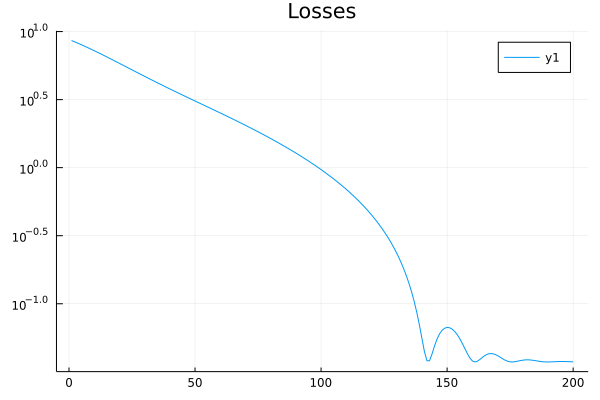

In [13]:
plot(losses, yaxis=:log, title="Losses")

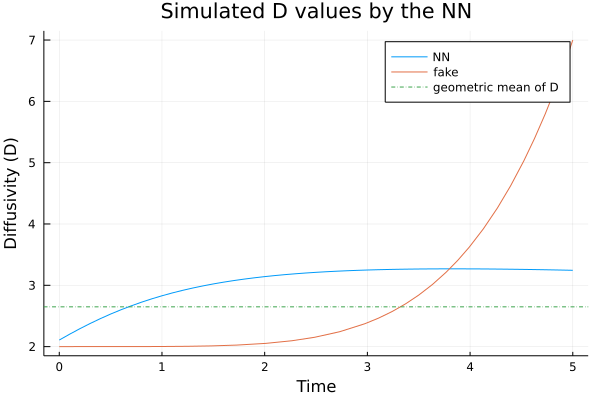

In [16]:
all_times = [0:Δt:t₁;]# LinRange(0, t₁, 1000)
all_D = UD_trained(all_times')'
all_fake_D = fakeD.(all_times)

plot(all_times, all_D, title="Simulated D values by the NN", yaxis="Diffusivity (D)", xaxis="Time", label="NN")
plot!(fakeD, 0, t₁, label="fake")
hline!([geomean(all_fake_D)], label="geometric mean of D", linestyle = :dashdot)

In [17]:
geomean(all_fake_D)

2.648335573159686

In [18]:
geomean(all_D)

3.0235476f0

In [19]:
mean(all_D)

3.0420027f0

In [20]:
mean(all_fake_D)

2.8668299999999998